### Perfect hashing bechmark  - https://en.wikipedia.org/wiki/Perfect_hash_function (with keys known at compile-time)
  - https://github.com/boost-ext/mph/blob/benchmark/perfect_hashing/benchmark.ipynb

---

#### Compilers
  - clang++-19                - https://clang.llvm.org
  - g++-13                    - https://gcc.gnu.org

#### CXXFLAGS
  - -std=c++20                - mph requires C++20 and optionally experimental::simd, frozen requires C++14, unordered_map, boost_unordered_flat_map require C++11, map, if_else, switch_case require C++98
  - -DNDEBUG
  - -O3                       - see https://gcc.gnu.org/onlinedocs/gcc/Optimize-Options.html
  - -march=native             - tested on x86-64, mph requires bmi2, simd, boost_unordered_flat_map requires sse, see cells below for details of used hardware for testing (but it supports -mbmi2 and -mavx2)

#### Targets (with default settings) - https://github.com/boost-ext/mph/tree/benchmark/perfect_hashing
  - if_else                  - recursive if else
  - switch_case              - nested switch case
  - map                      - std::map (with std::hash)
  - unordered_map            - std::unordered_map (with std::hash)
  - boost_unordered_flat_map - https://www.boost.org/doc/libs/1_85_0/libs/unordered/doc/html/unordered.html (with default hash)
  - gperf                    - https://www.gnu.org/software/gperf (supports only string-like keys)
  - frozen                   - https://github.com/serge-sans-paille/frozen (with default hash)
  - mph                      - https://github.com/boost-ext/mph (requires bmi2, simd)

#### Benchmarks
  - int_to_int               - integer to integer
  - str_to_int               - string_view to integer

#### Measurements
  - lookup time              - how long it takes to lookup given keys (smaller is better)
  - build time               - how long it takes to compile with includes (smaller is better)
  - binary size              - size of the stripped binary (smaller is better)

#### Parameters (known at compile-time)
  - size                     - elements size (gperf, frozen, mph supports up to thousands of pairs known at compile/generation time)
  - range                    - min, max values when generating integers ([0-65535] - random integers from 0 to 65535) 
  - length                   - min, max length when generating strings ([1-8] - random strings from 1 to 8 characters, mph uses uint32/uint64/x86.__m128i/x86.__mm256i/x86.__mm512i to represent strings, hence it supports strings up to 64 characters)
  - probability              - successful lookups ratio (0.00 - keys never found, 0.50 - keys found 50% of the time, 1.00 - keys always found)
  - seed                     - pseudo random numbers seed

#### Notes                   - 'There is no silver bullet if it comes to the performance, just trade-offs!'
  - if_else                  - fast for a few pairs, slower with low probabilities and larger sizes
  - switch_case              - similar to if_else but can generate jump-table, bittest depending on the input keys, flattening switch-case optimization depends on the compiler (see https://github.com/gcc-mirror/gcc/blob/master/gcc/tree-switch-conversion.cc for details)
  - map                      - slower with larger sizes, hash function dependent (see https://en.cppreference.com/w/cpp/container/map for details)
  - unordered_map            - slower than boost_unordered_flat_map, hash function dependent with closed addressing (see https://en.cppreference.com/w/cpp/container/unordered_map for details)
  - boost_unordered_flat_map - fast lookup, open addressing, fast with large sizes and low probabilities, hash function dependent (see http://bannalia.blogspot.com/2022/11/inside-boostunorderedflatmap.html for details)
  - gperf                    - fast lookup and fast compilation times (it requires seperate code generation and works only with string-like keys - see https://www.dre.vanderbilt.edu/~schmidt/PDF/gperf.pdf for details)
  - frozen                   - relatively fast lookup but slower than boost_unorderd_flat_map, gperf, mph, hash function dependent (see http://stevehanov.ca/blog/index.php?id=119 for details)
  - mph                      - the fastest lookup but has the most limitations and hardware requirements, compilation times might be longer for larger sizes depending on the input (see https://github.com/boost-ext/mph#faq for details)

---

#### mph [lookup/find]       - https://github.com/boost-ext

<table>
<tr><td><pre><code>
int lookup(int id) {
  static constexpr std::array ids{
    std::pair{54u, 91u},
    std::pair{64u, 324u},
    std::pair{91u, 234u},
  };
  return mph::lookup<ids>(id);
}
</code></pre></td><td><pre><code>lookup: // g++ -DNDEBUG -std=c++20 -O3
  imull   $1275516394, %edi, %eax
  shrl    $23, %eax
  movl    $24029728, %ecx
  shrxl   %eax, %ecx, %eax
  andl    $511, %eax
  retq
</code></pre></td><td><a href="https://godbolt.org/z/ndr5K8n8K">https://godbolt.org/z/ndr5K8n8K</a></td></tr>
<tr><td><pre><code>
int lookup(int id) {
  static constexpr std::array ids{
    std::pair{54u, 91u},
    std::pair{324u, 54u},
    std::pair{64u, 324u},
    std::pair{234u, 64u},
    std::pair{91u, 234u},
  };
  return mph::lookup<ids>(id);
}
</code></pre></td><td><pre><code>lookup: // g++ -DNDEBUG -std=c++20 -O3
  andl    $7, %edi
  leaq    lookup(%rip), %rax
  movl    (%rax,%rdi,4), %eax
  retq

lookup:
 .long   324
 .long   0
 .long   64
 .long   234
 .long   54
 .long   0
 .long   91
</code></pre></td><td><a href="https://godbolt.org/z/aE3117Goh">https://godbolt.org/z/aE3117Goh</a></td>
</tr><tr><td><pre><code>
int find(int id) {
  static constexpr std::array ids{
    std::pair{27629, 1},
    std::pair{6280, 2},
    // 1..128 pairs...
    std::pair{33691, 128},
  };
  return *mph::find<ids>(id);
}
</code></pre></td><td><pre><code>find: // g++ -DNDEBUG -std=c++20 -O3 -mbmi2 -mavx512f
  vpbroadcastd    %edi, %zmm0
  shll            $4, %edi
  movzbl          %dil, %ecx
  leaq            find
  vpcmpeqd        (%rdx,%rcx,4), %zmm0, %k0
  kmovw           %k0, %esi
  kortestw        %k0, %k0
  rep             bsfq %rax, %rax
  movl            $64, %eax
  addl            %eax, %ecx
  xorl            %eax, %eax
  testw           %si, %si
  cmovnel         1024(%rdx,%rcx,4), %eax
  vzeroupper
  retq

find:
  ... // see godbolt
</code></pre></td><td><a href="https://godbolt.org/z/35oYfaWGo">https://godbolt.org/z/35oYfaWGo</a></td>
</tr><tr><td><pre><code>
int find(std::string_view str) {
  static constexpr auto symbols = std::array{
    std::pair{"AMZN"sv, 1},
    std::pair{"AAPL"sv, 2},
    std::pair{"GOOGL"sv, 3},
    std::pair{"META"sv, 4},
    std::pair{"MSFT"sv, 5},
    std::pair{"NVDA"sv, 6},
    std::pair{"TSLA"sv, 7},
  };
  return *mph::find<symbols>(str);
}
</code></pre></td><td><pre><code>find: // g++ -DNDEBUG -std=c++20 -O3 -mbmi2
  shll    $3, %edi
  bzhil   %edi, (%rsi), %eax
  movl    $789, %ecx
  pextl   %ecx, %eax, %ecx
  leaq    find(%rip), %rdx
  xorl    %esi, %esi
  cmpl    (%rdx,%rcx,8), %eax
  movzbl  4(%rdx,%rcx,8), %eax
  cmovnel %esi, %eax
  retq

find:
  ... // see godbolt
</code></pre></td><td><a href="https://godbolt.org/z/ob6ejGEsh">https://godbolt.org/z/5T3EYnsnW</a></td>
</tr>
</table>

#### Acknowledgments
  - https://lemire.me/blog | http://0x80.pl | https://easyperf.net | https://www.jabperf.com | https://johnnysswlab.com
  - [pefect-hashing](https://github.com/tpn/pdfs/tree/master/Perfect%20Hashing) | [gperf](https://www.dre.vanderbilt.edu/~schmidt/PDF/C++-USENIX-90.pdf) | [cmph](https://cmph.sourceforge.net/papers) | [smasher](https://github.com/rurban/smhasher) | [minimal perfect hashing](http://stevehanov.ca/blog/index.php?id=119) | [hash functions](https://nullprogram.com/blog/2018/07/31)

In [5]:
!pyperf system tune

Tune the system configuration to run benchmarks

System state

CPU: use 16 logical CPUs: 0-15
Perf event: Maximum sample rate: 100000 per second
ASLR: Full randomization
Linux scheduler: No CPU is isolated
CPU Frequency: 0-3,8-11=min=400 MHz, max=4600 MHz; 4-7=min=400 MHz, max=4700 MHz; 12-15=min=400 MHz, max=3500 MHz
CPU scaling governor (intel_pstate): powersave
Turbo Boost (intel_pstate): Turbo Boost enabled
IRQ affinity: irqbalance service: inactive
IRQ affinity: Default IRQ affinity: CPU 0-15
Power supply: the power cable is plugged

Advices

Perf event: Set max sample rate to 1
Linux scheduler: Use isolcpus=<cpu list> kernel parameter to isolate CPUs
Linux scheduler: Use rcu_nocbs=<cpu list> kernel parameter (with isolcpus) to not schedule RCU on isolated CPUs
CPU scaling governor (intel_pstate): Use CPU scaling governor 'performance'
Turbo Boost (intel_pstate): Disable Turbo Boost to get more reliable CPU frequency

Errors

Perf event: Failed to write into /proc/sys/kernel/perf_

In [9]:
!cat /proc/cpuinfo | grep -m 1 -A 26 '^processor'
!getconf -a | grep CACHE
!lstopo-no-graphics --no-io --no-legend

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 154
model name	: 12th Gen Intel(R) Core(TM) i7-12650H
stepping	: 3
microcode	: 0x430
cpu MHz		: 1647.921
cache size	: 24576 KB
physical id	: 0
siblings	: 16
core id		: 0
cpu cores	: 10
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 32
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art arch_perfmon pebs bts rep_good nopl xtopology nonstop_tsc cpuid aperfmperf tsc_known_freq pni pclmulqdq dtes64 monitor ds_cpl vmx smx est tm2 ssse3 sdbg fma cx16 xtpr pdcm sse4_1 sse4_2 x2apic movbe popcnt tsc_deadline_timer aes xsave avx f16c rdrand lahf_lm abm 3dnowprefetch cpuid_fault epb cat_l2 cdp_l2 ssbd ibrs ibpb stibp ibrs_enhanced tpr_shadow vnmi flexpriority ept vpid ept_ad fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms invpcid rdt_a rdseed adx smap clflushopt clwb intel_pt s

In [1]:
import os
import numpy as np

TMP='/dev/shm'
CXXFLAGS='-std=c++20 -DNDEBUG -O3 -march=native'
LDDFLAGS=''

def buildit(name, compiler, target, size, cfg):
    !rm -f f"{TMP}/{target}"
    CMD=f"CXX={compiler} CXXFLAGS=\"{CXXFLAGS}\" LDDFLAGS=\"{LDDFLAGS}\" SIZE={size} PROBABILITY={cfg['probability']} SEED={cfg['seed']} TMP={TMP} BENCHMARK={name} /usr/bin/time -f %e make -j -s"
    time = !{CMD} {target}
    assert _exit_code == 0
    try:
        return float(time[0])
    except:
        print(time)
    
def timeit(target, cpu = 1, runs = 3):
    times = []
    checksums = []
    !strip {TMP}/{target}
    for _ in range(runs):
        result = !taskset -c {cpu} {TMP}/{target}
        tokens = result[0].split(':')
        times.append(float(tokens[1]))
        checksums.append(int(tokens[0]))
    print('.', end='')
    binary_size = !stat -c %s {TMP}/{target}
    return times, checksums, int(binary_size[0])

In [2]:
import joblib, random, string
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import defaultdict

options = ['if_else', 'switch_case', 'map', 'unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph']
palette = sns.color_palette()
gperf   = """
struct data { const char* key; int value; };
%compare-strncmp
%language=C++
%enum
%includes
%readonly-tables
%global-table
%struct-type
%define slot-name key
%define lookup-function-name find
%%
"""

def generate_integers(size, rng):
    result = []
    for i in range(size):
        while True:
          new = random.randint(rng[0], rng[1])
          if new not in result:
            result.append(new)
            break
    return result

def generate_strings(size, length):
    result = []
    for i in range(size):
        while True:
          new = ''.join(random.choices(string.ascii_letters + string.digits, k=random.randint(length[0], length[1])))
          if new not in result:
            result.append(new)
            break
    return result

def generate(filename, size, cfg):
  if 'length' in cfg:
    data = generate_strings(size, cfg['length'])
    with open(filename + ".ipp", 'w') as file:
      for index, name in enumerate(data):
          file.write(f"std::pair{{\"{name}\"sv, {index + 1}}},\n")
    with open(filename + ".gperf", 'w') as file:
      file.write(gperf)
      for index, name in enumerate(data):
          file.write(f"\"{name}\", {index + 1}\n")
    return data
  elif 'range' in cfg:
    data = generate_integers(size, cfg['range'])
    with open(filename + ".ipp", 'w') as file:
      for index, value in enumerate(data):
          file.write(f"std::pair{{{value}, {index + 1}}},\n")
    return data

def benchmark(name, compilers, targets, sizes, combinations):
    for combination in combinations:
        _, ax_time   = plt.subplots(1, len(compilers), figsize=(22, 7))
        _, ax_build  = plt.subplots(1, len(compilers), figsize=(22, 7))
        _, ax_binary = plt.subplots(1, len(compilers), figsize=(22, 7))
        hashed_checksums = defaultdict(list)
        y_min = [np.iinfo(np.uint32).max, np.iinfo(np.uint32).max, np.iinfo(np.uint32).max]
        y_max = [np.iinfo(np.uint32).min, np.iinfo(np.uint32).min, np.iinfo(np.uint32).min]

        for i, compiler in enumerate(compilers):
            times = defaultdict(list)
            builds = defaultdict(list)
            binaries = defaultdict(list)

            for size in sizes:
                data = generate(f"{TMP}/data", size, combination)
                
                for target in targets:
                    time = buildit(name, compiler, target, size, combination)
                    builds[target].append(time)
                    ts, checksums, binary_size = timeit(target)
                    times[target].append(np.median(ts))
                    binaries[target].append(binary_size)
                    assert len(checksums) > 0 and all(checksum == checksums[0] for checksum in checksums), f"{compiler}, {target}, {size}, {combination}, {checksums}"
                    hash = joblib.hash([data, combination])
                    hashed_checksums[hash].append(checksums[0])
                    assert all(checksum == hashed_checksums[hash][0] for checksum in hashed_checksums[hash]), f"{compiler}, {target}, {size}, {combination}, {hashed_checksums[hash]}"

            def update(ax, n, data, title, ylabel):
                for target, data in data.items():
                    ax[i].plot(sizes, data, marker='o', markersize=3, label=target, color=palette[options.index(target)])
                    y_min[n] = min(y_min[n], min(data))
                    y_max[n] = max(y_max[n], max(data))

                ax[i].set_title(title, fontsize=9)
                ax[i].grid(True)
                for spine in ax[i].spines.values():
                    spine.set_visible(False)
                ax[i].set_xlabel('size')
                ax[i].set_ylabel(ylabel)
                ax[i].ticklabel_format(style='plain', axis='both')
                ax[i].legend(loc='upper left')
            
            update(ax_time, 0, times, f"[{name} - lookup time | smaller is better]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}", "lookup time [s]")
            update(ax_build, 1, builds, f"[{name} - build time | smaller is better]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}", "build time [s]")
            update(ax_binary, 2, binaries, f"[{name} - binary size (stripped) | smaller is better]\ncompiler: {compiler}, cxxflags: {CXXFLAGS}" + " \n" + f"{', '.join([f'{name}:{value}' for name, value in combination.items()])}", "binary size [bytes]")

        def ylim(ax, n):
            ax[1].yaxis.tick_right()
            for i in range(len(compilers)):
                ax[i].set_ylim(y_min[n], y_max[n] * 1.1)

        ylim(ax_time, 0)
        ylim(ax_build, 1)
        ylim(ax_binary, 2)

        plt.tight_layout()
        plt.show()

..............................................................................................................................

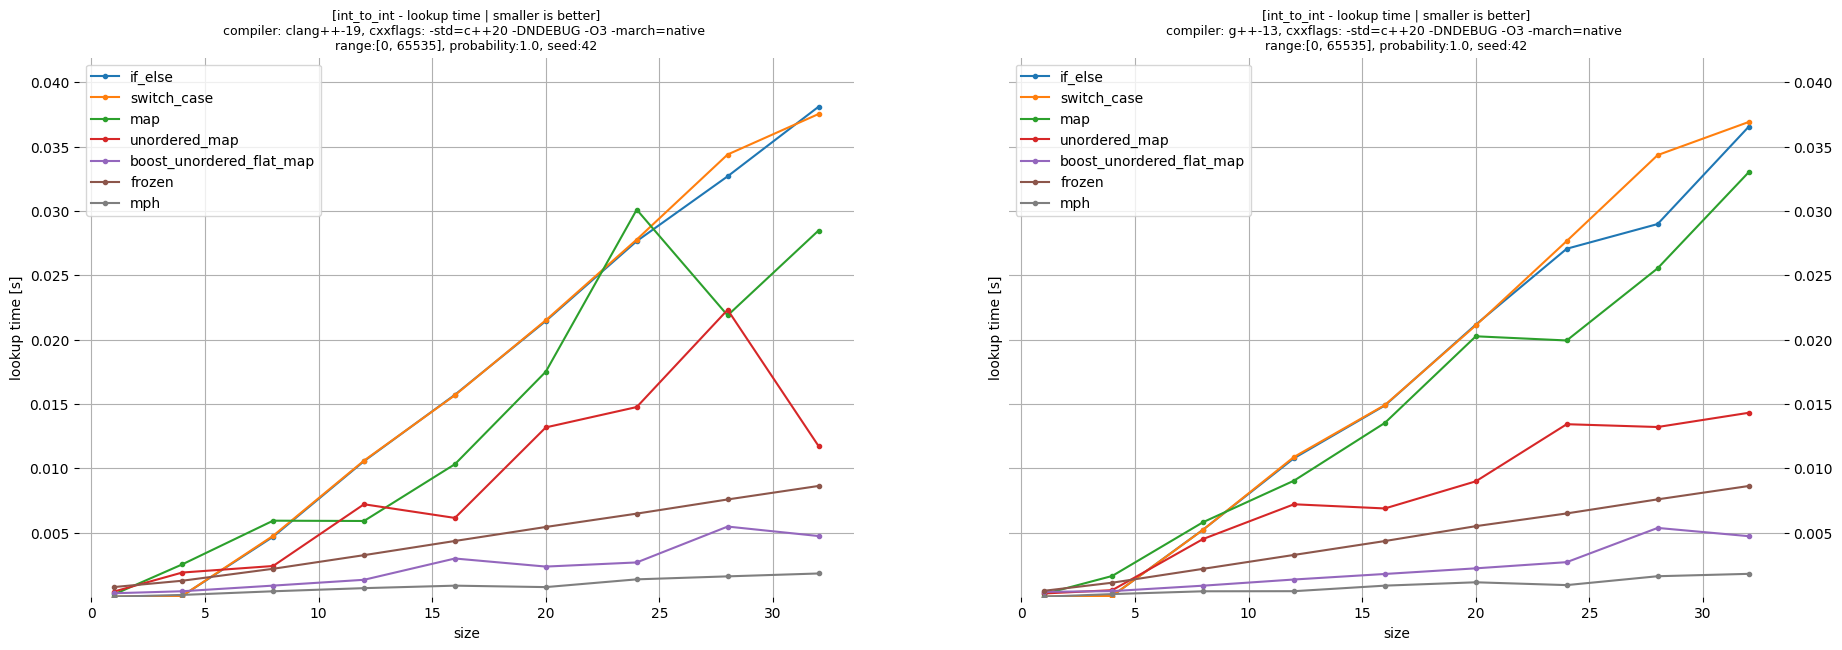

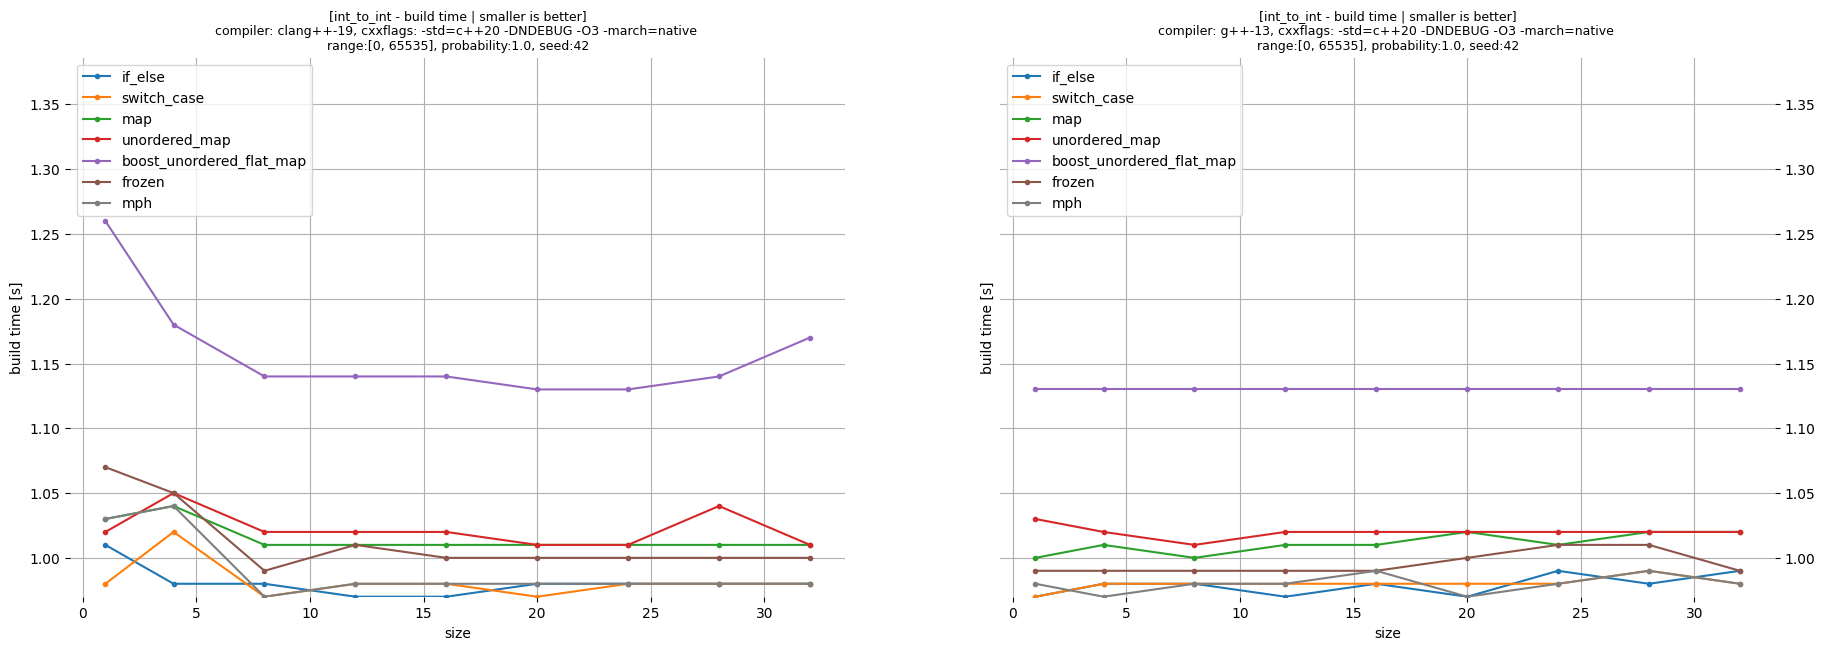

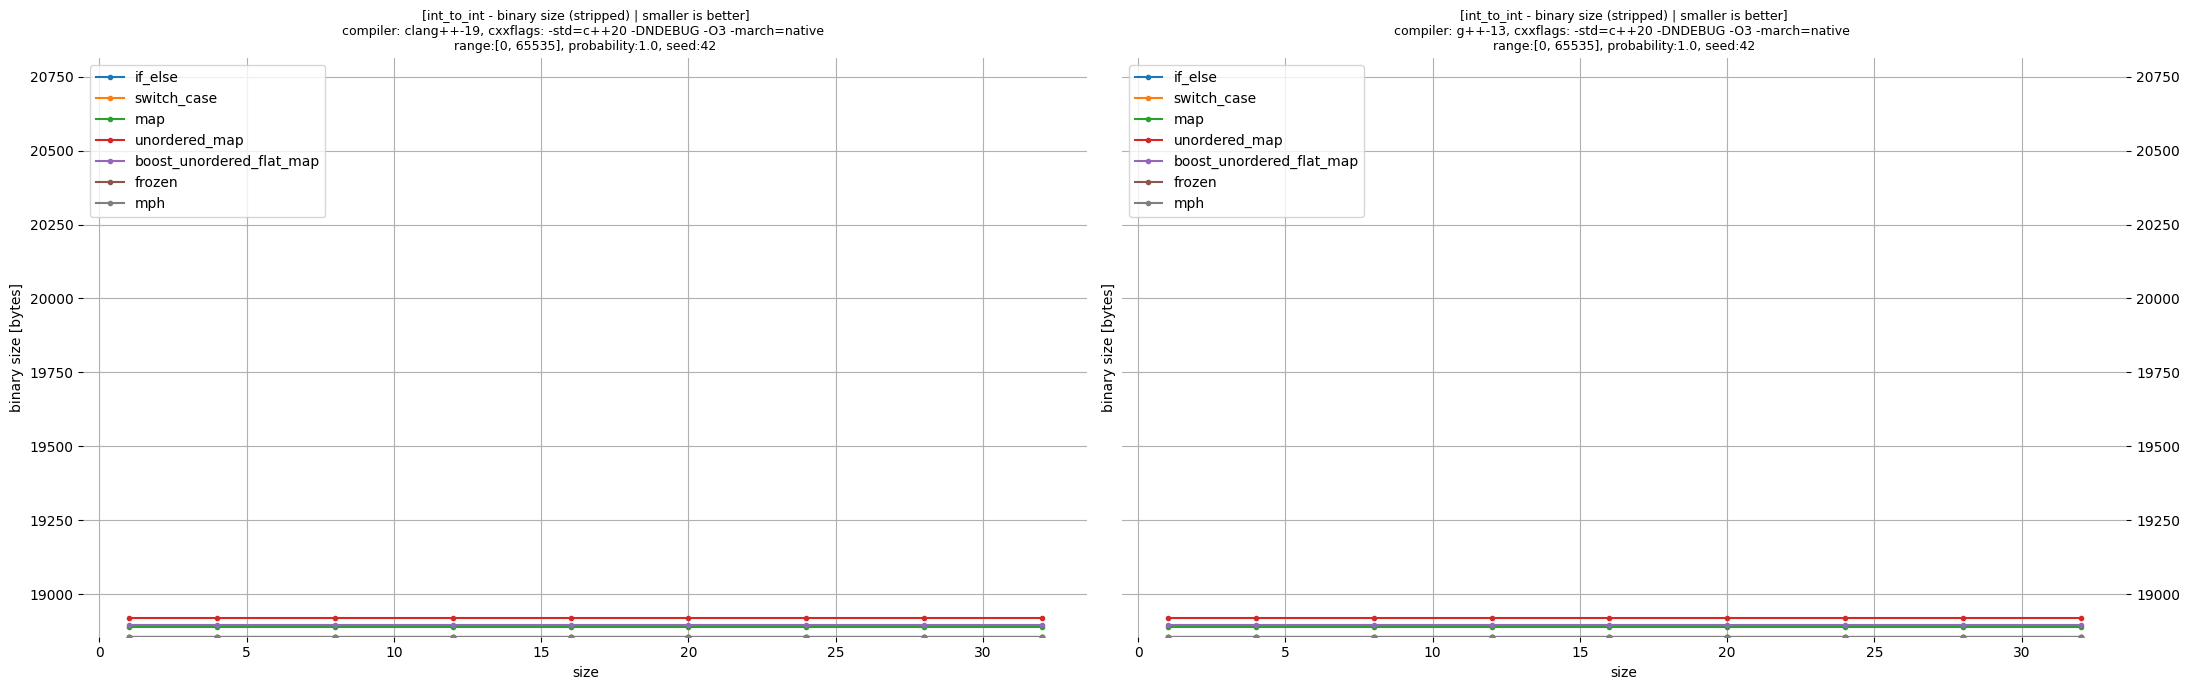

..............................................................................................................................

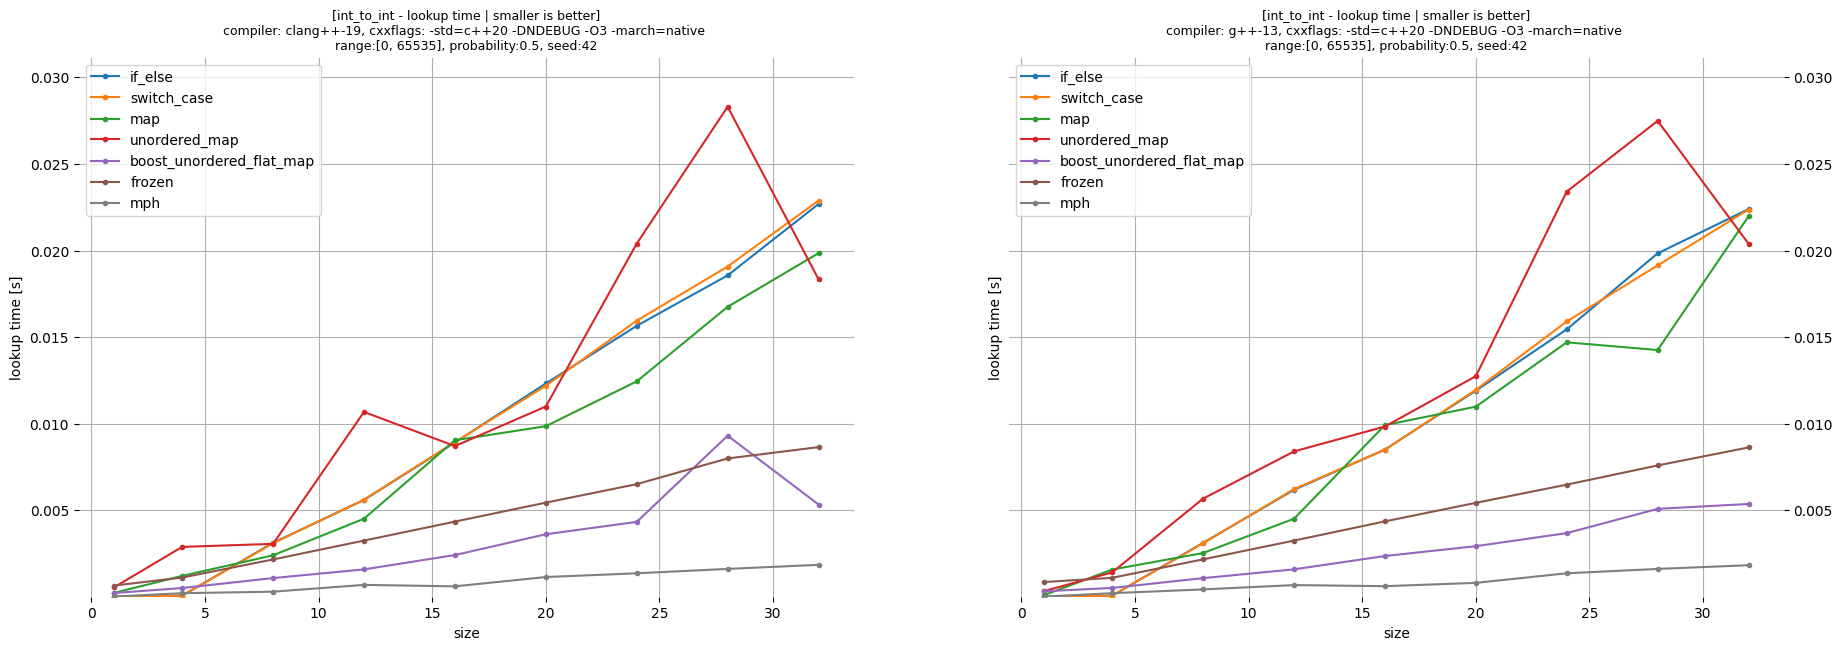

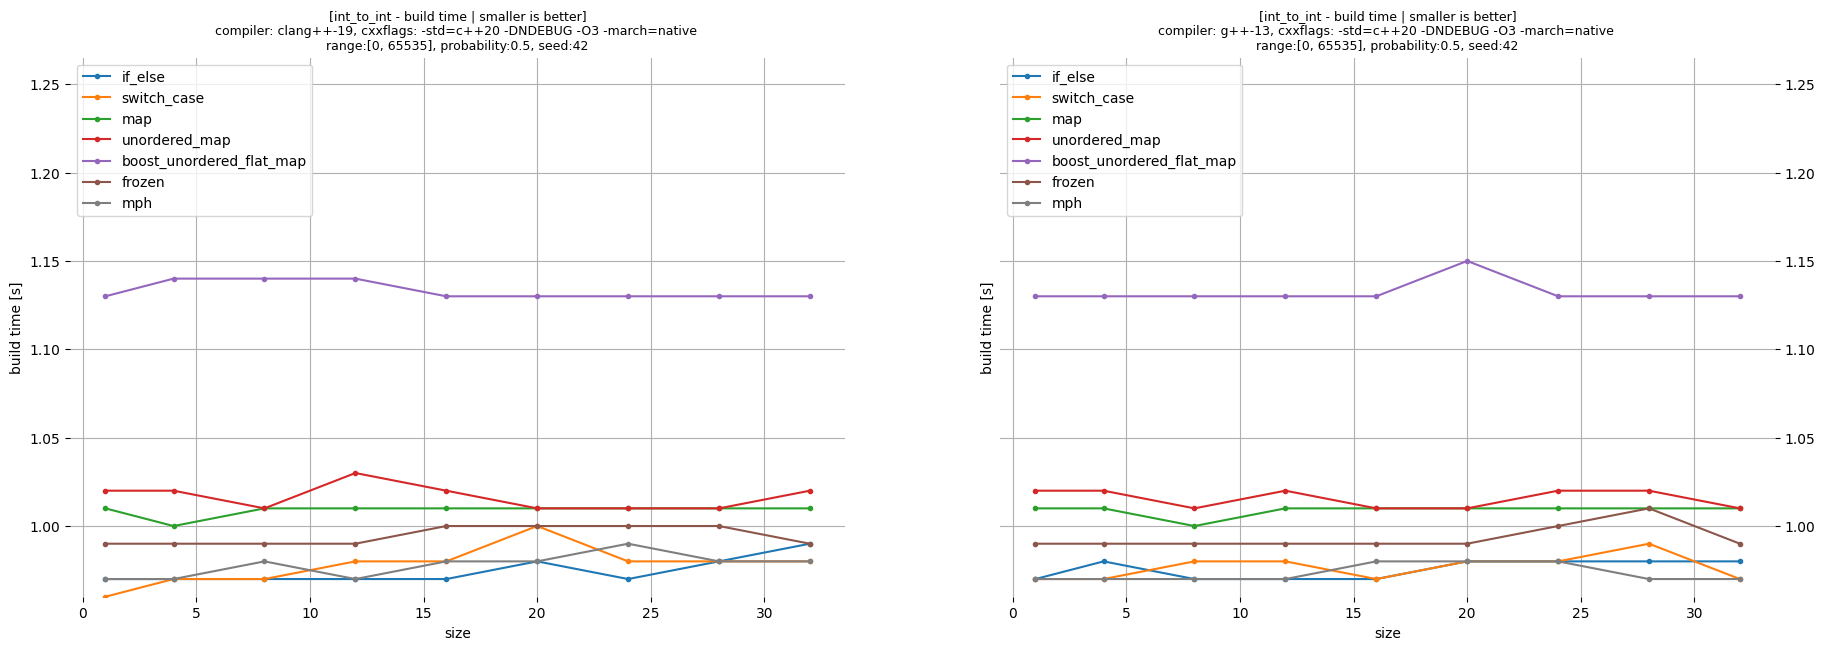

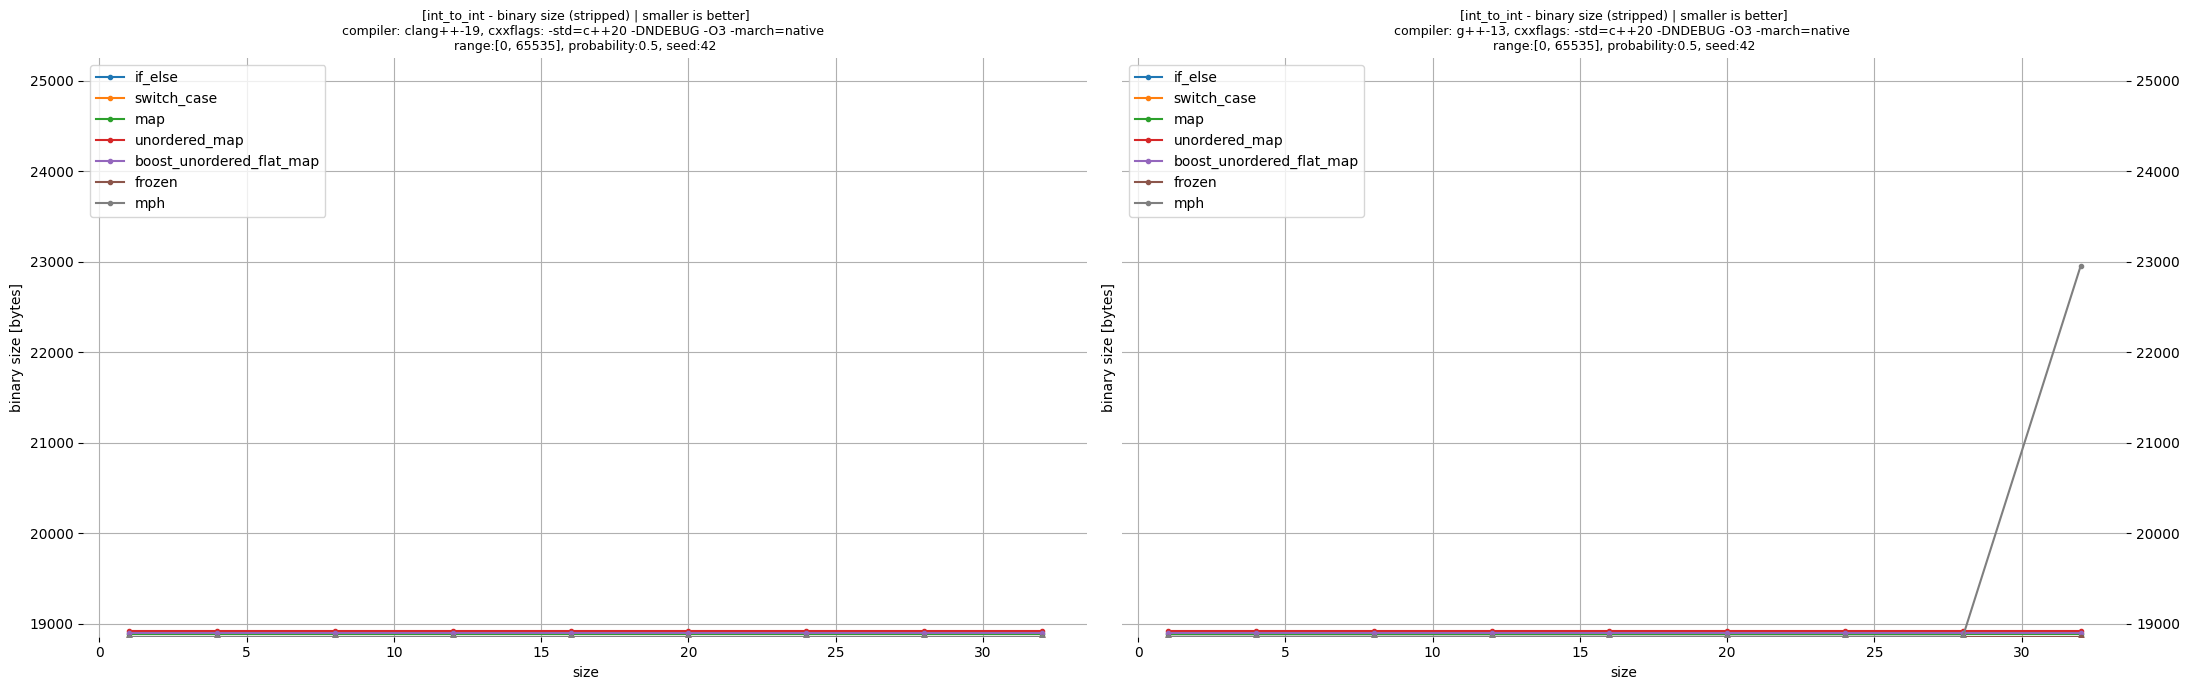

..............................................................................................................................

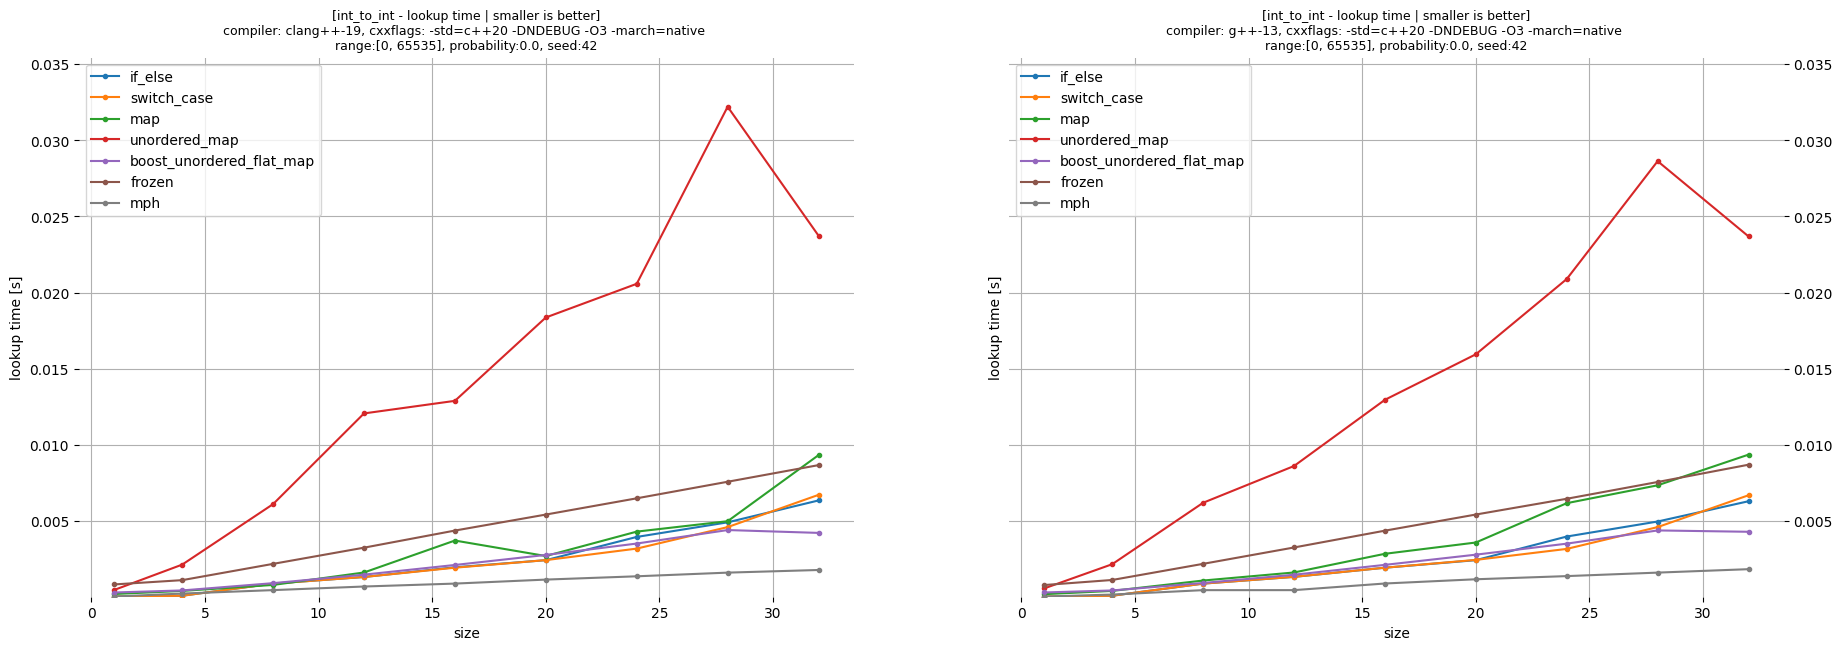

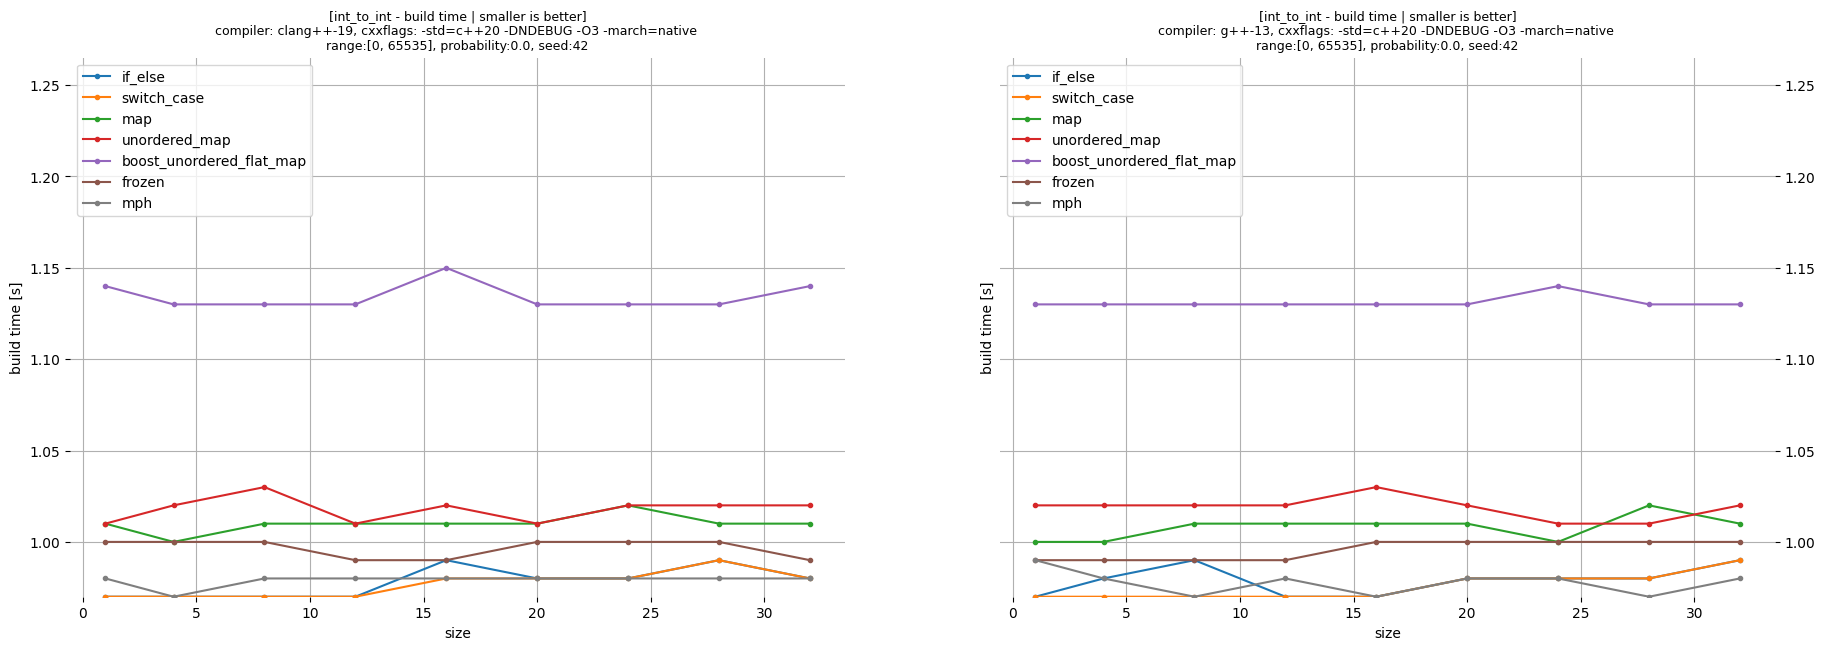

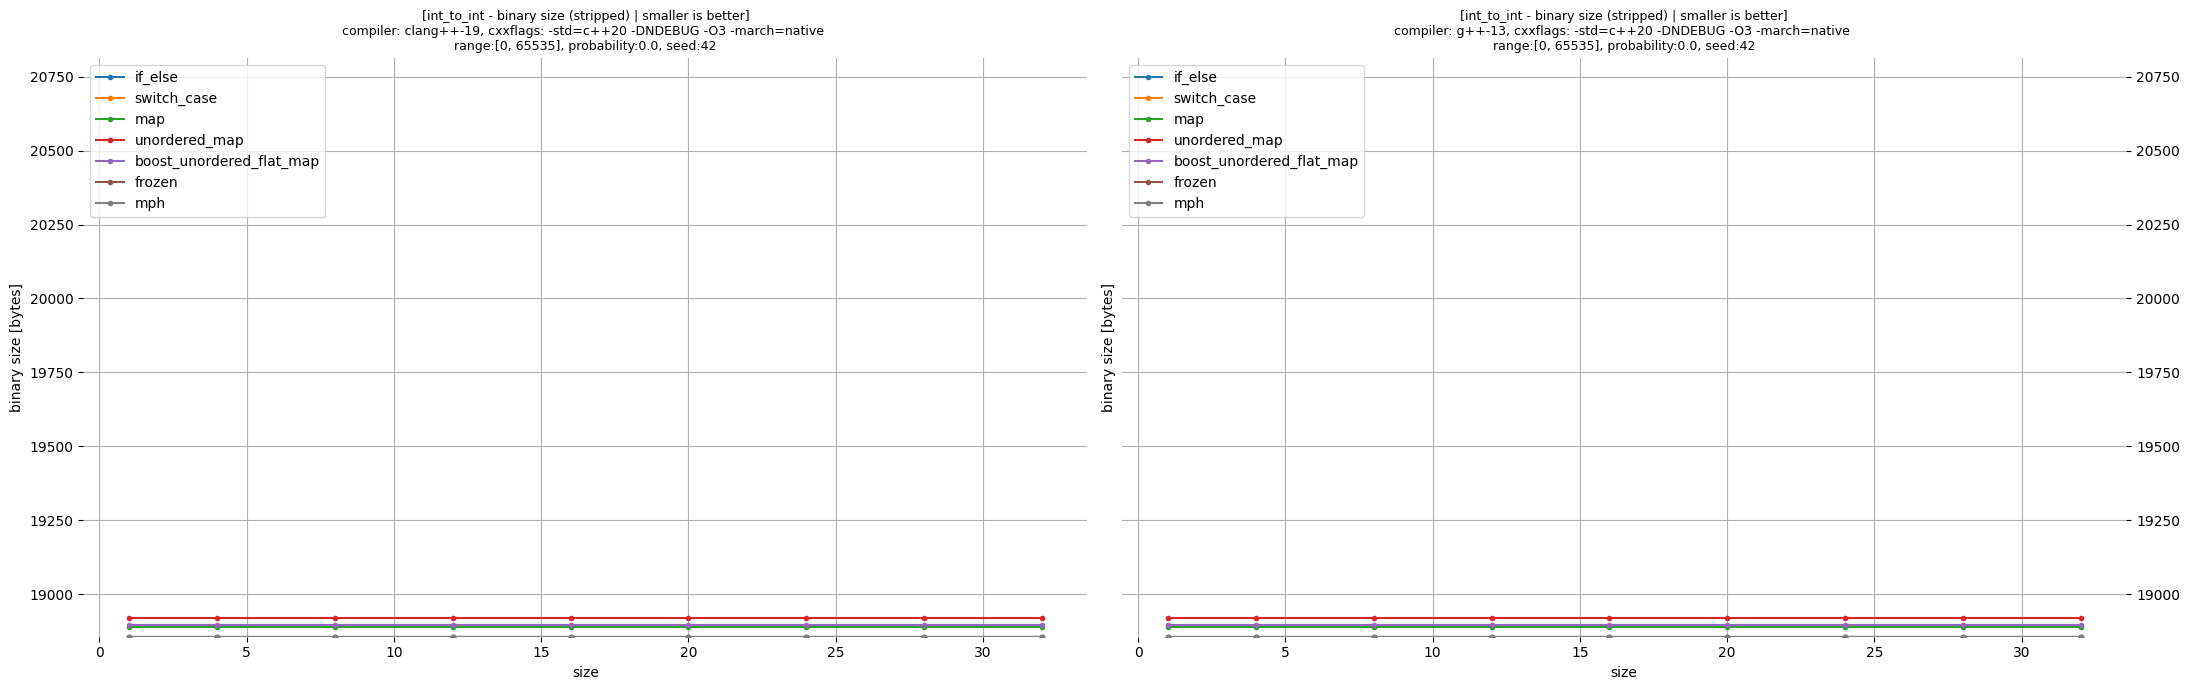

................................................................

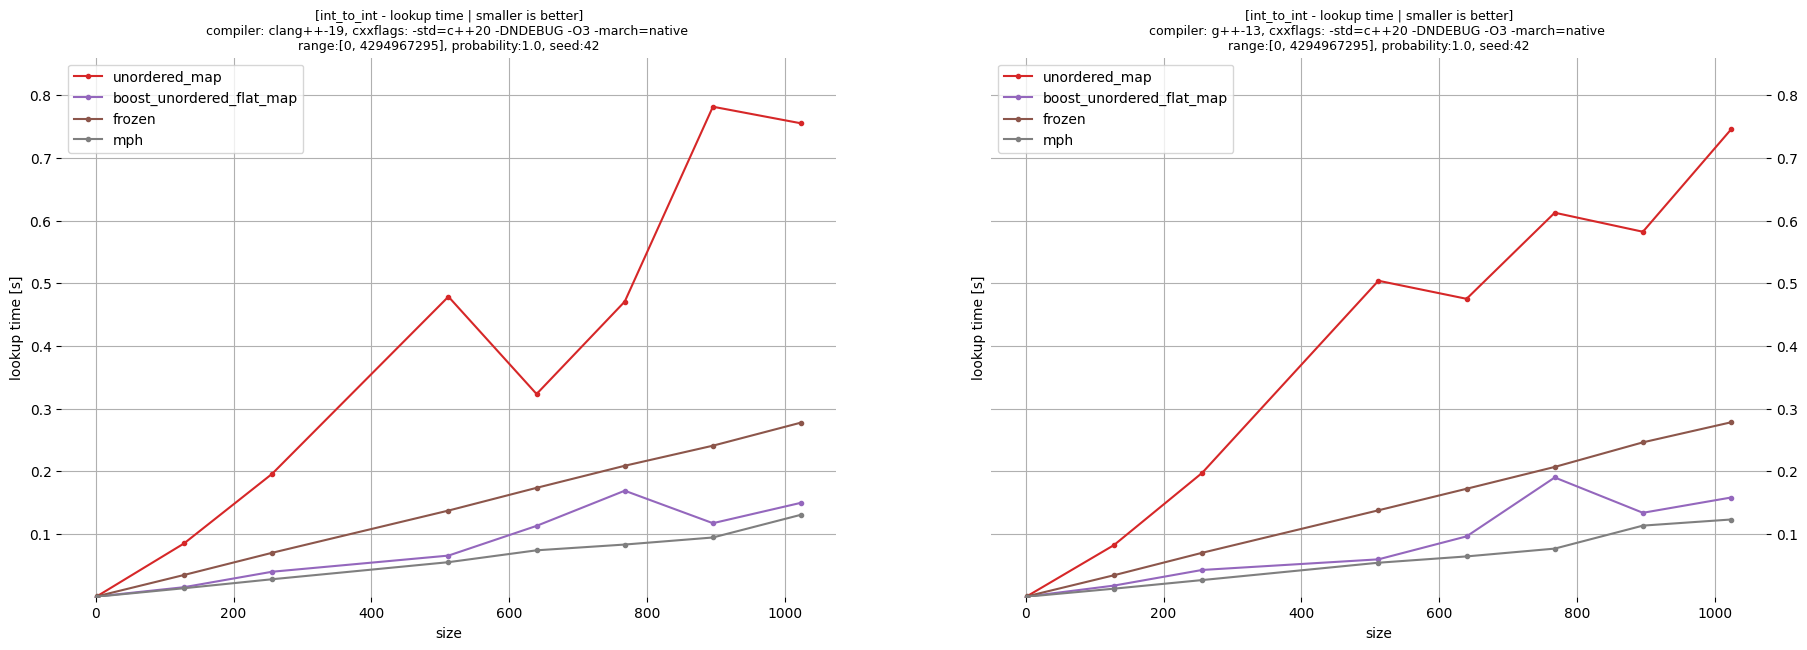

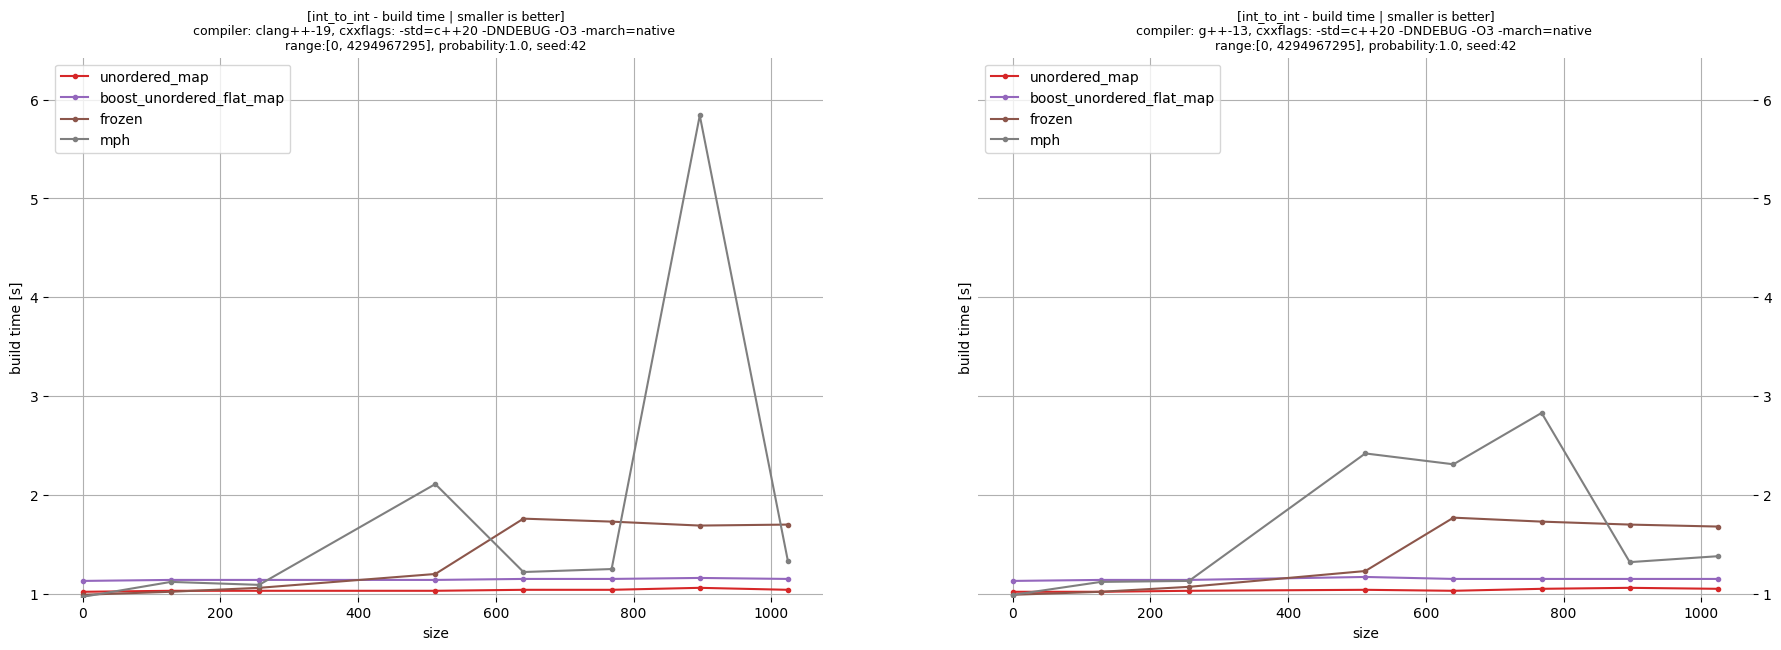

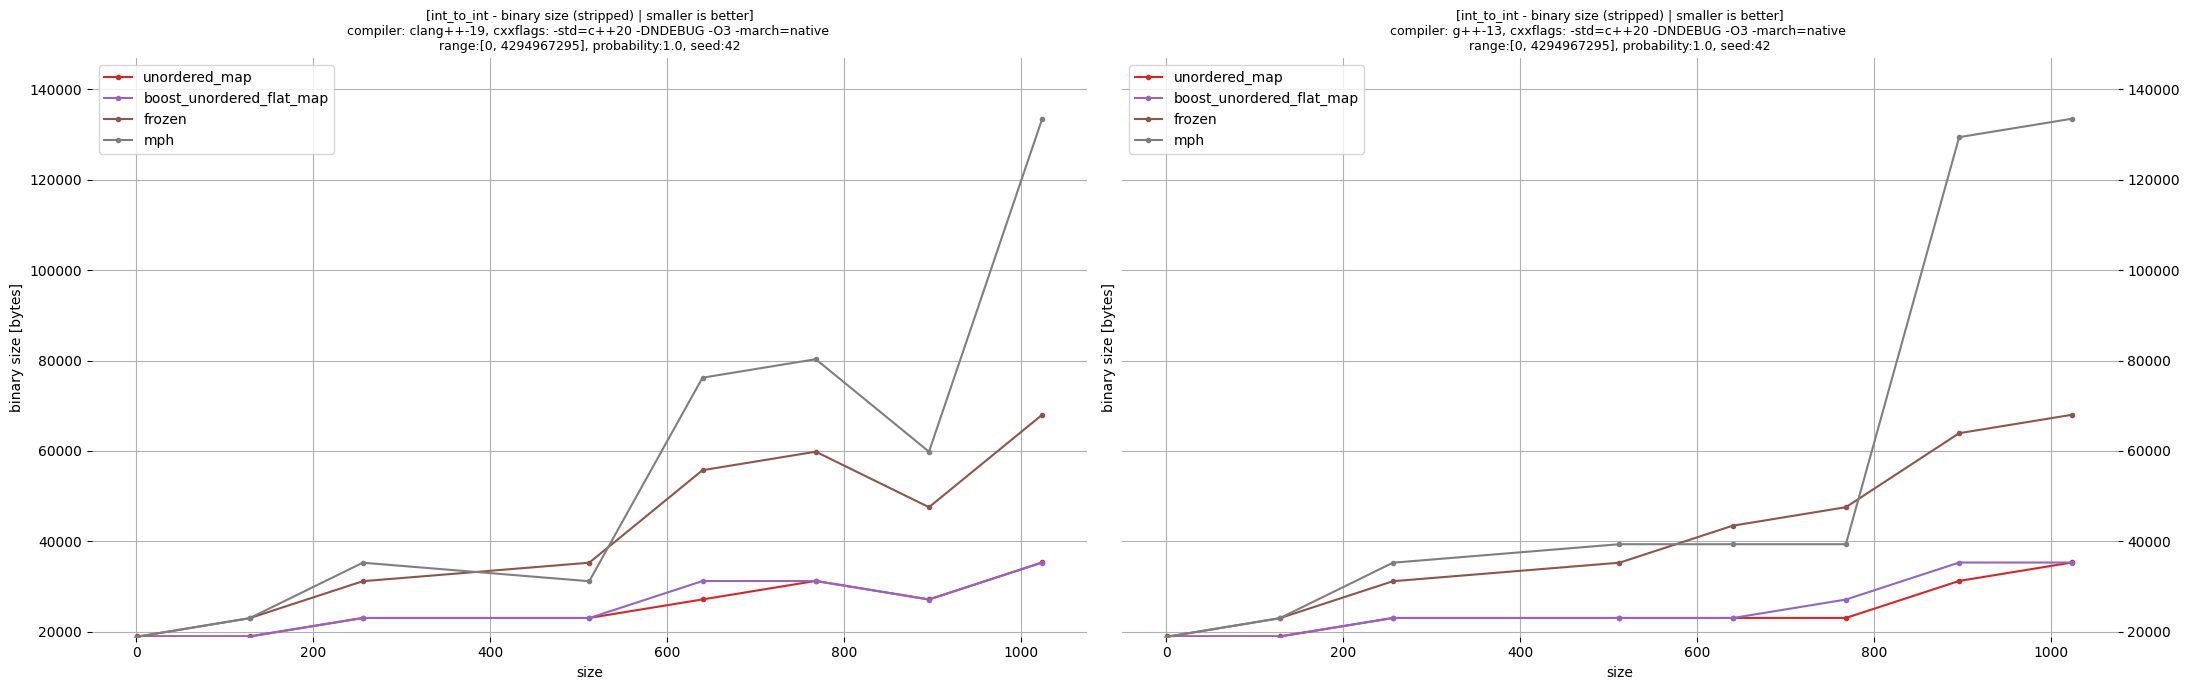

................................................................

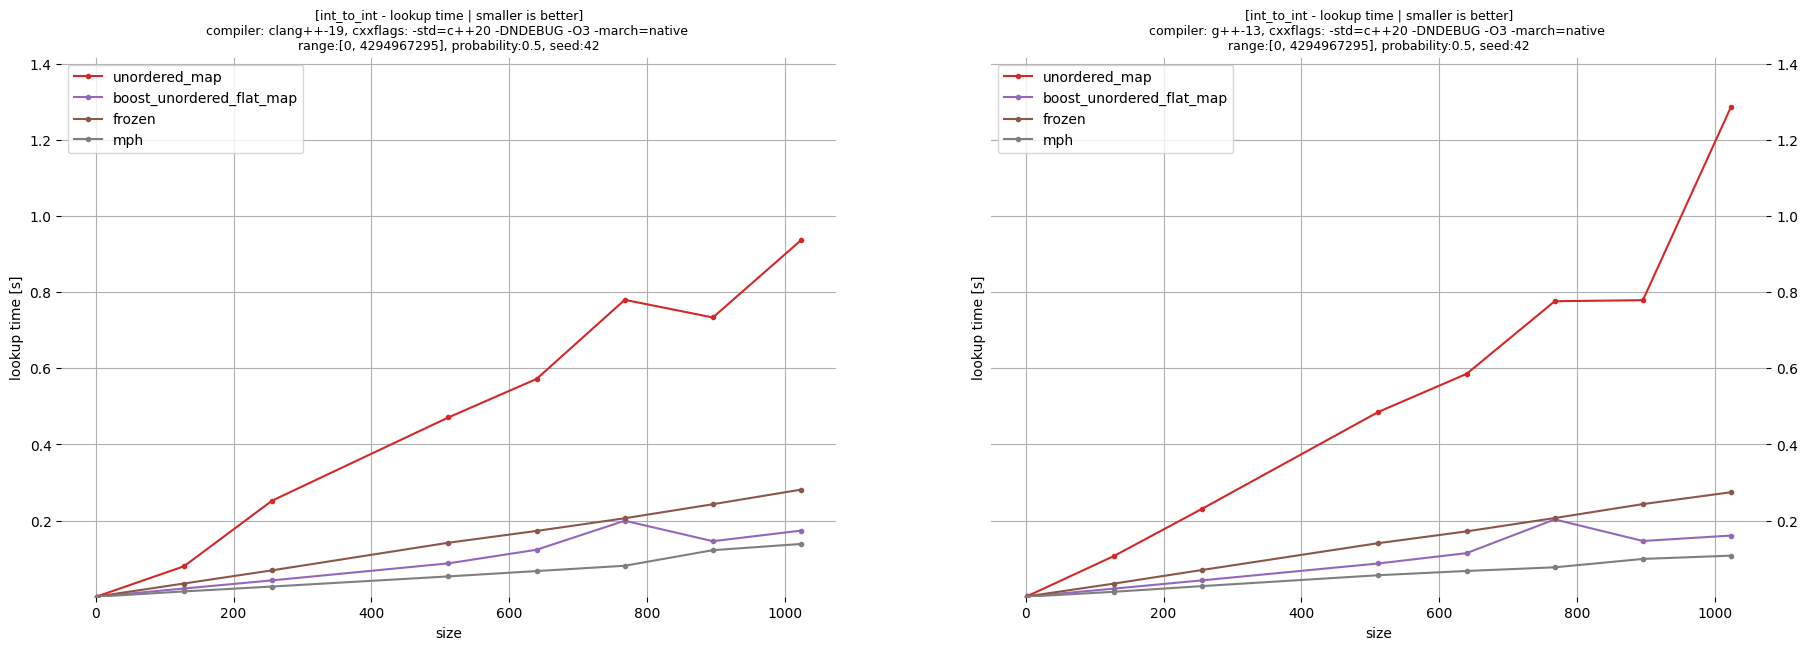

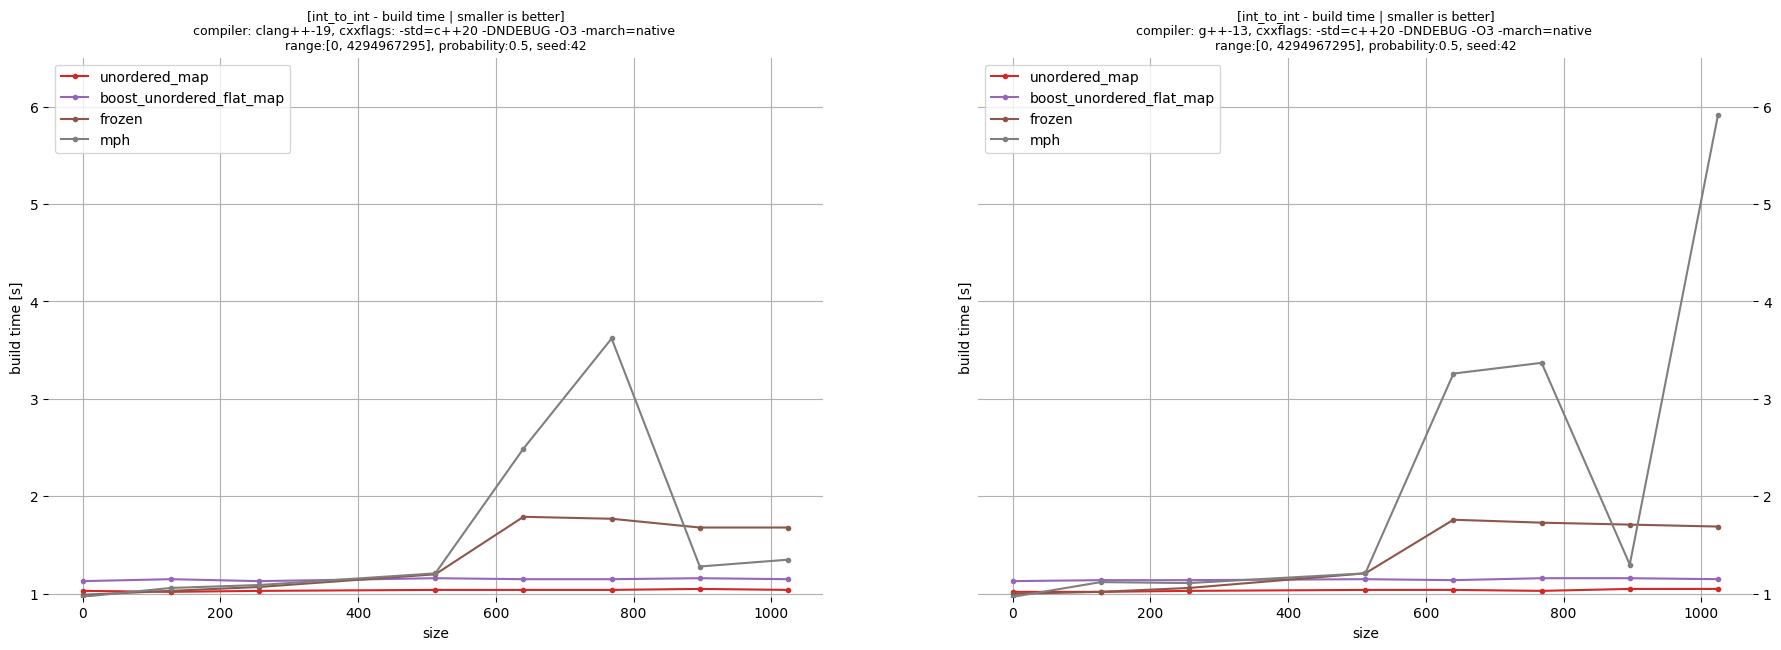

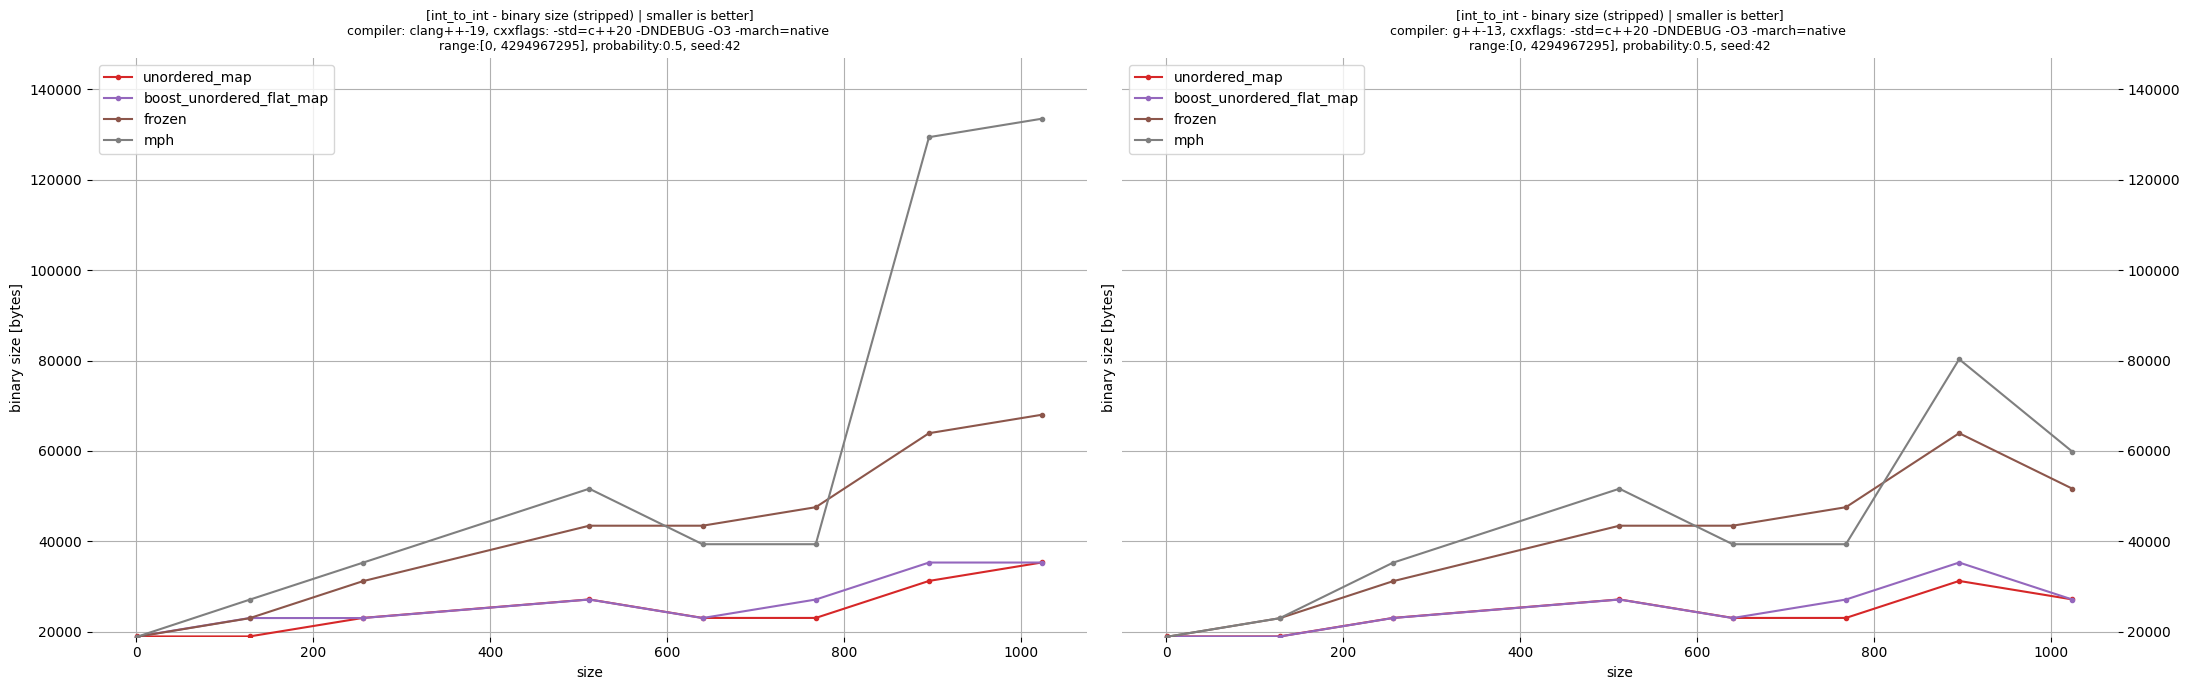

................................................................

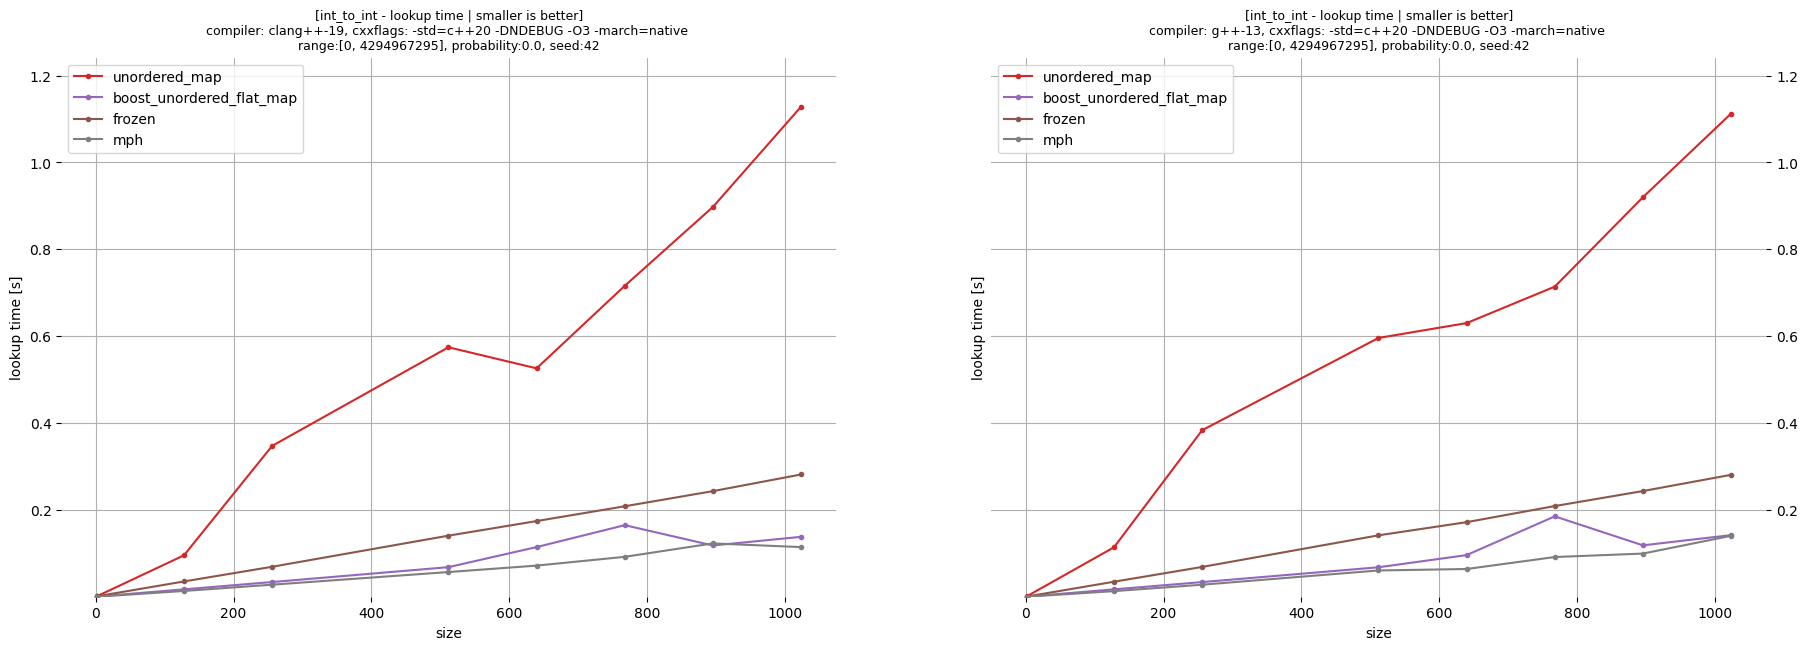

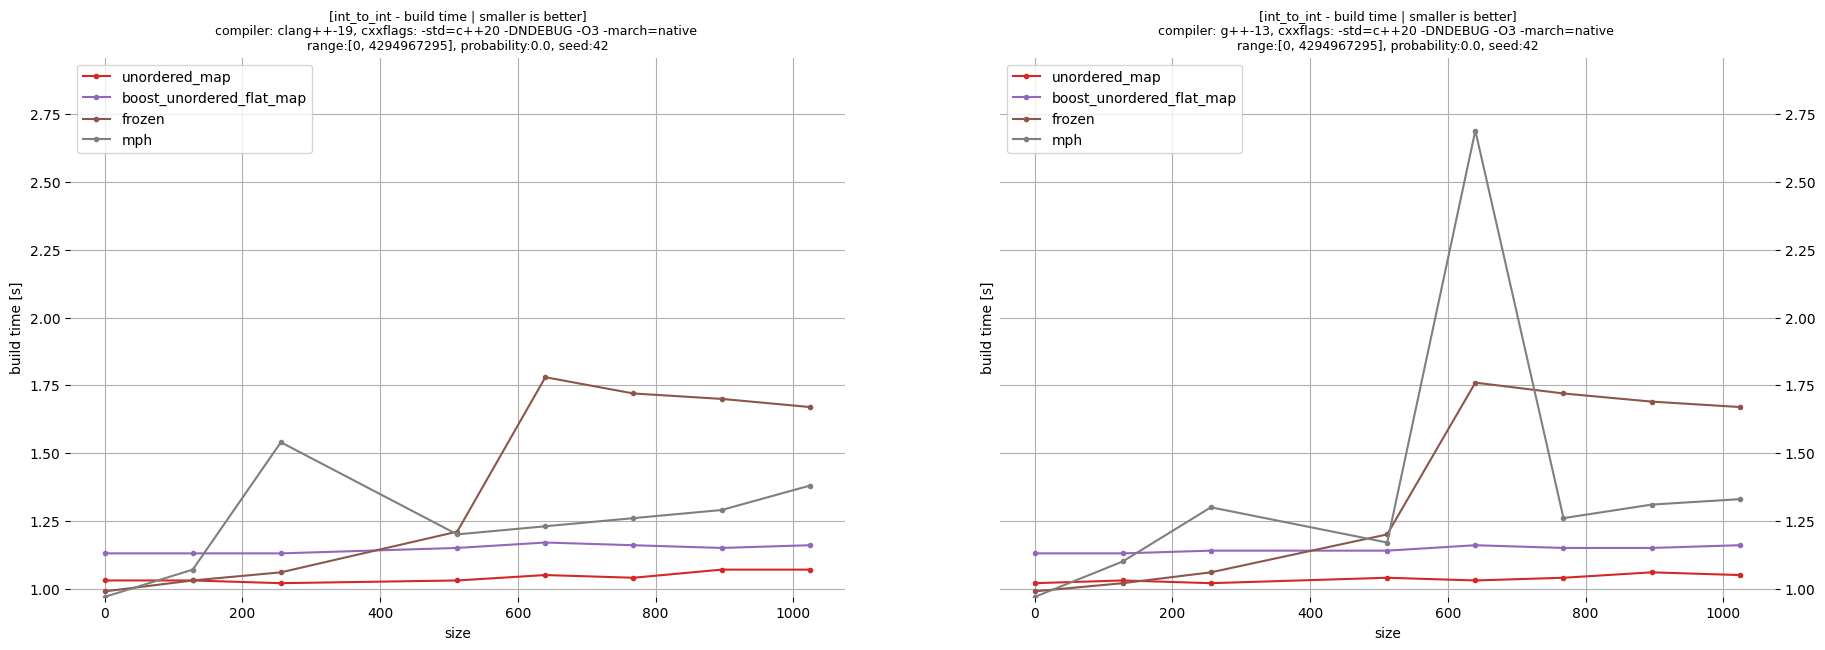

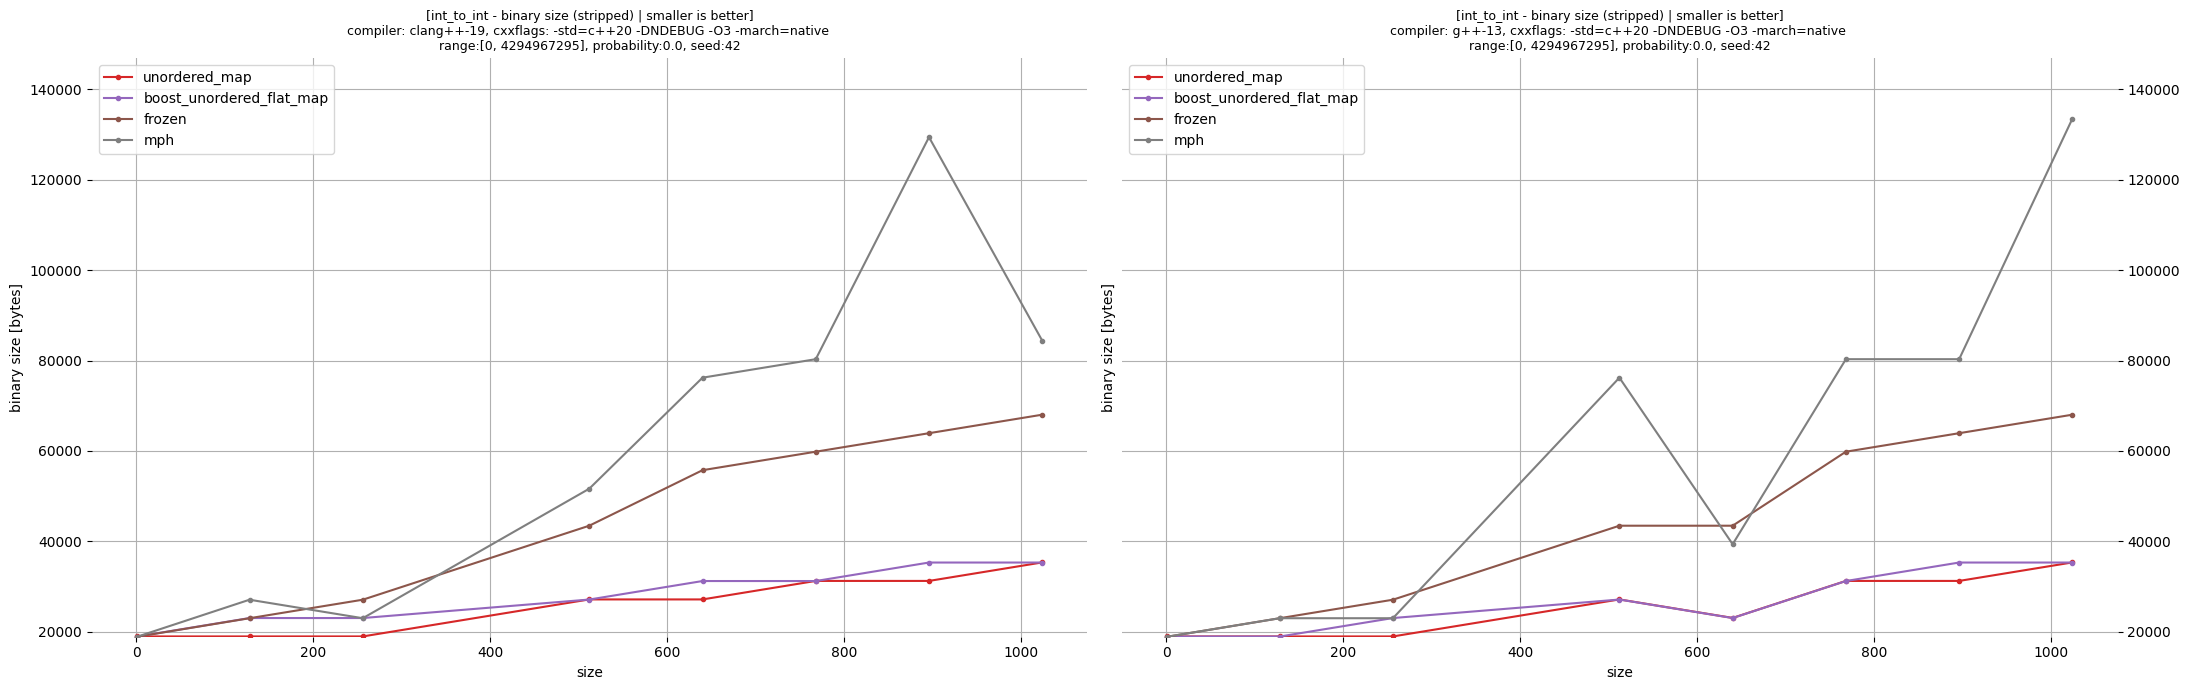

..............................................................................................................................

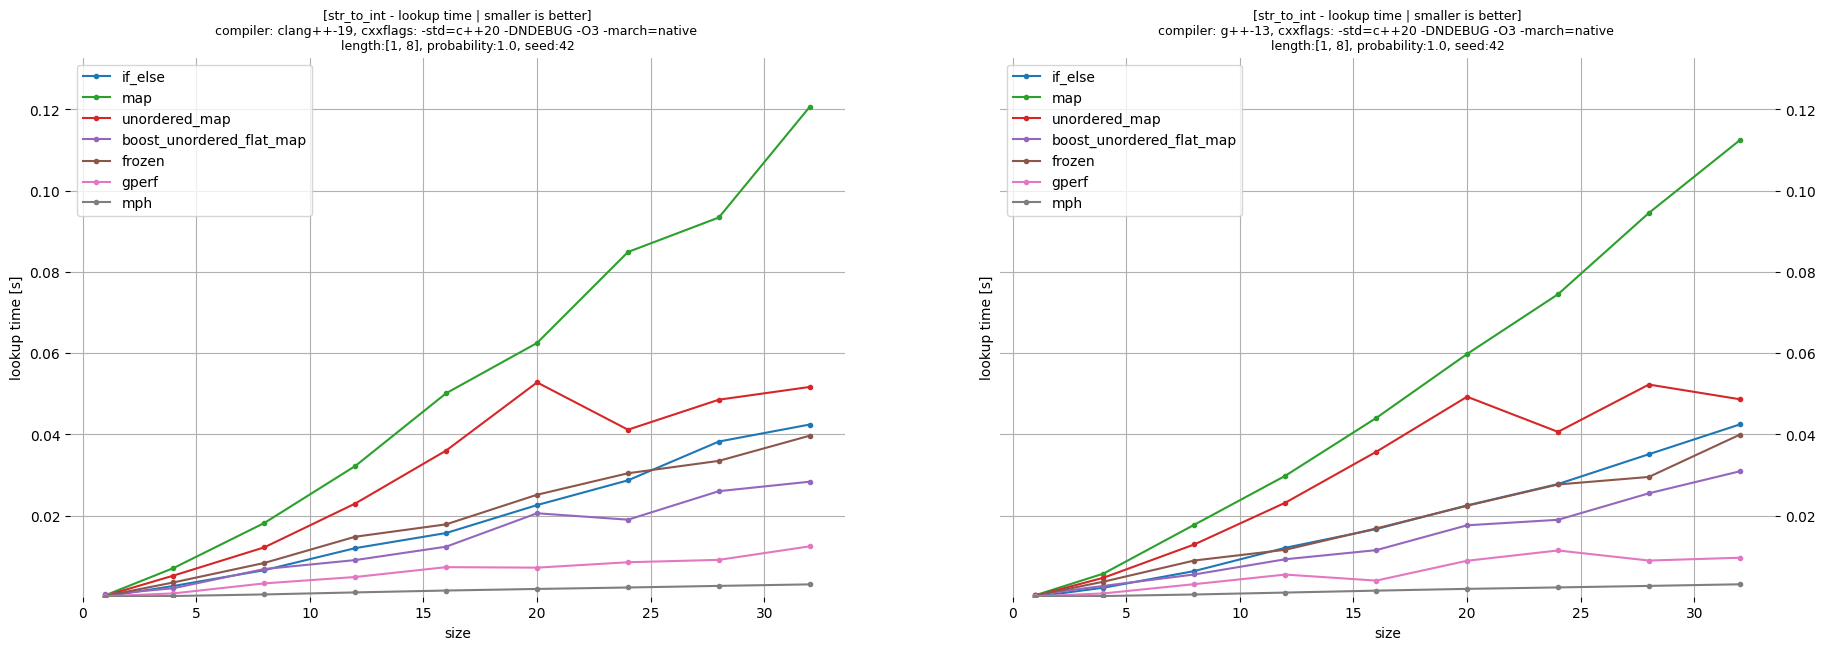

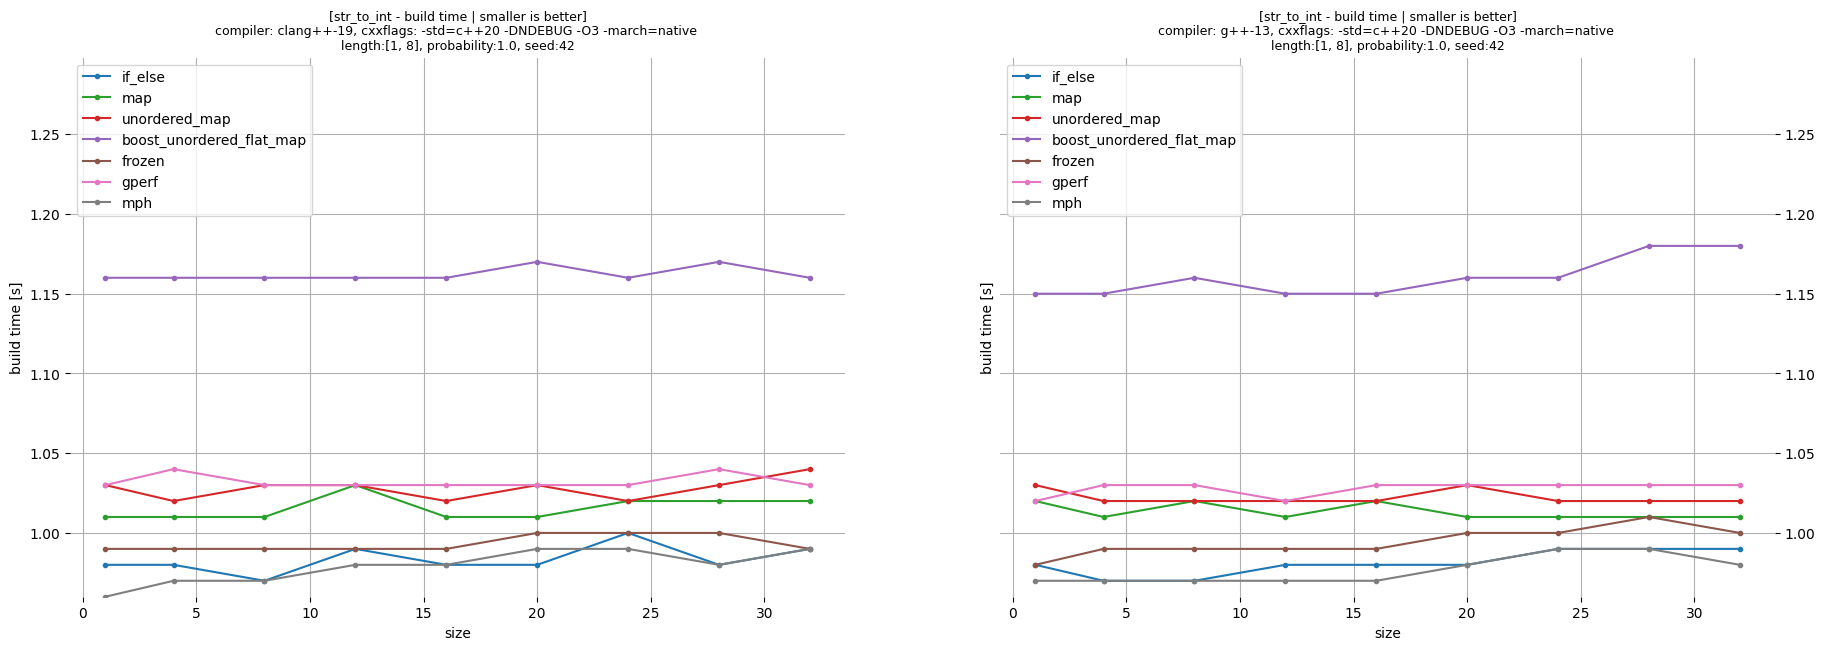

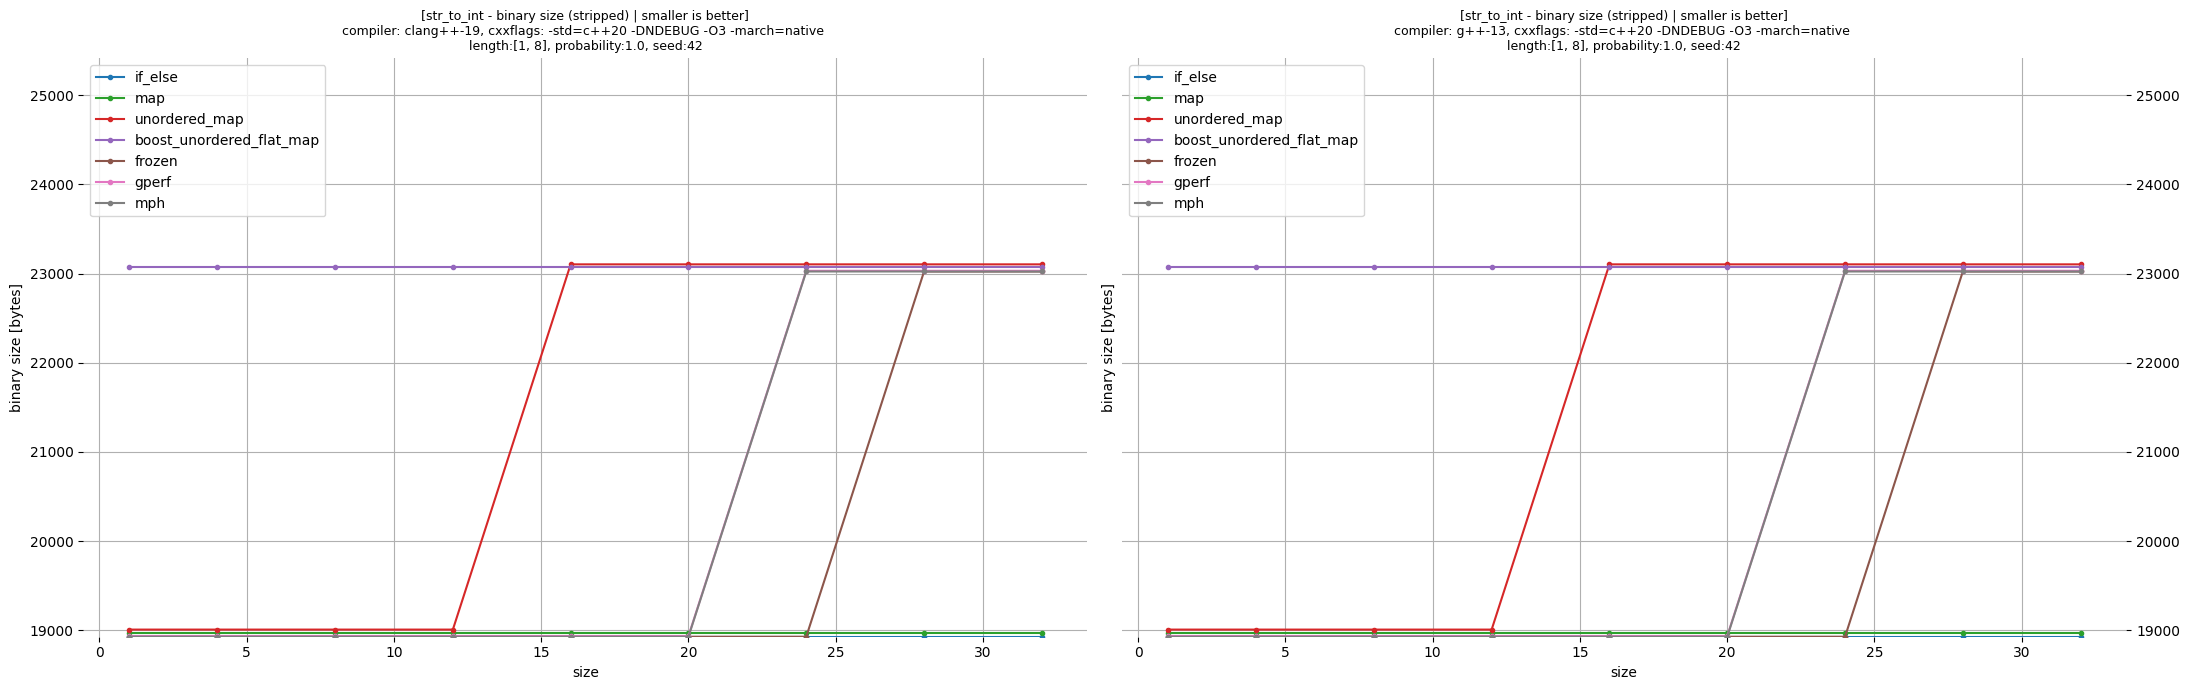

..............................................................................................................................

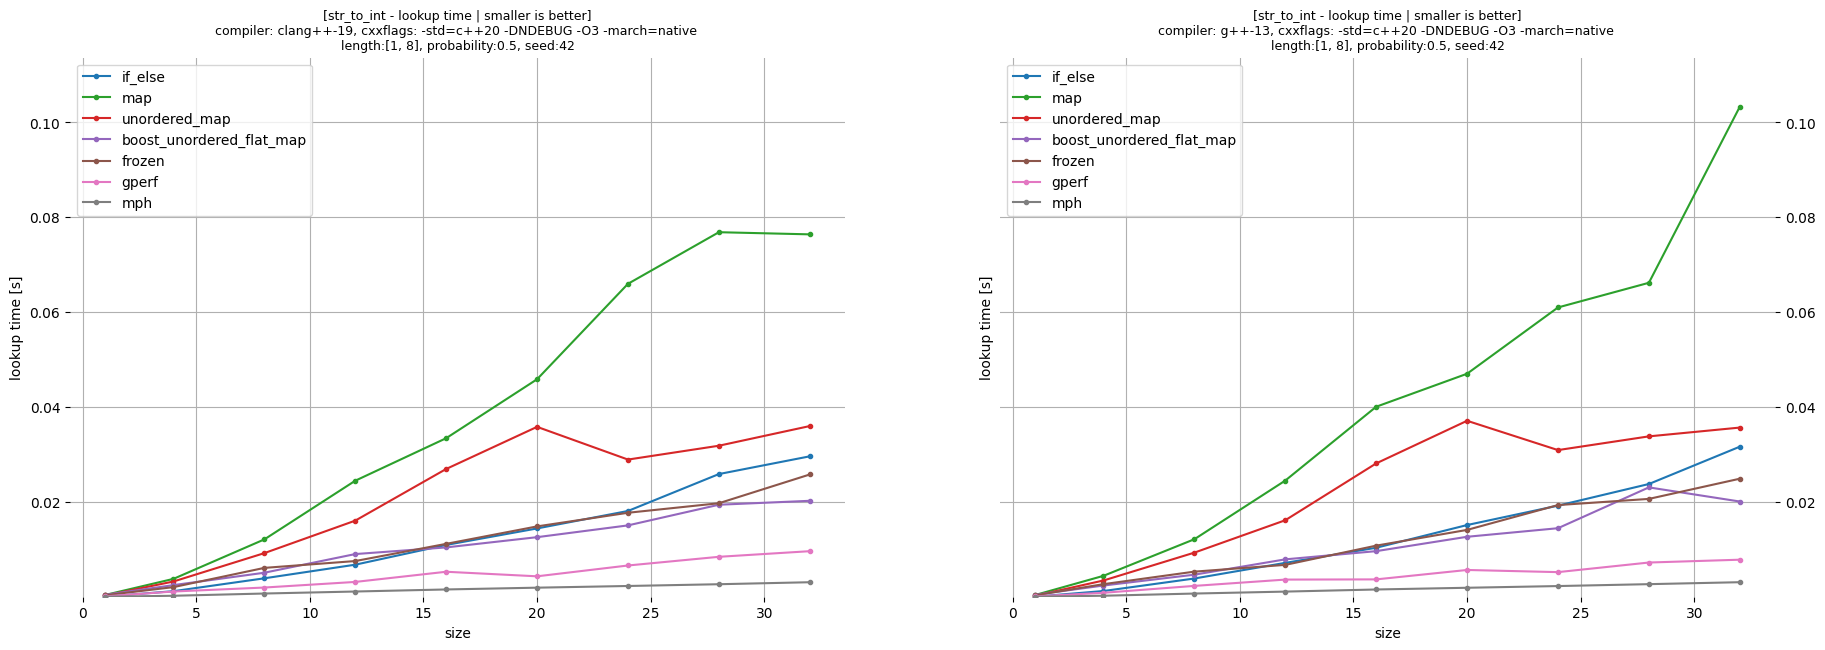

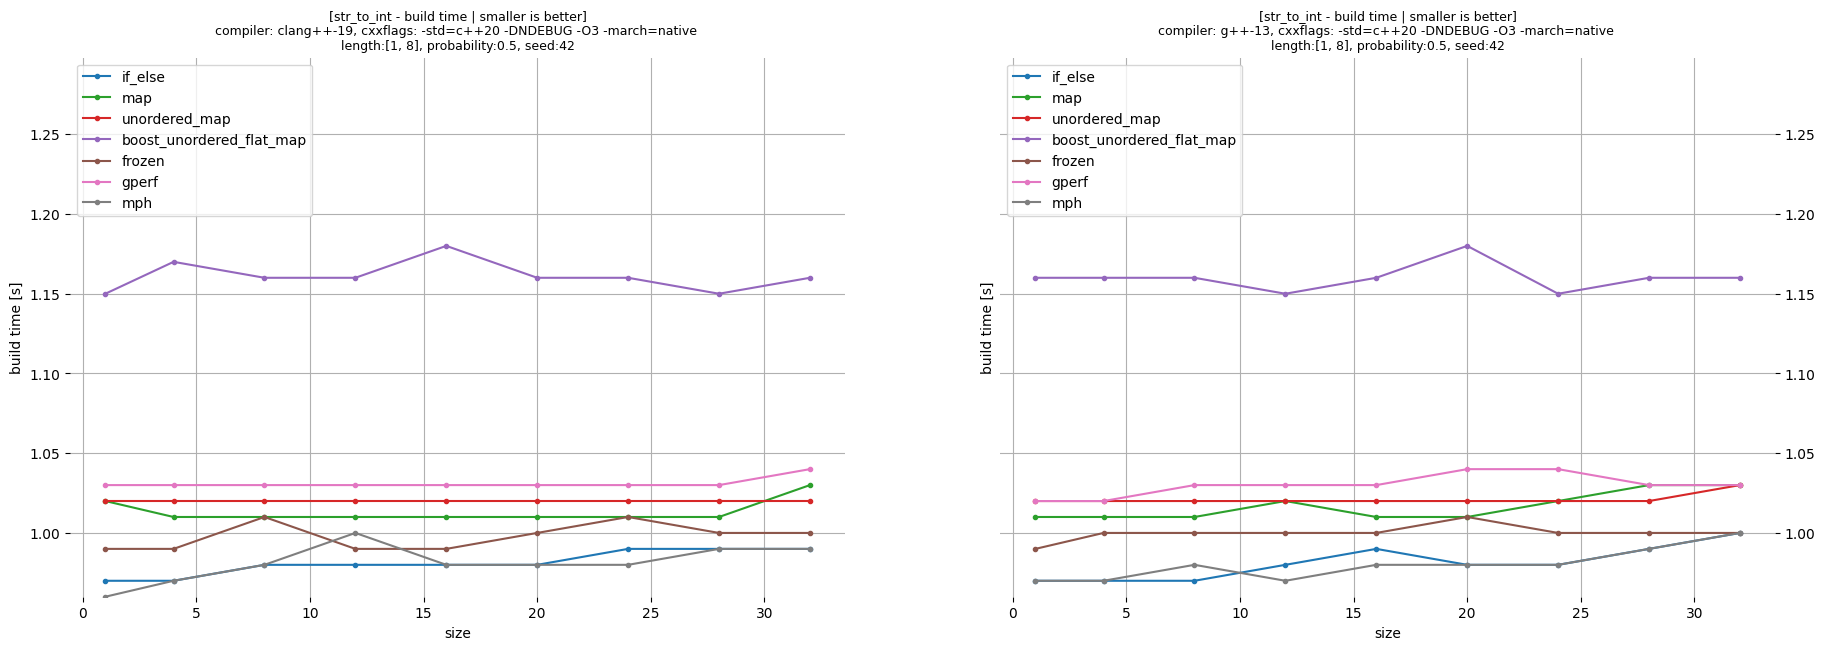

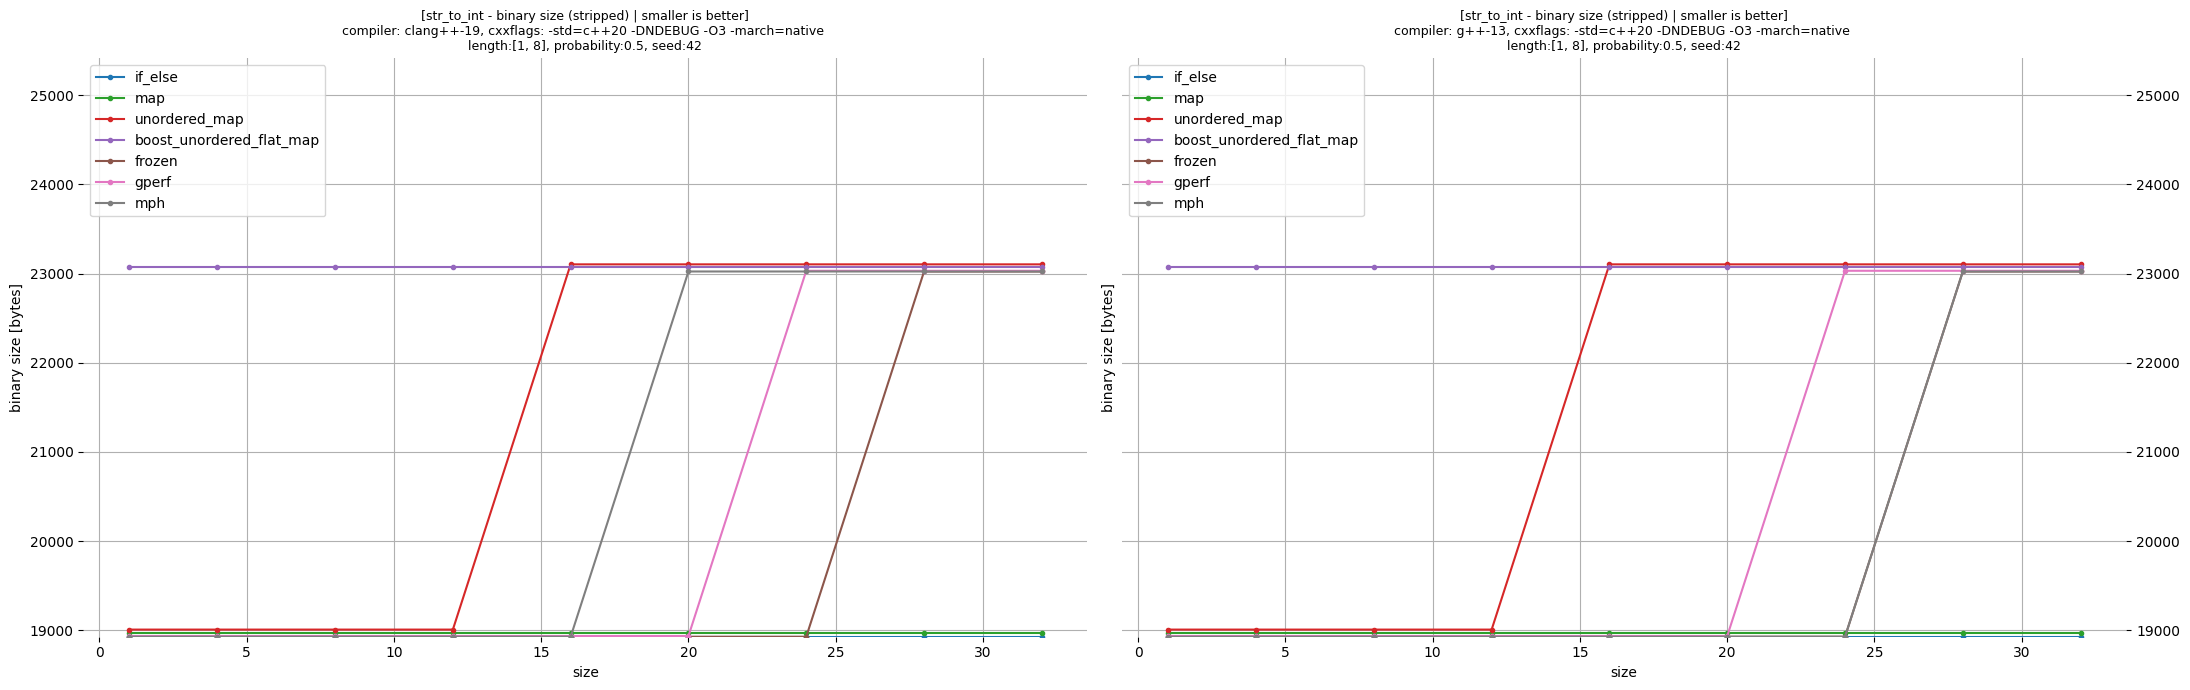

..............................................................................................................................

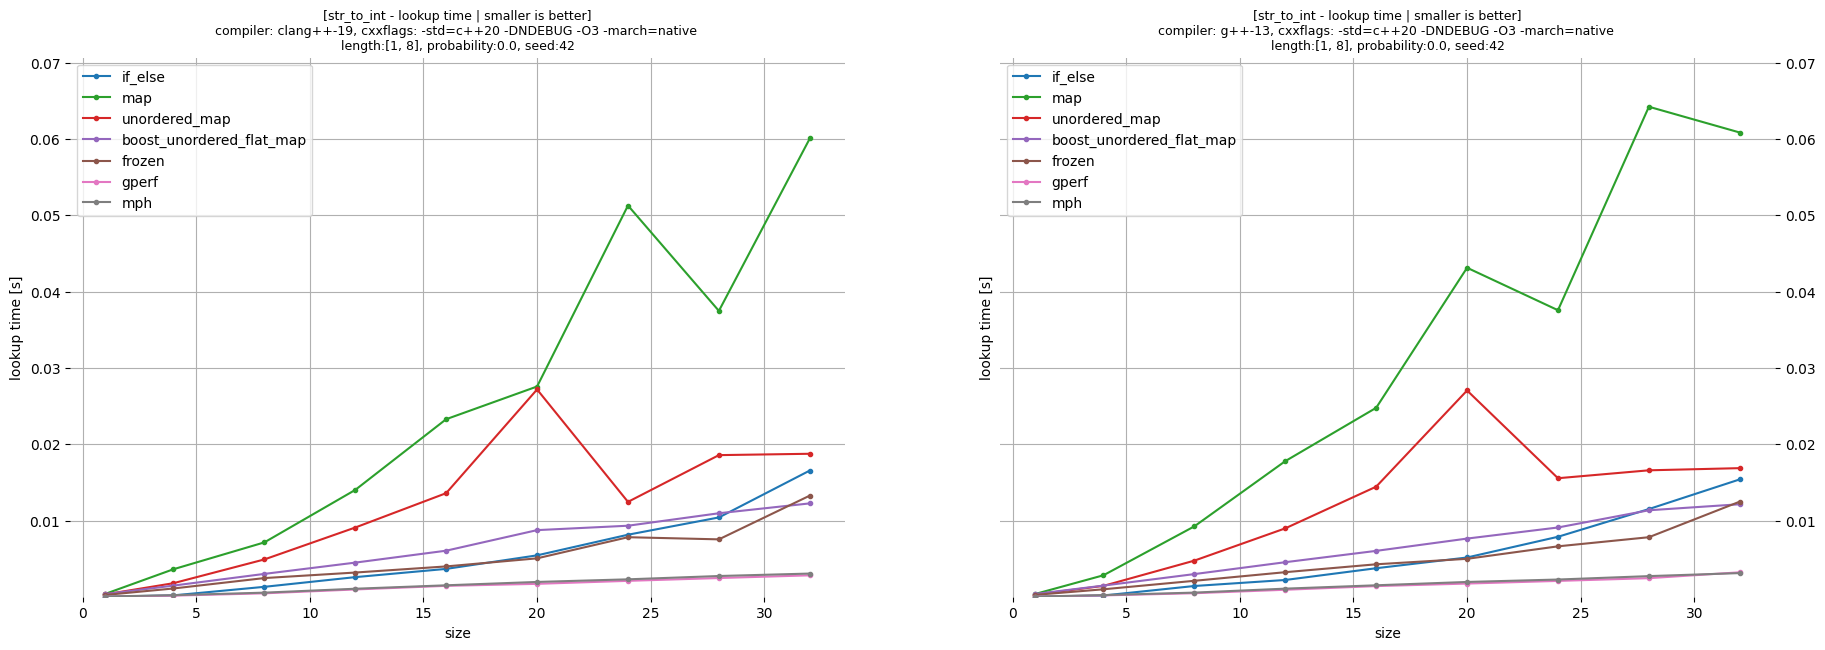

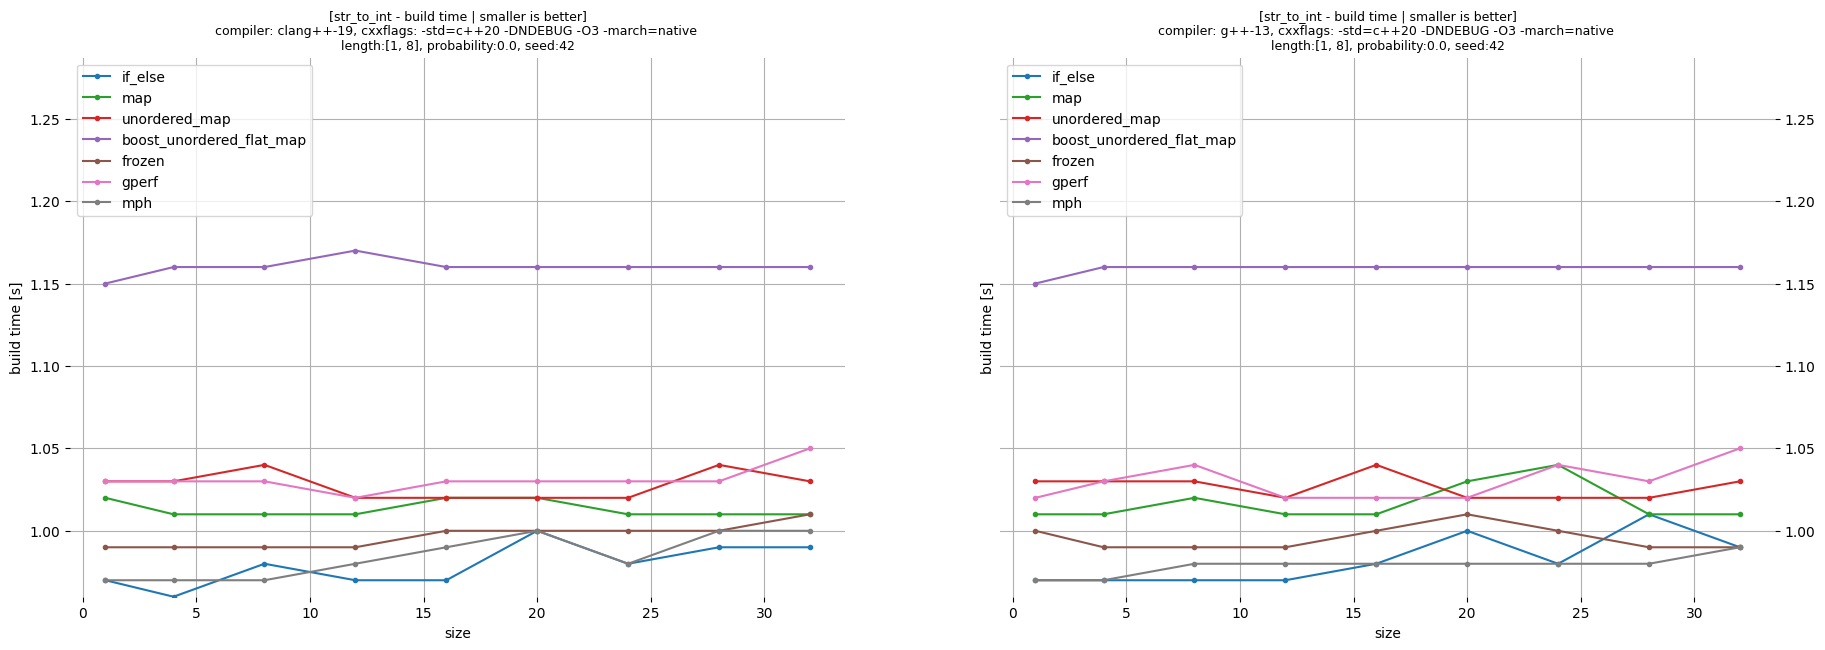

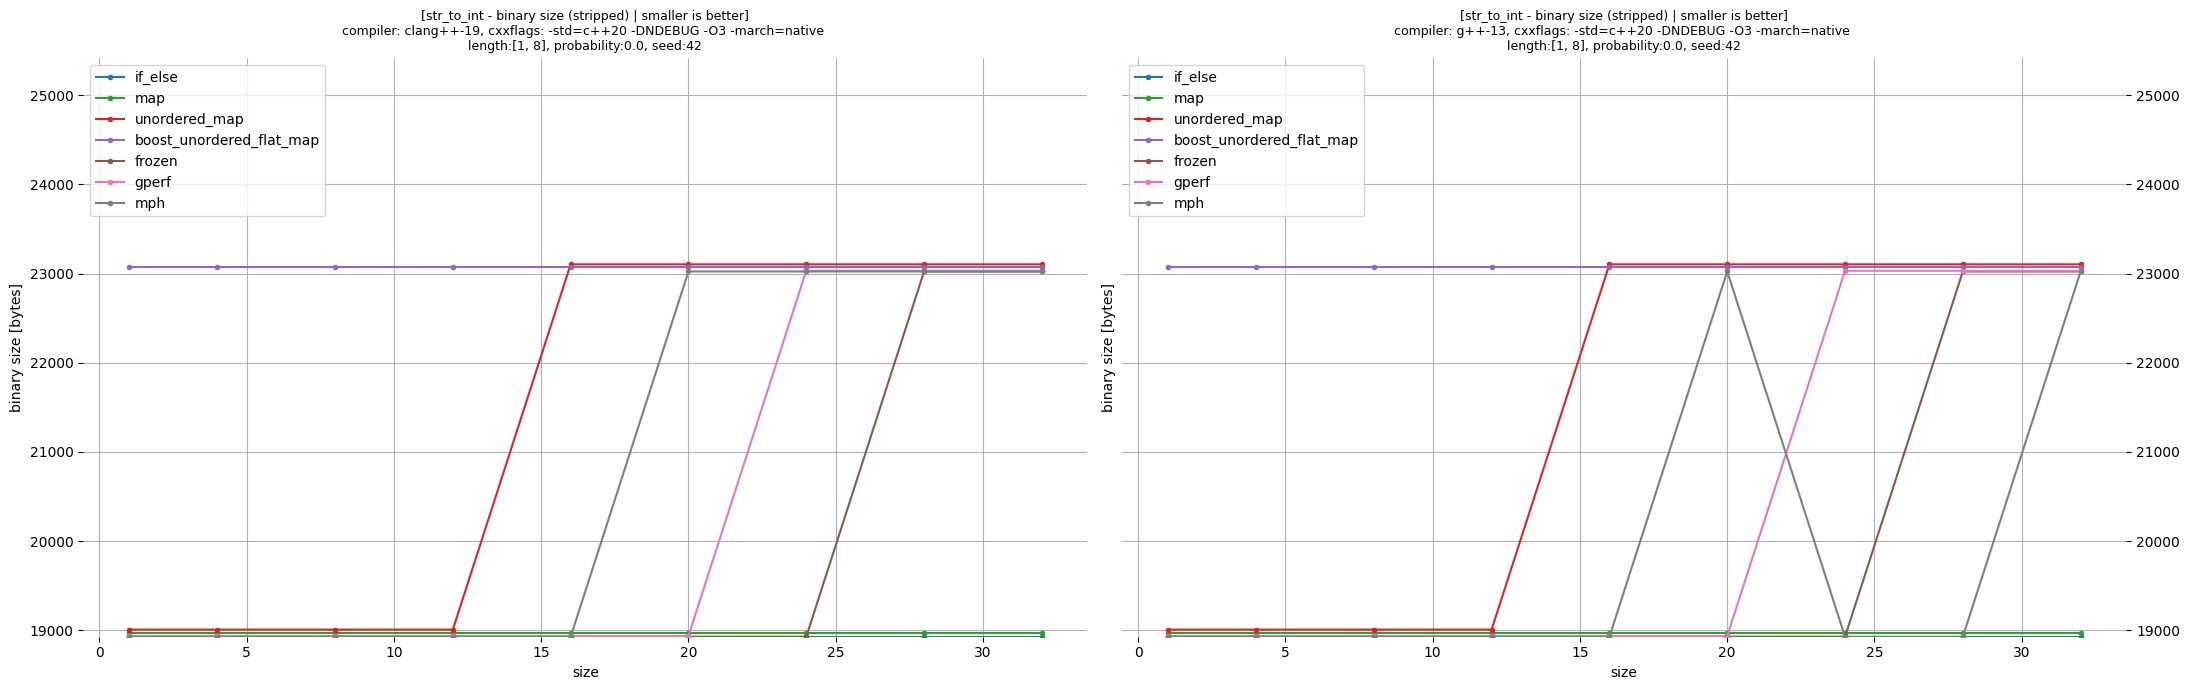

................................................................................

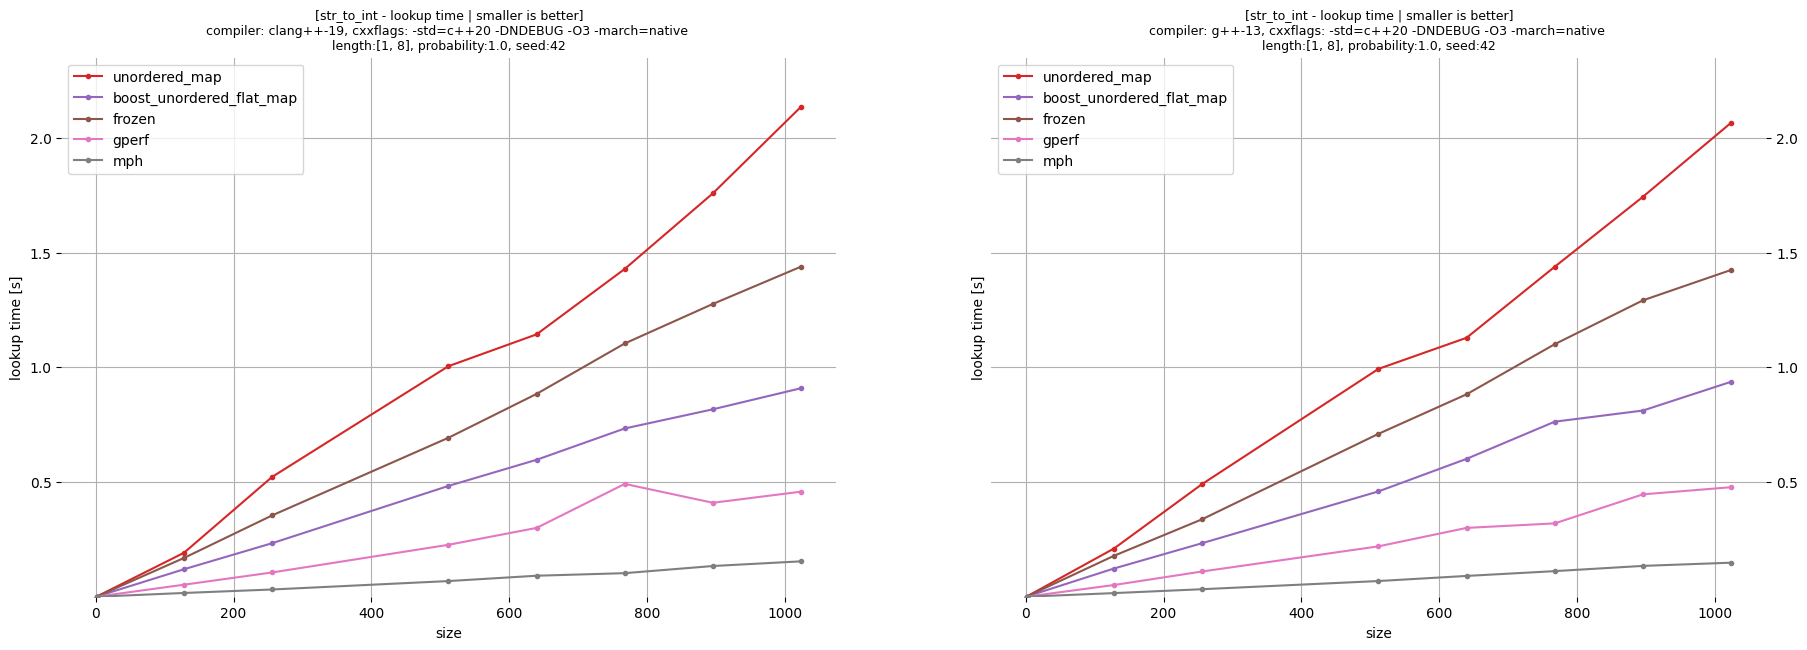

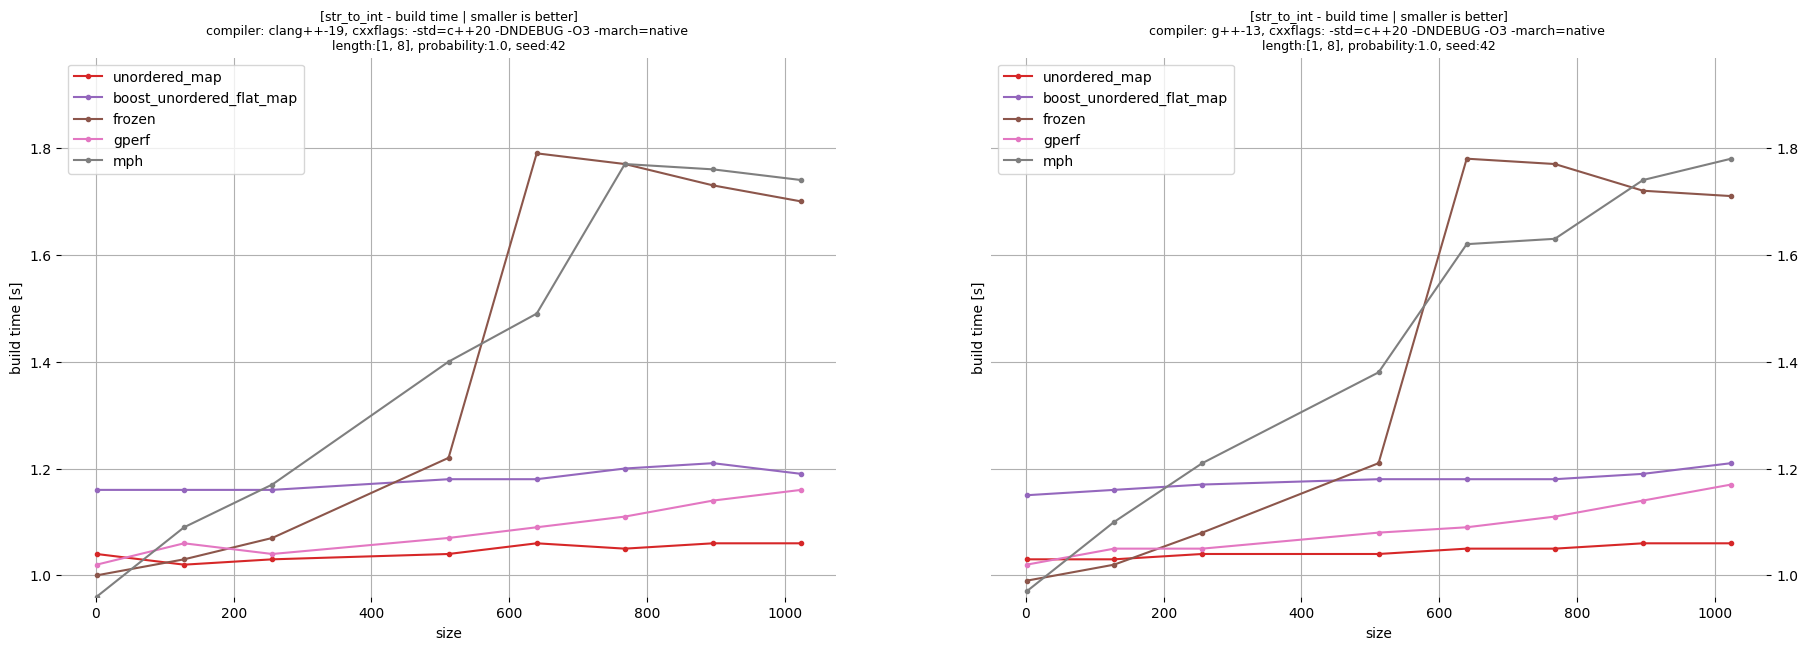

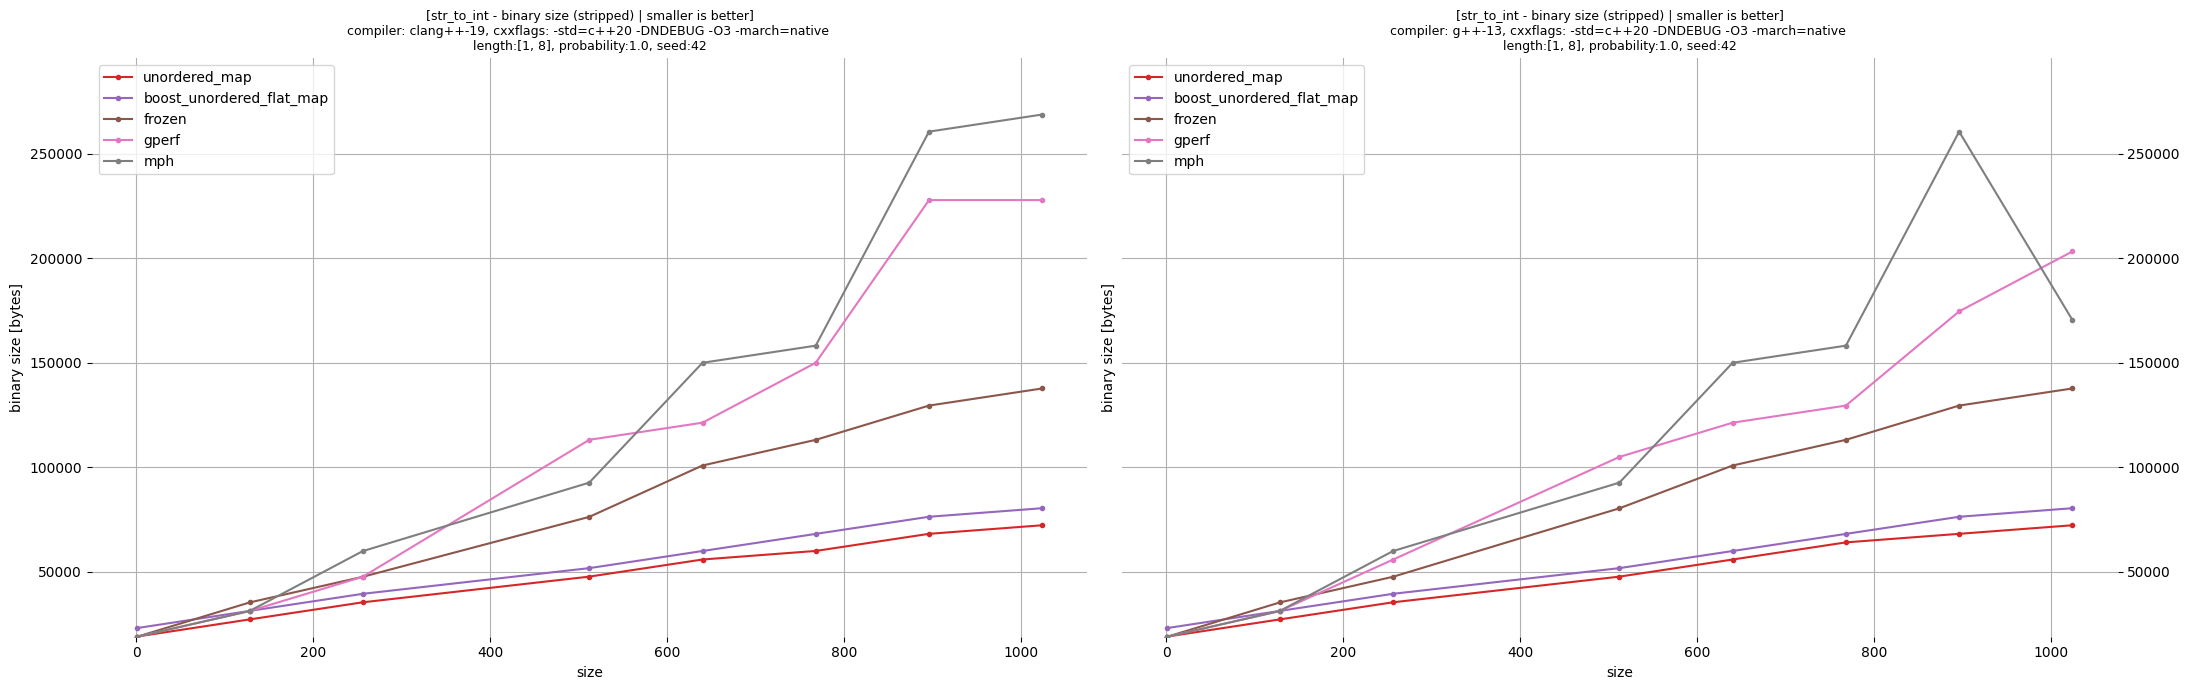

................................................................................

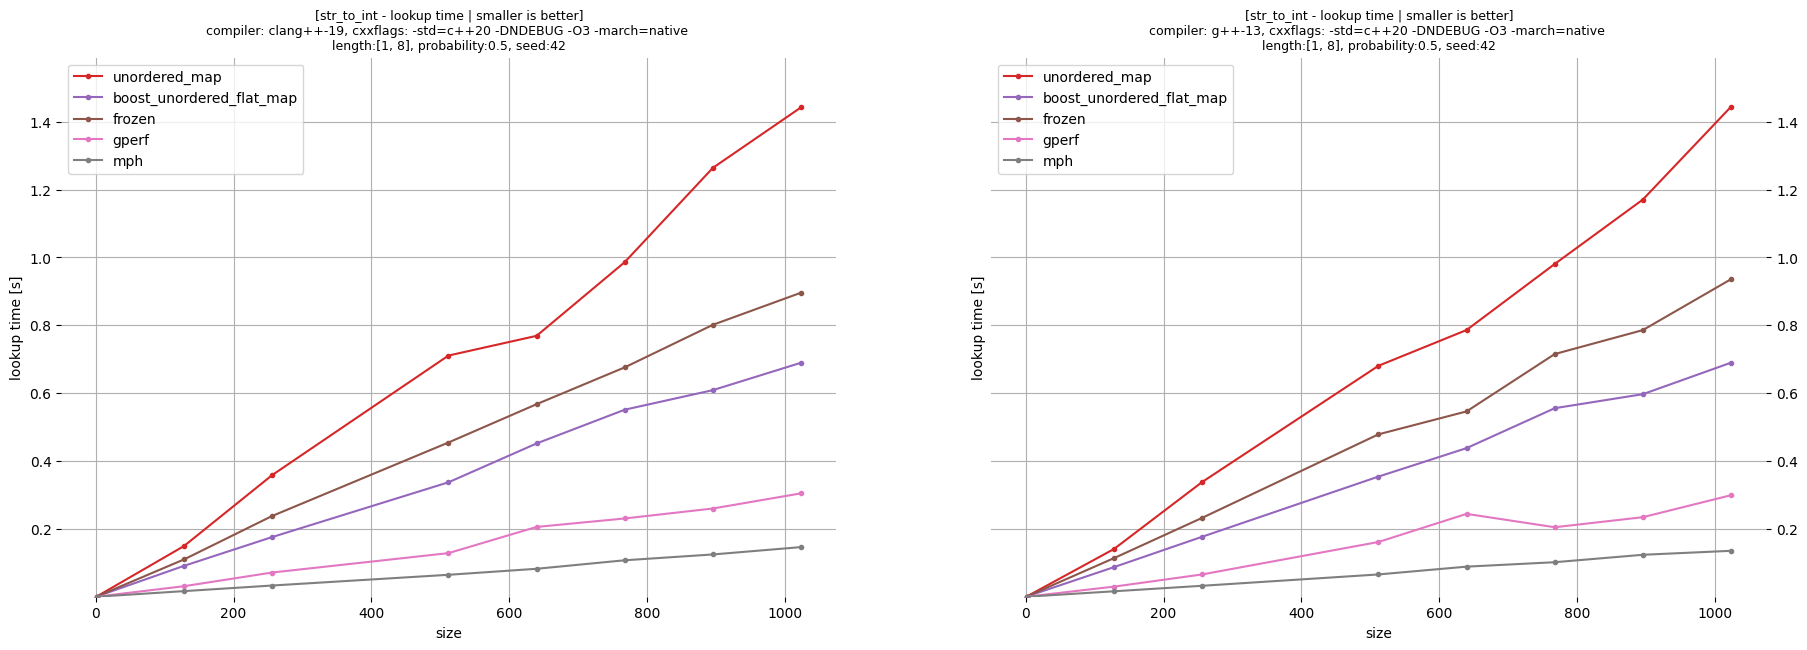

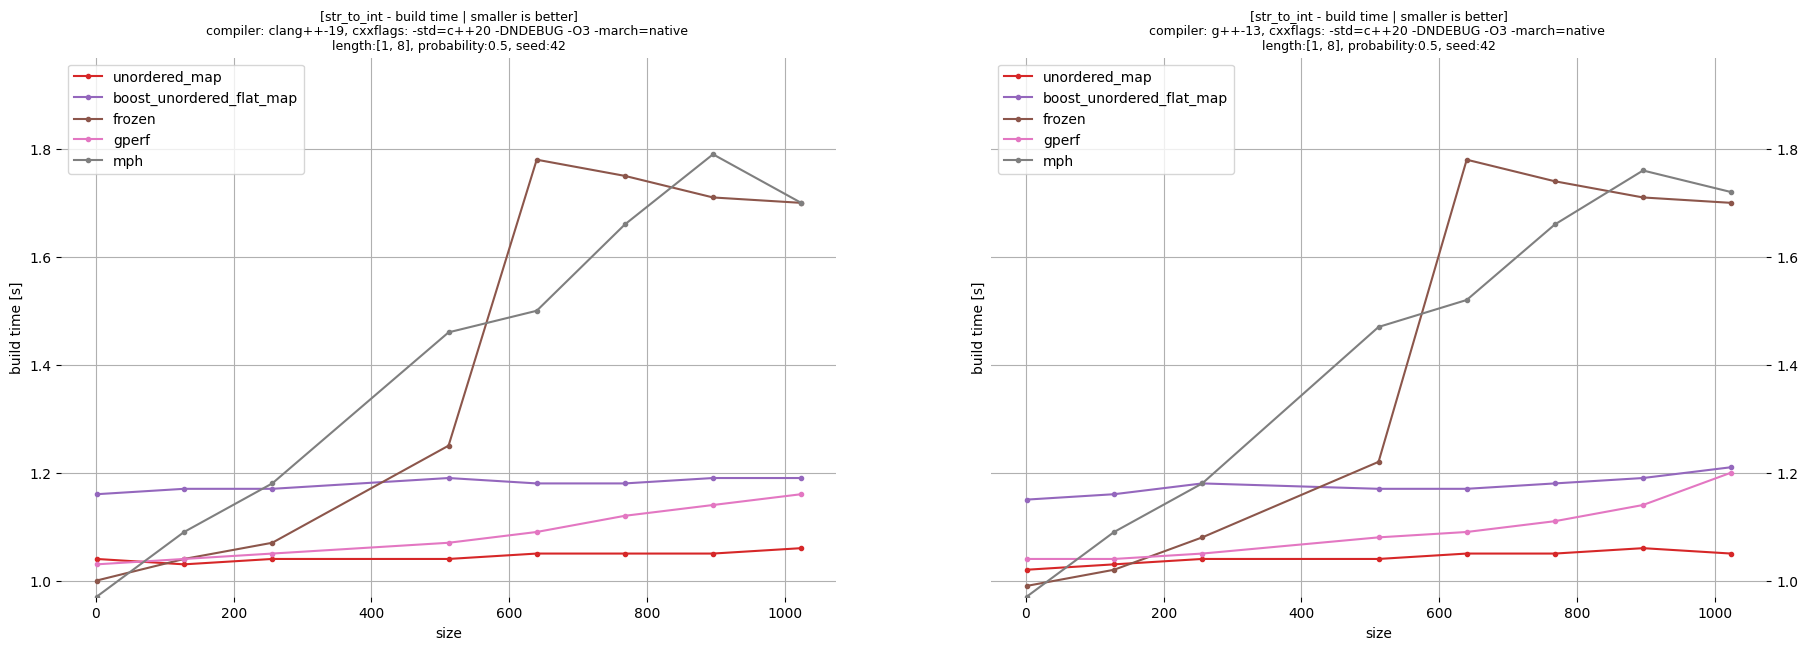

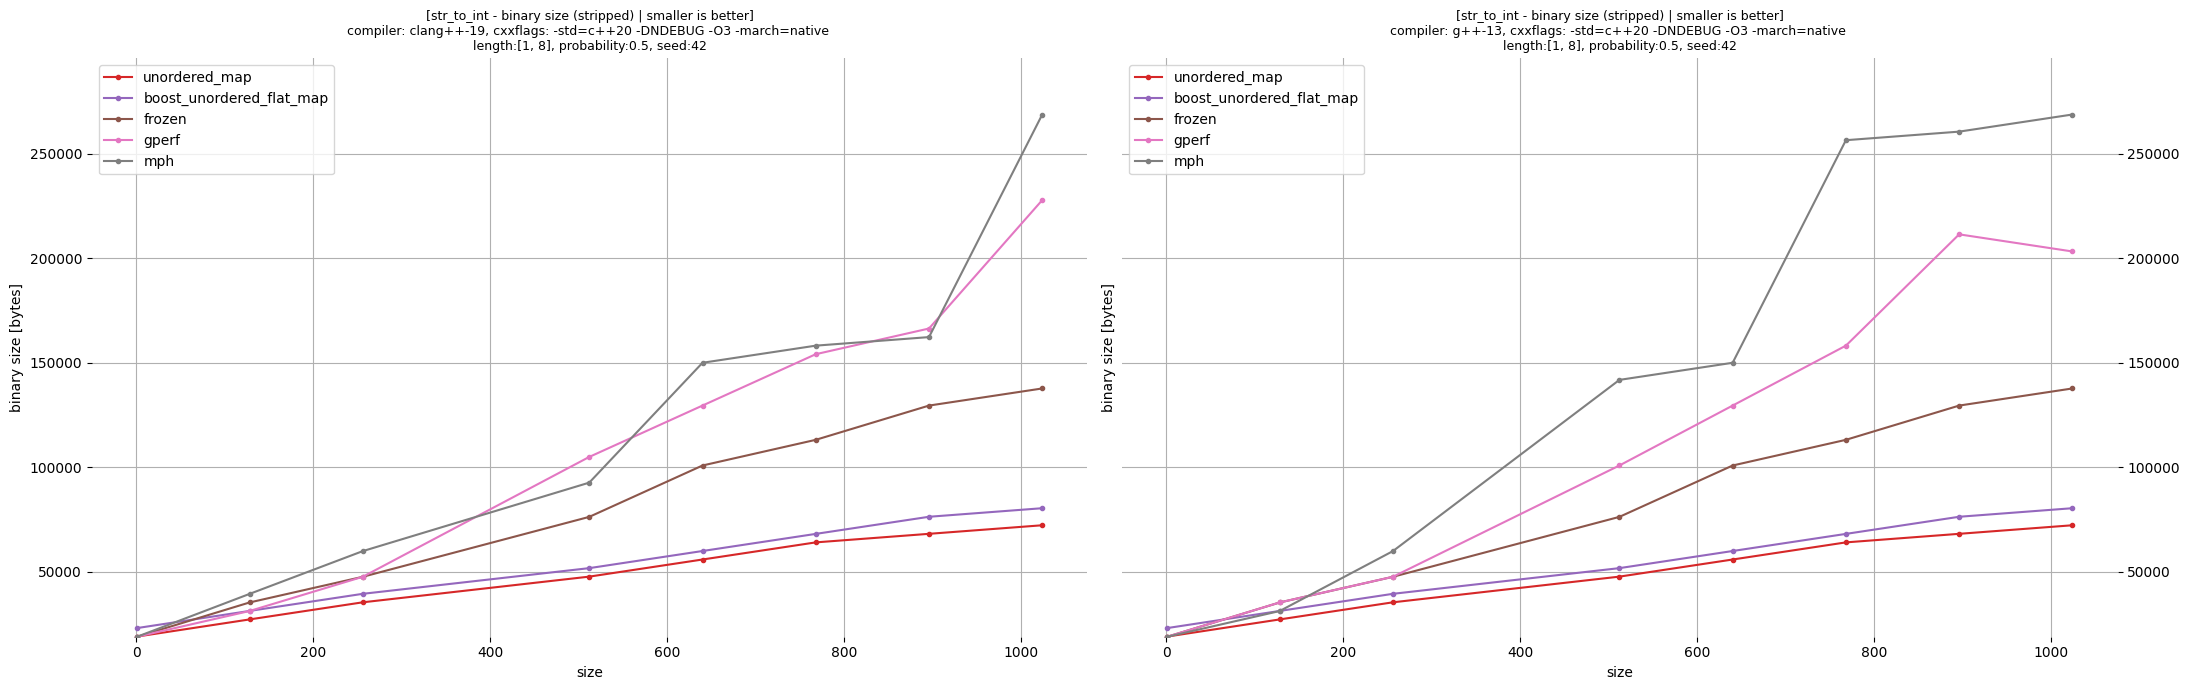

................................................................................

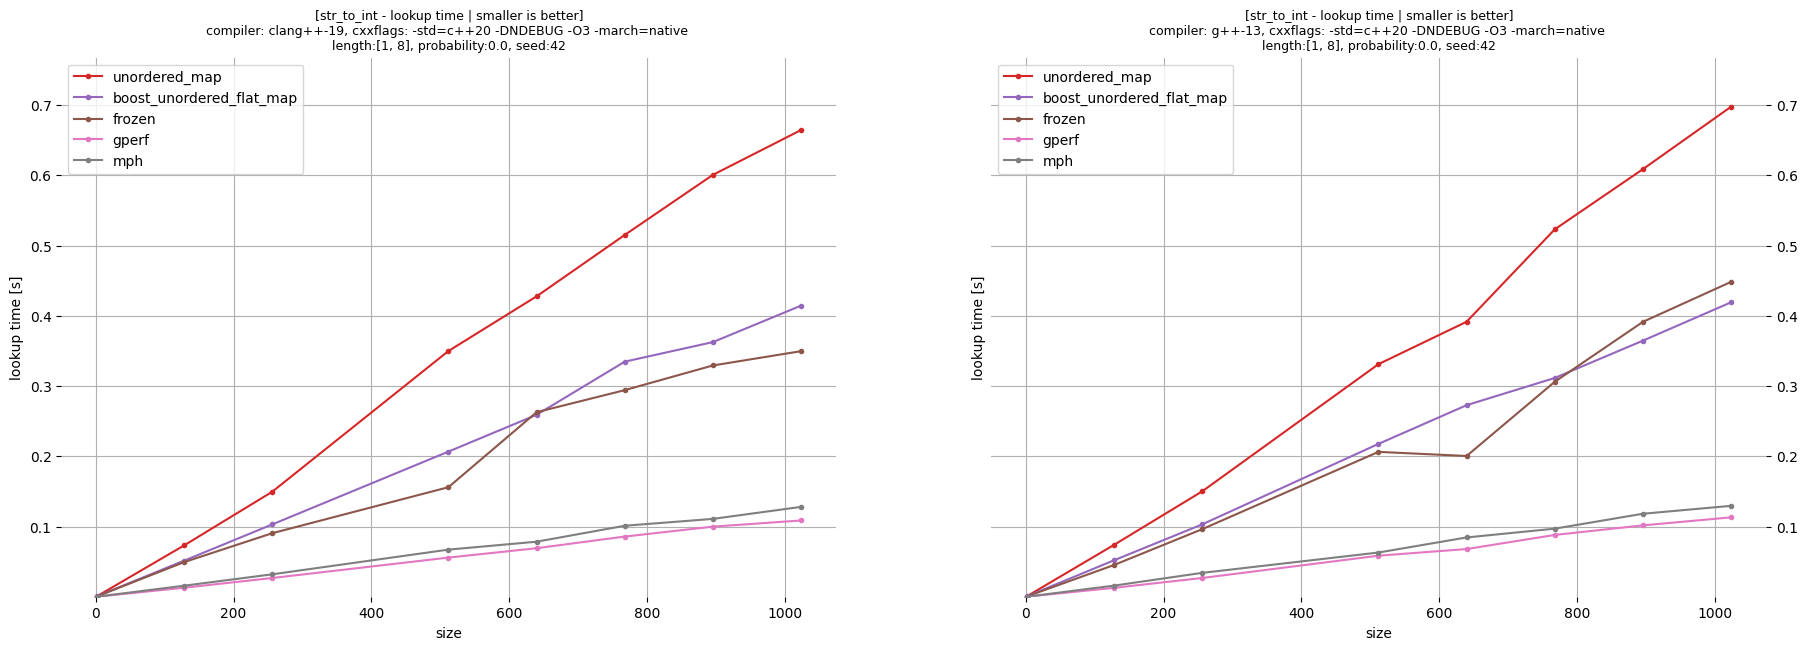

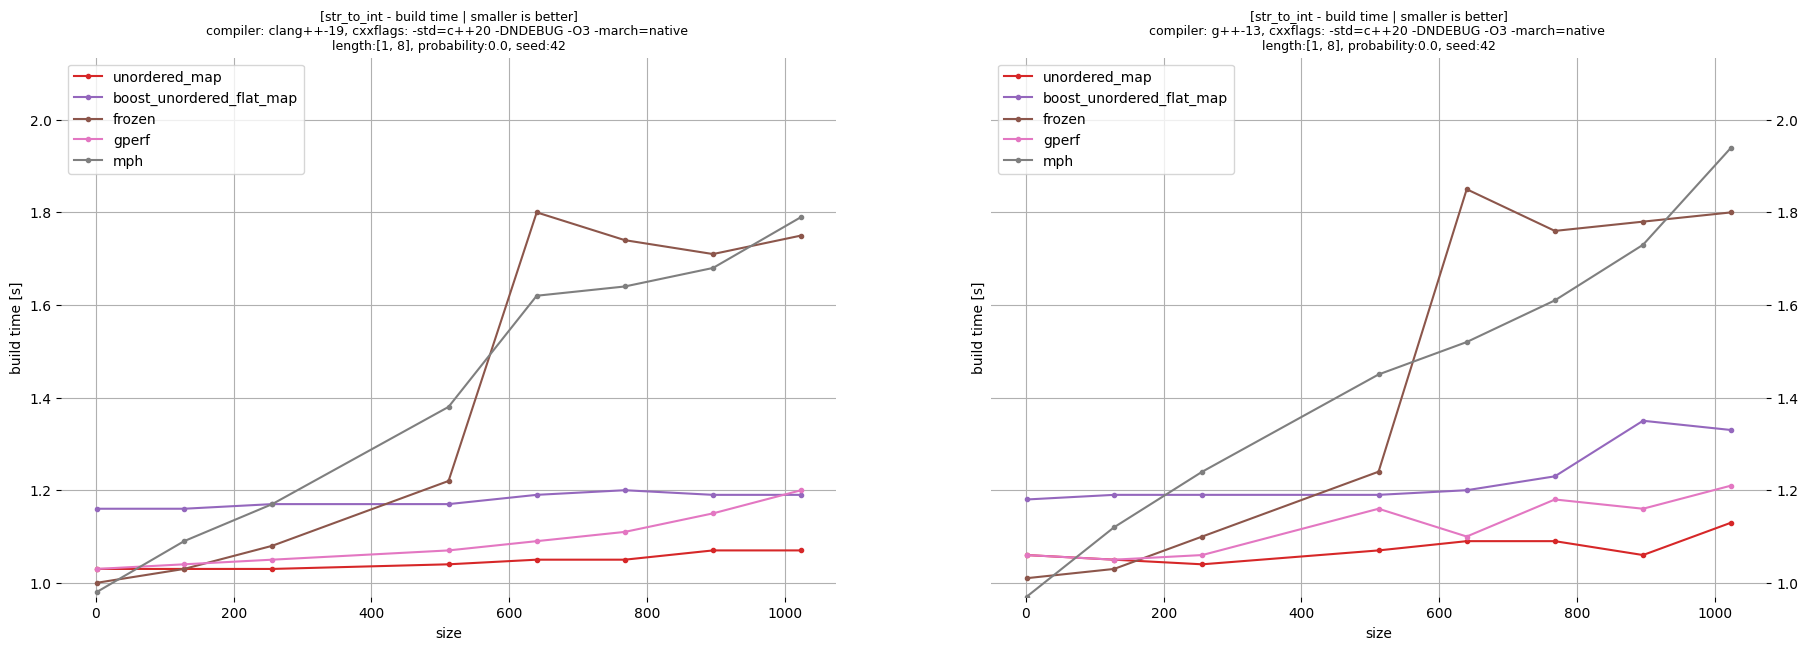

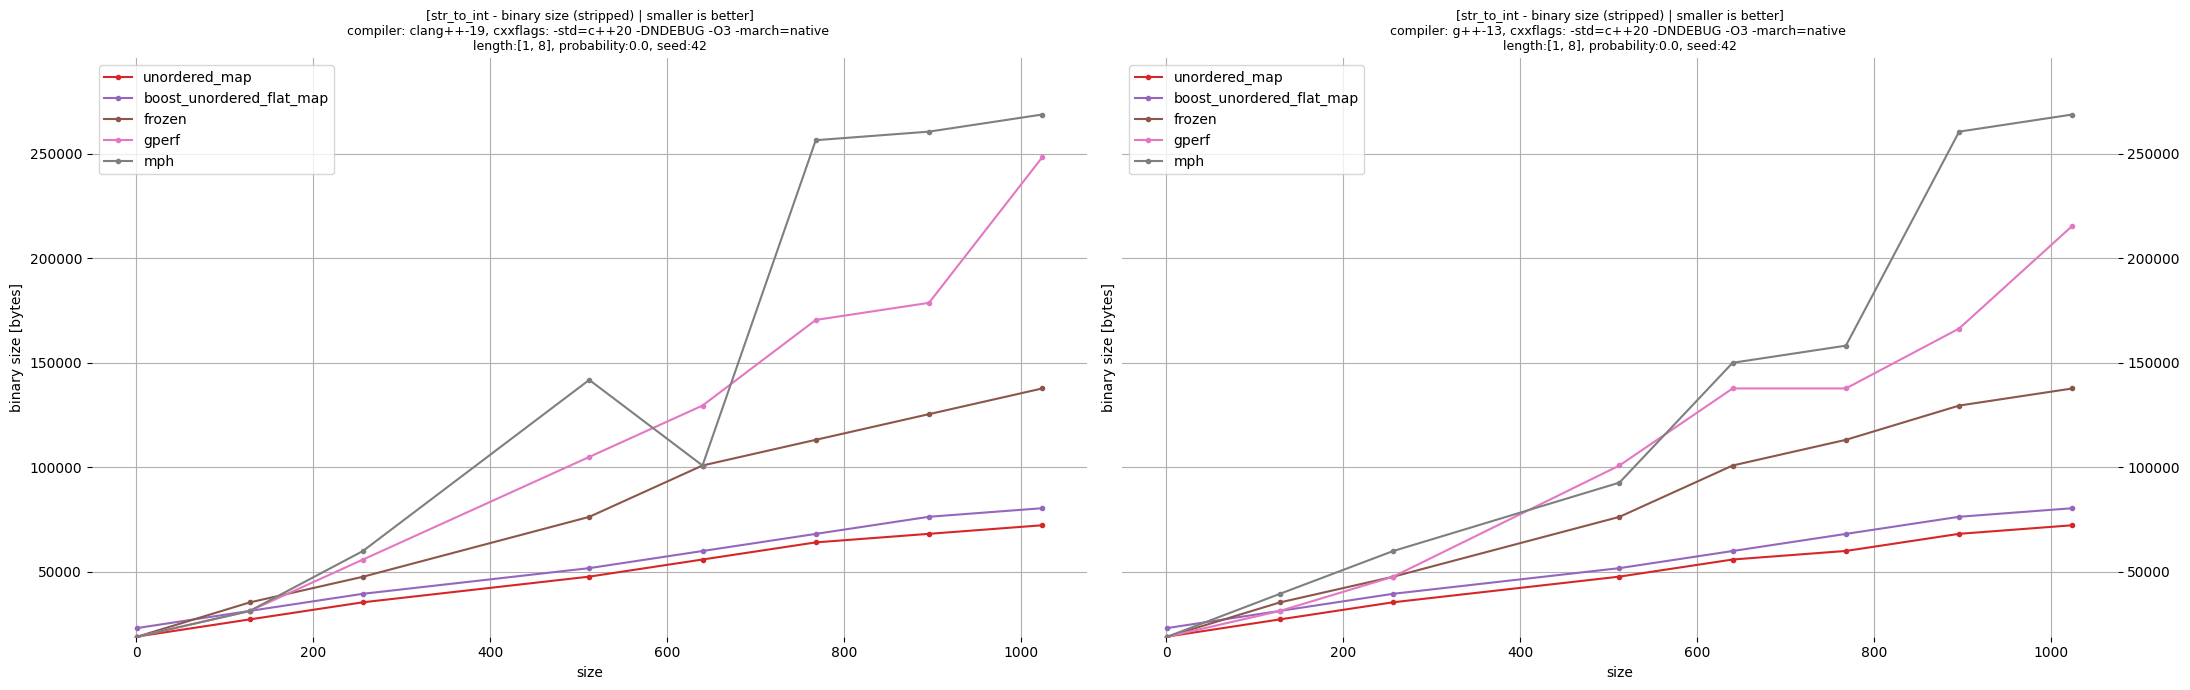

..........................................................................................

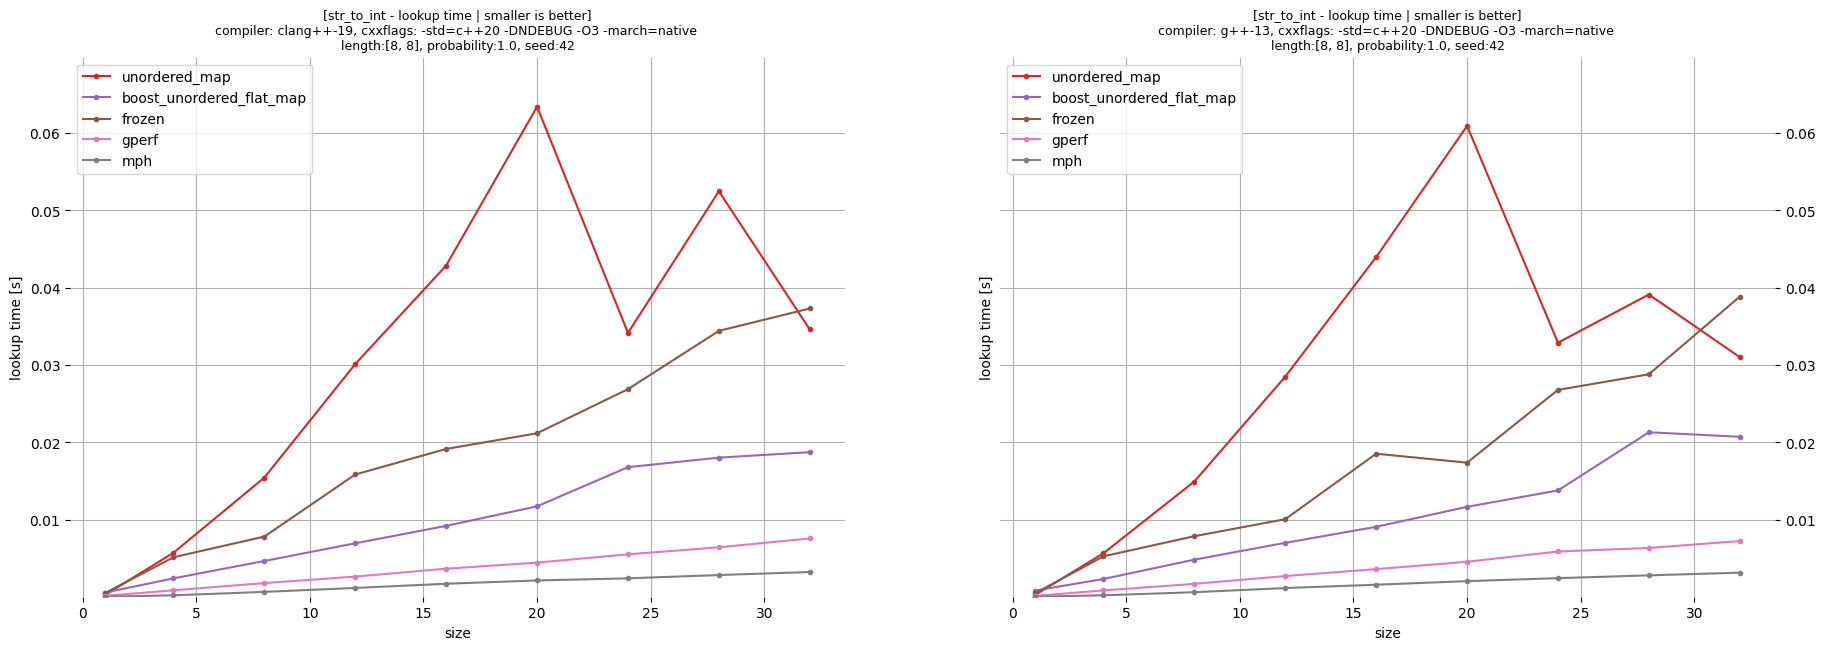

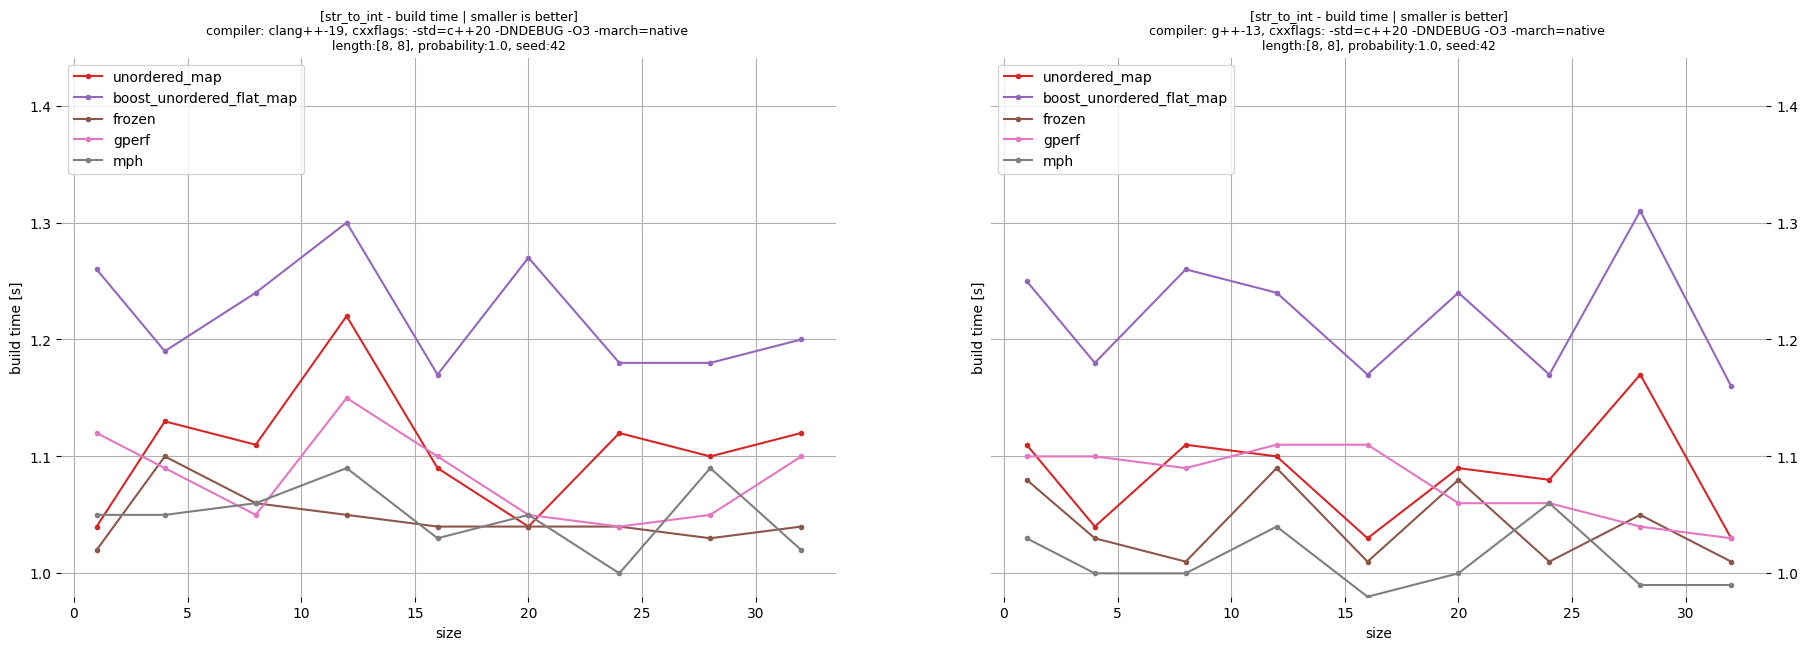

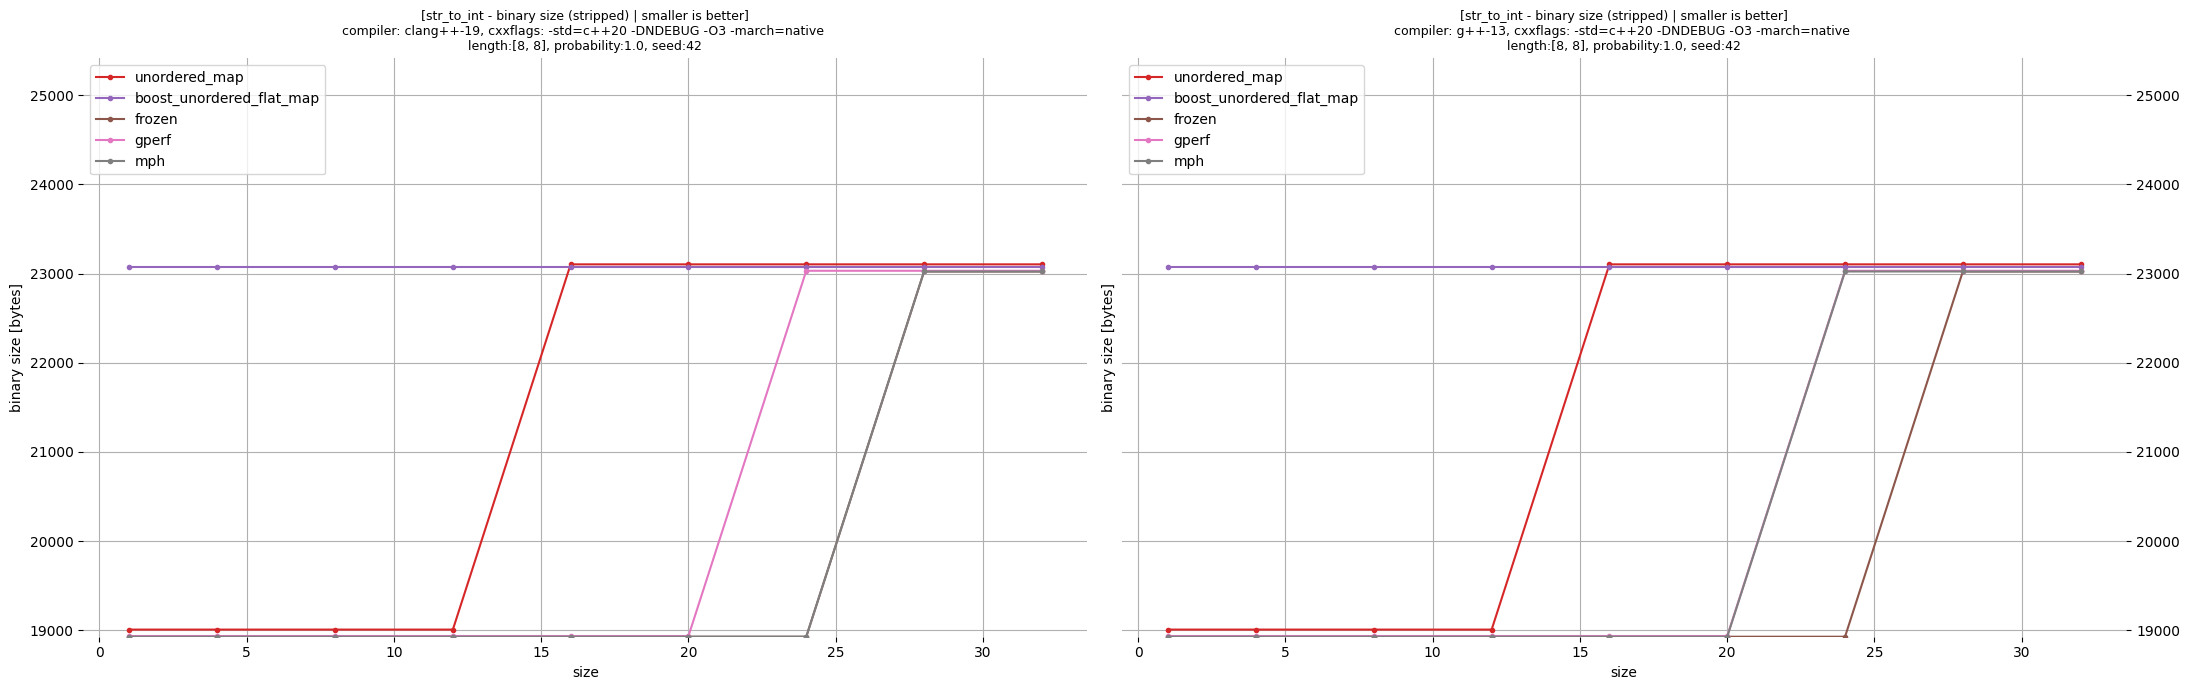

..........................................................................................

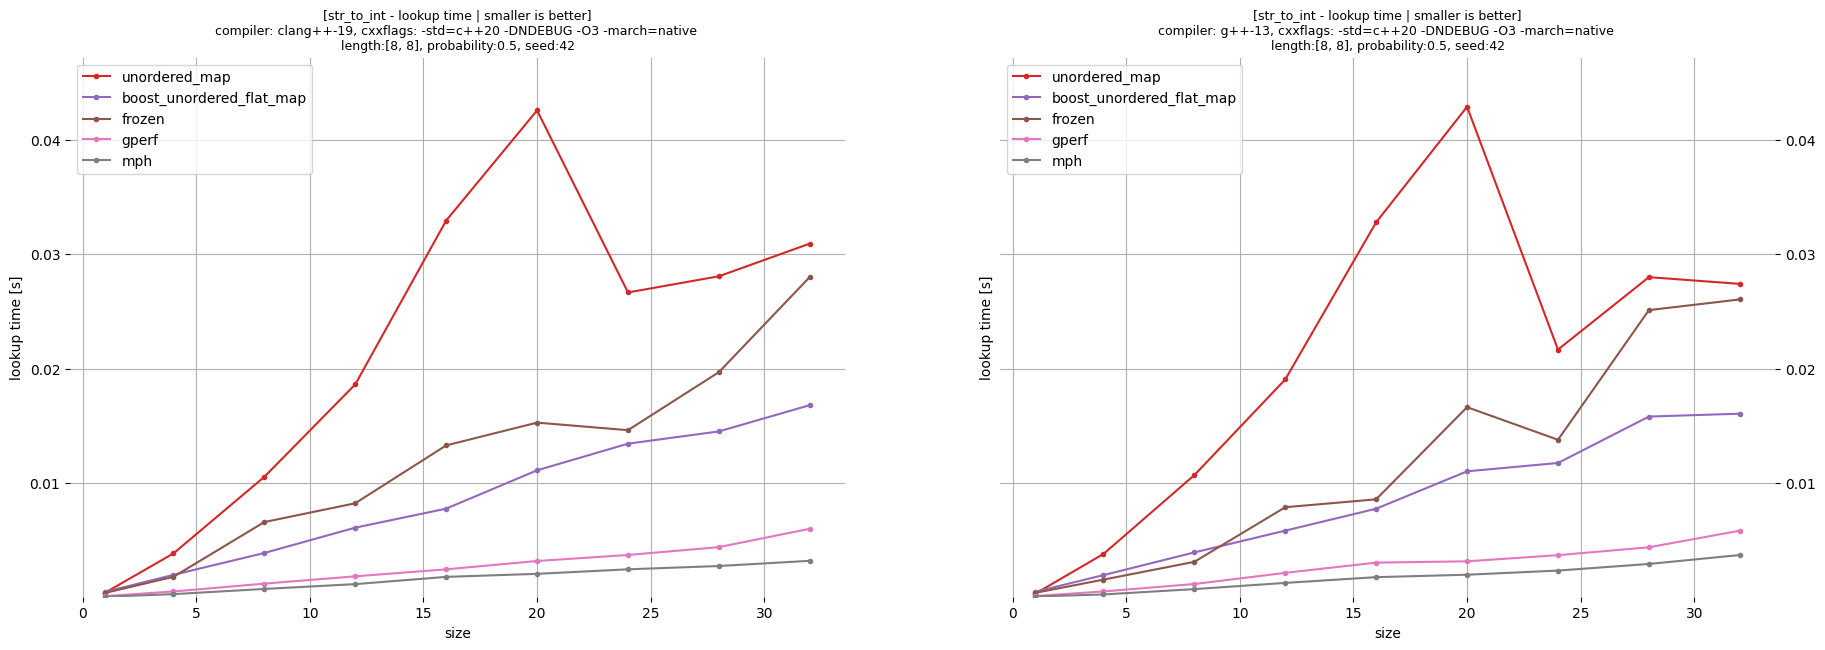

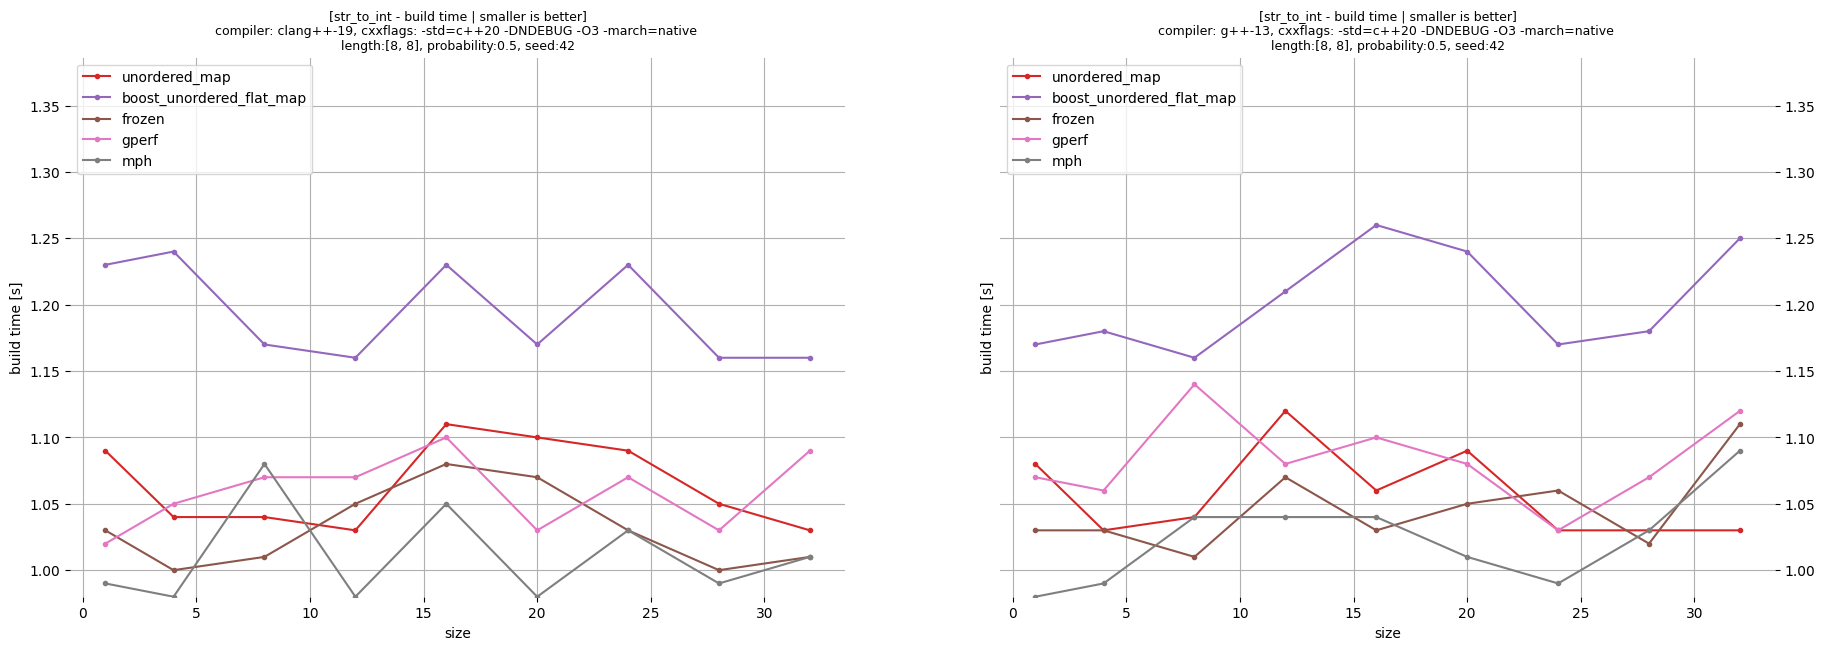

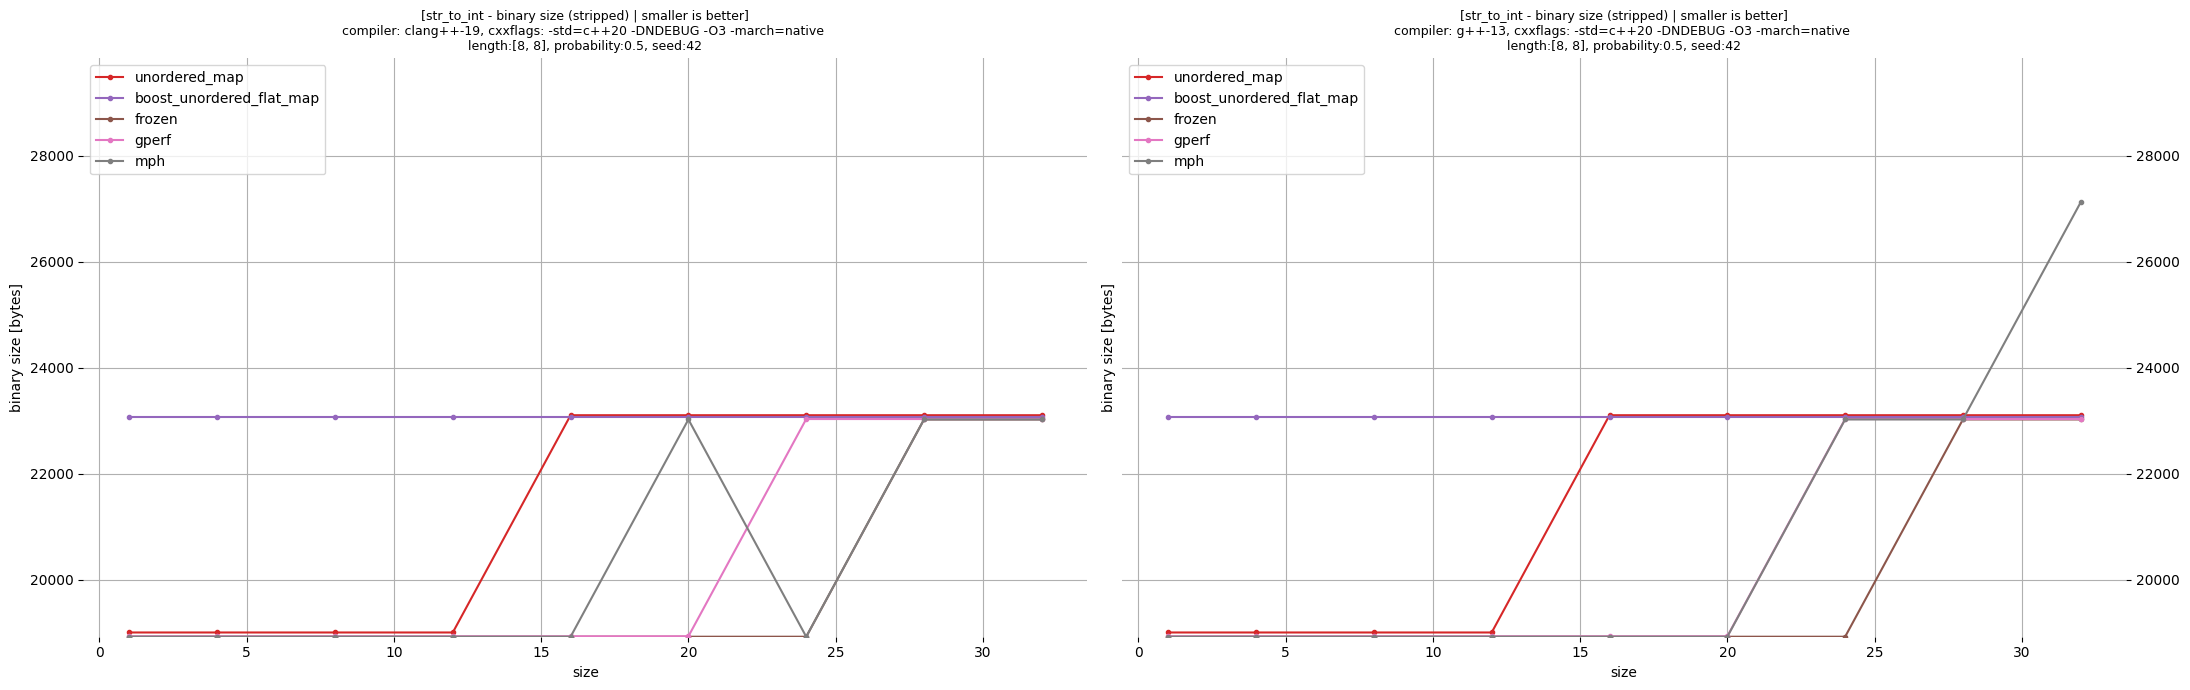

..........................................................................................

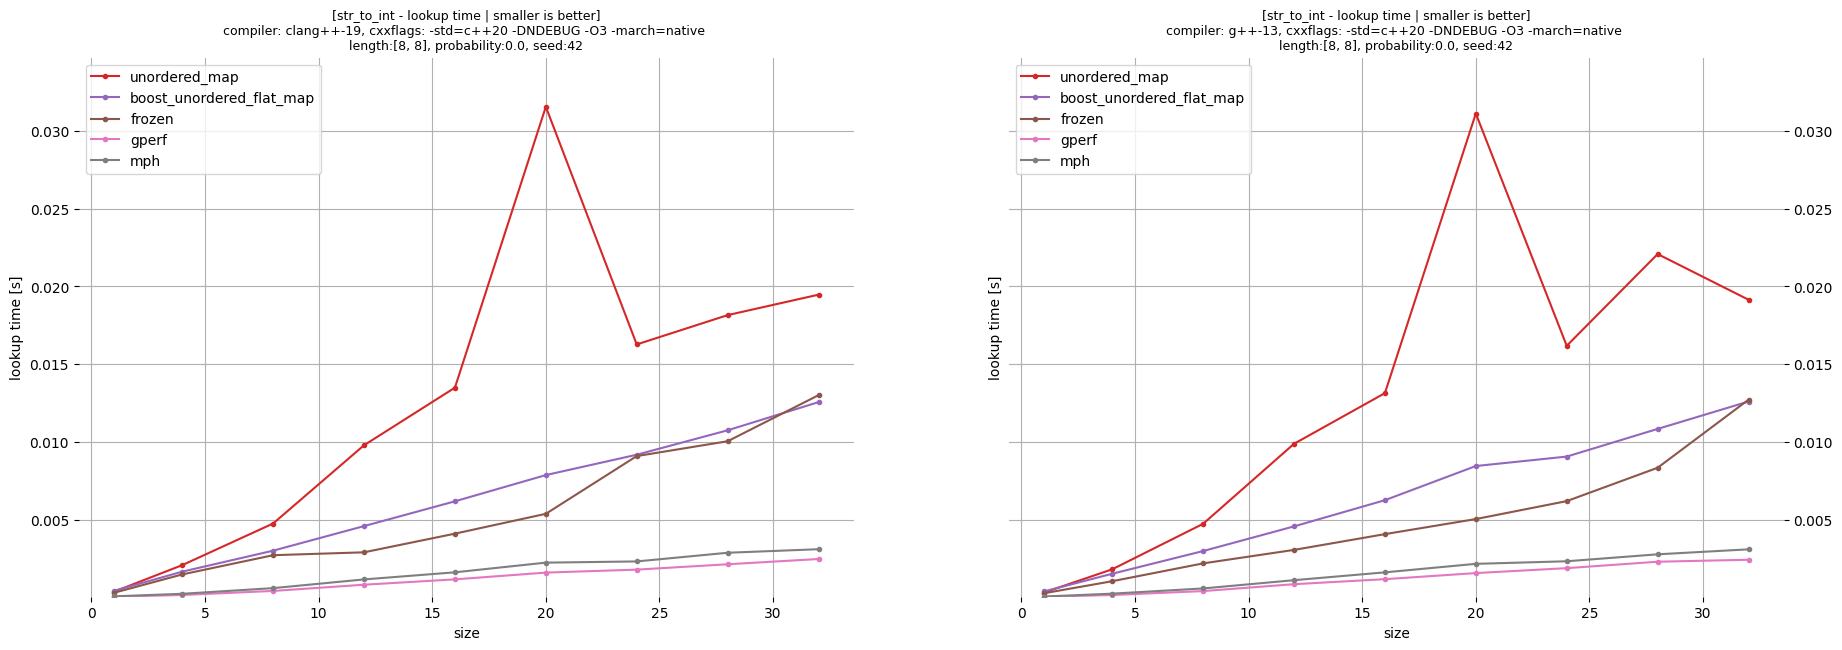

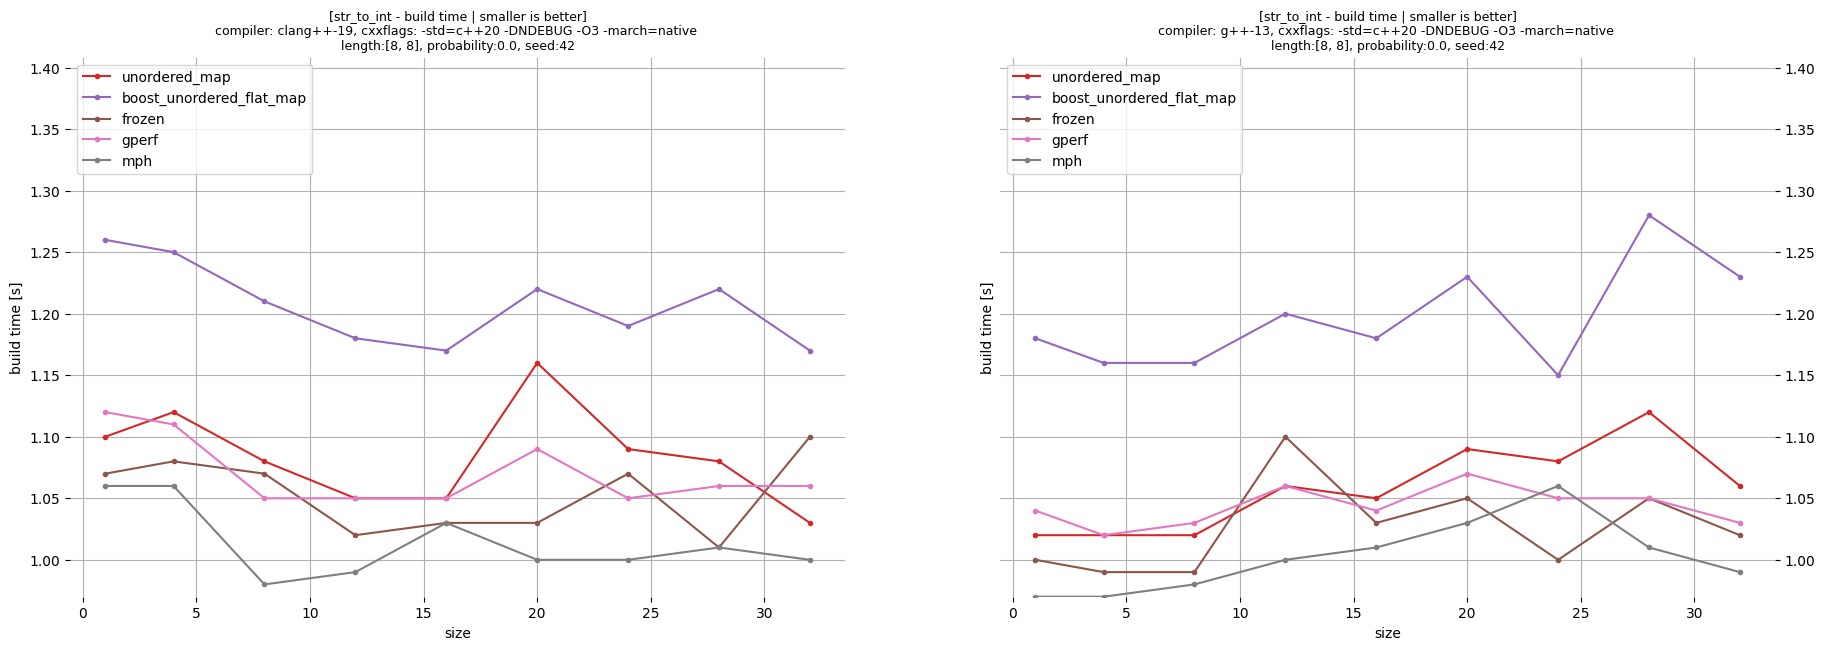

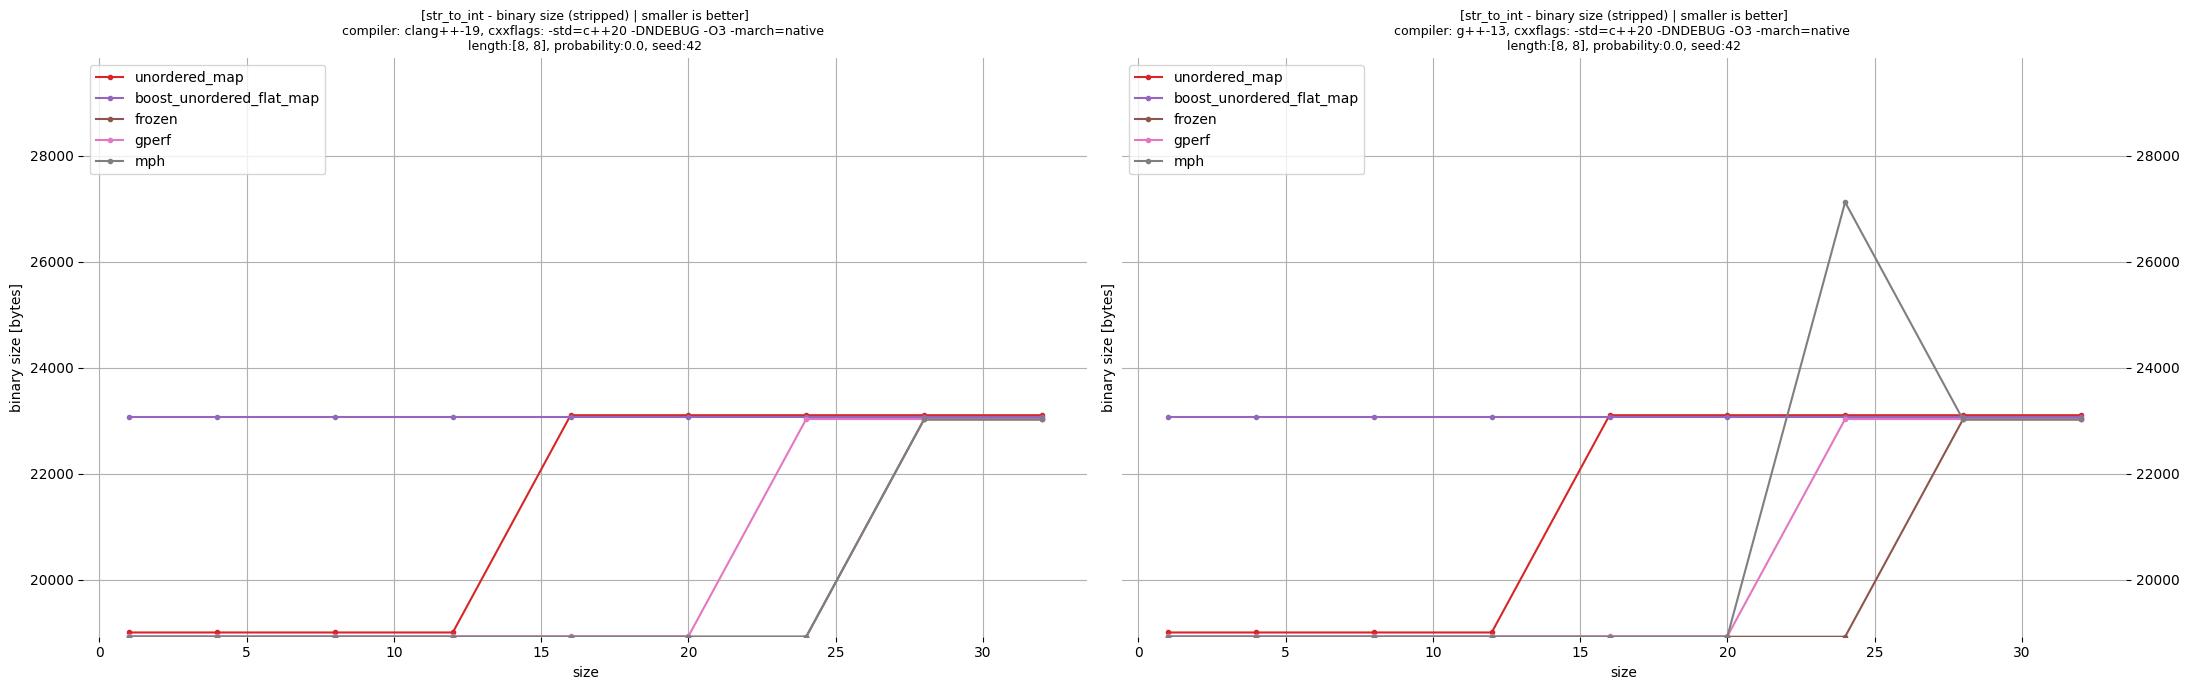

................................................................................

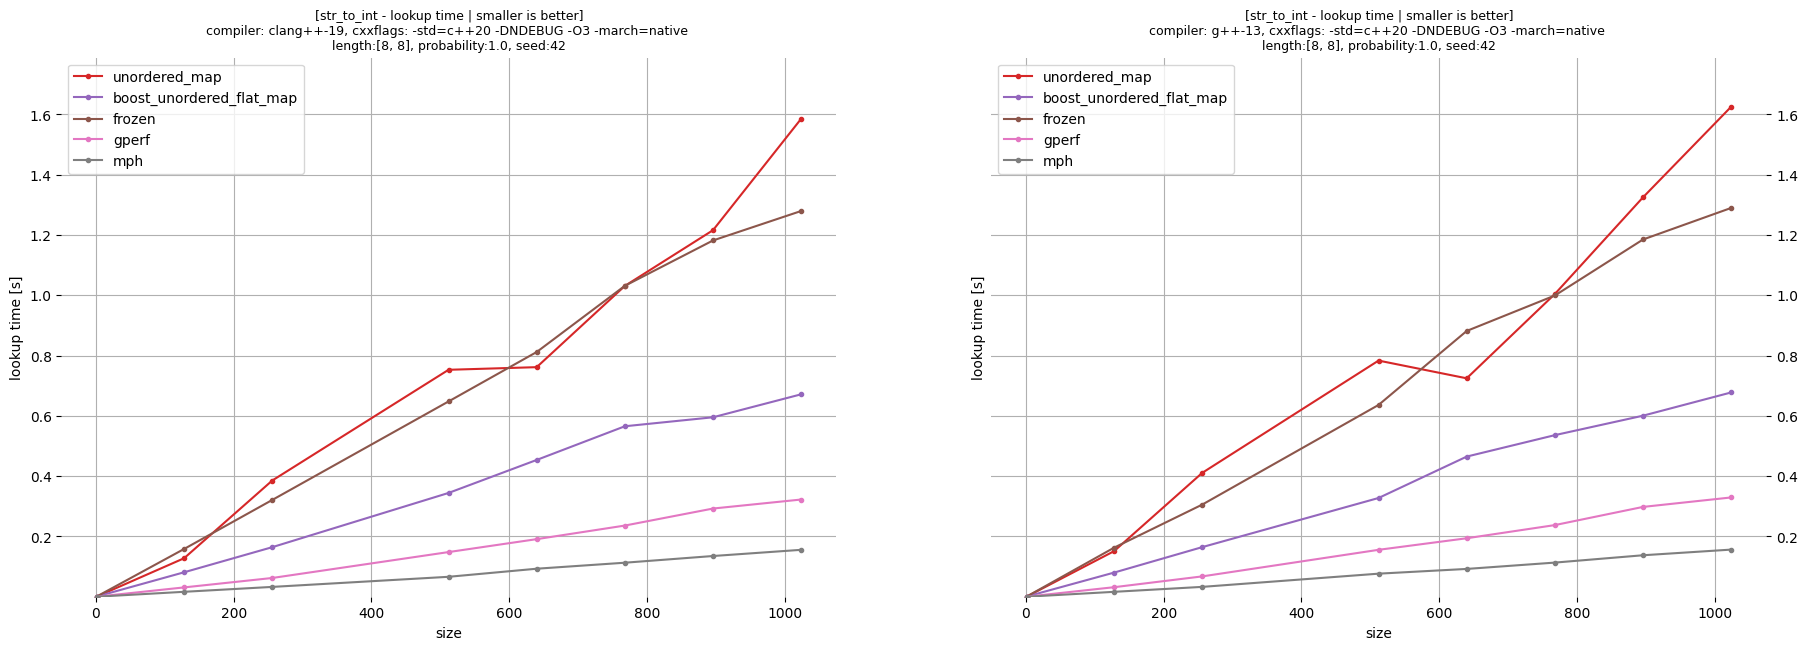

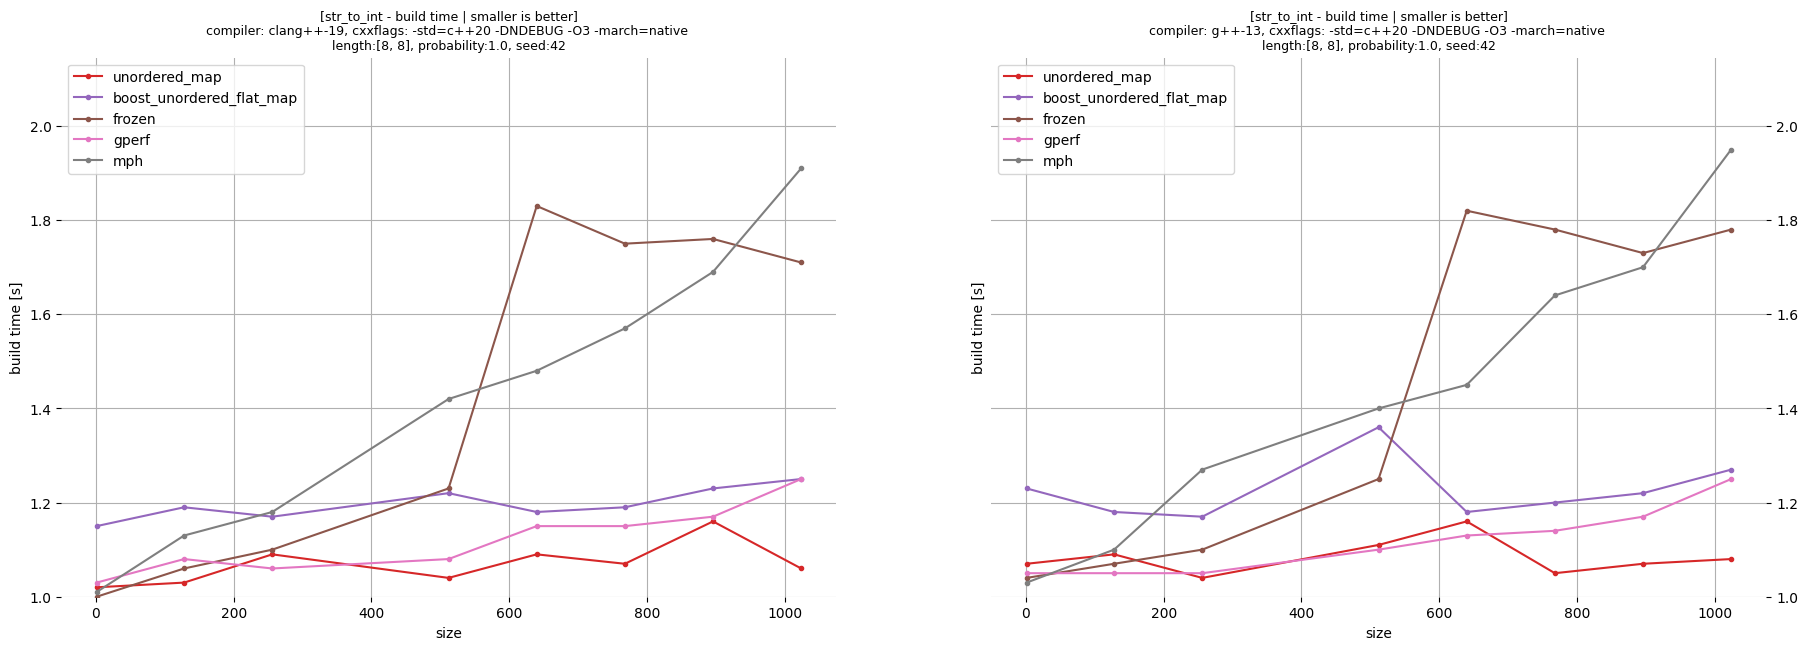

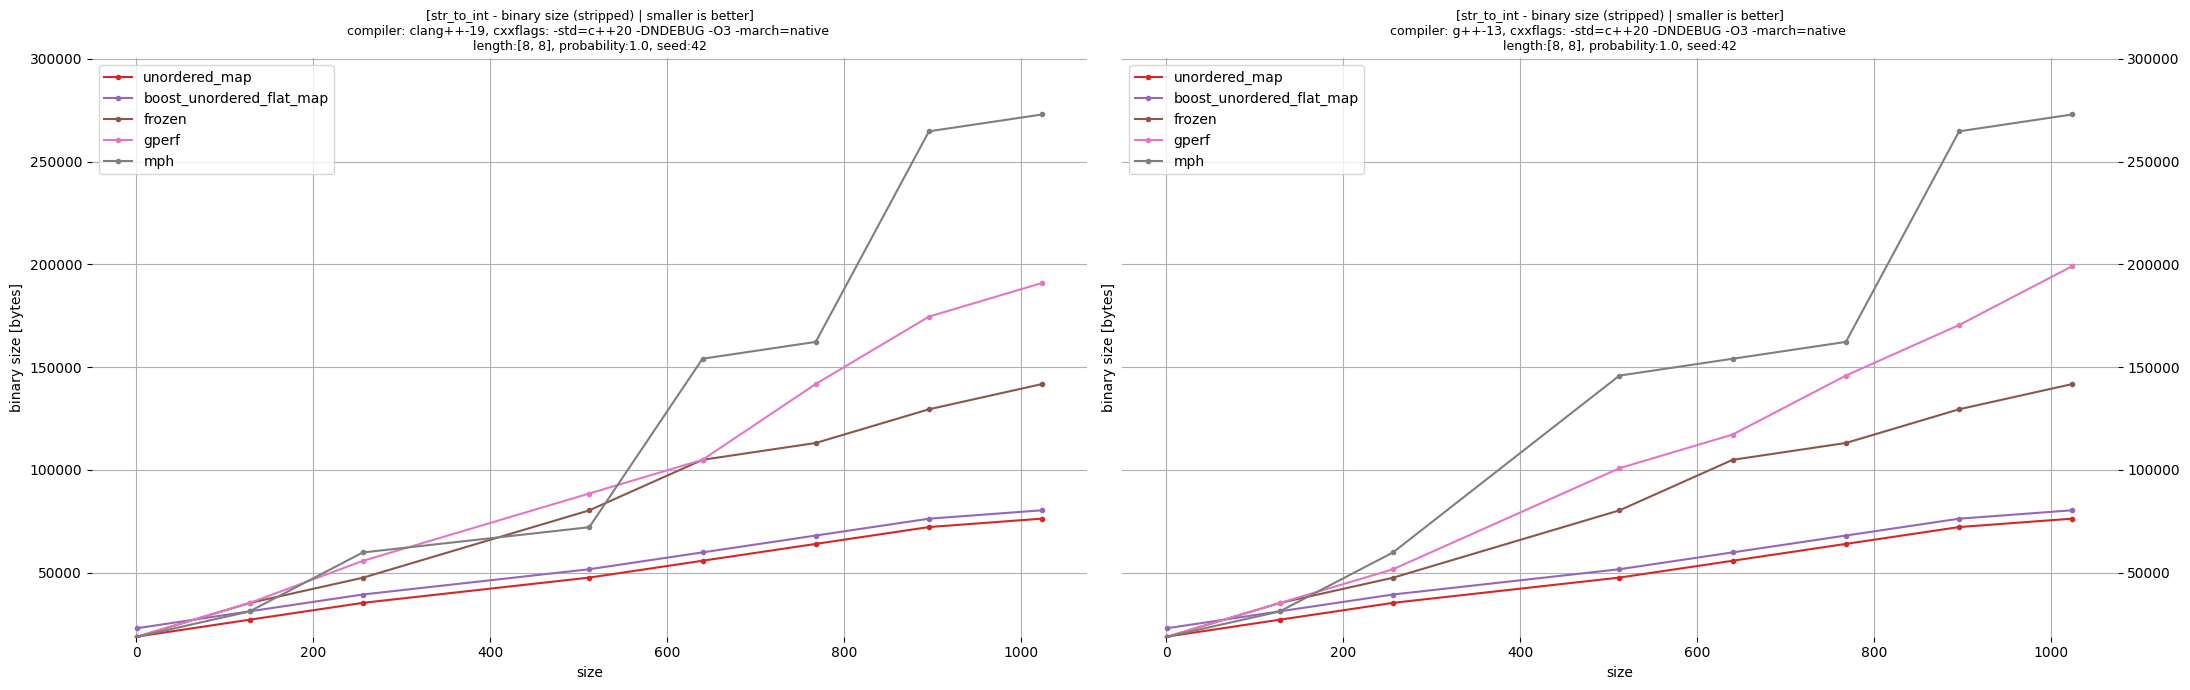

................................................................................

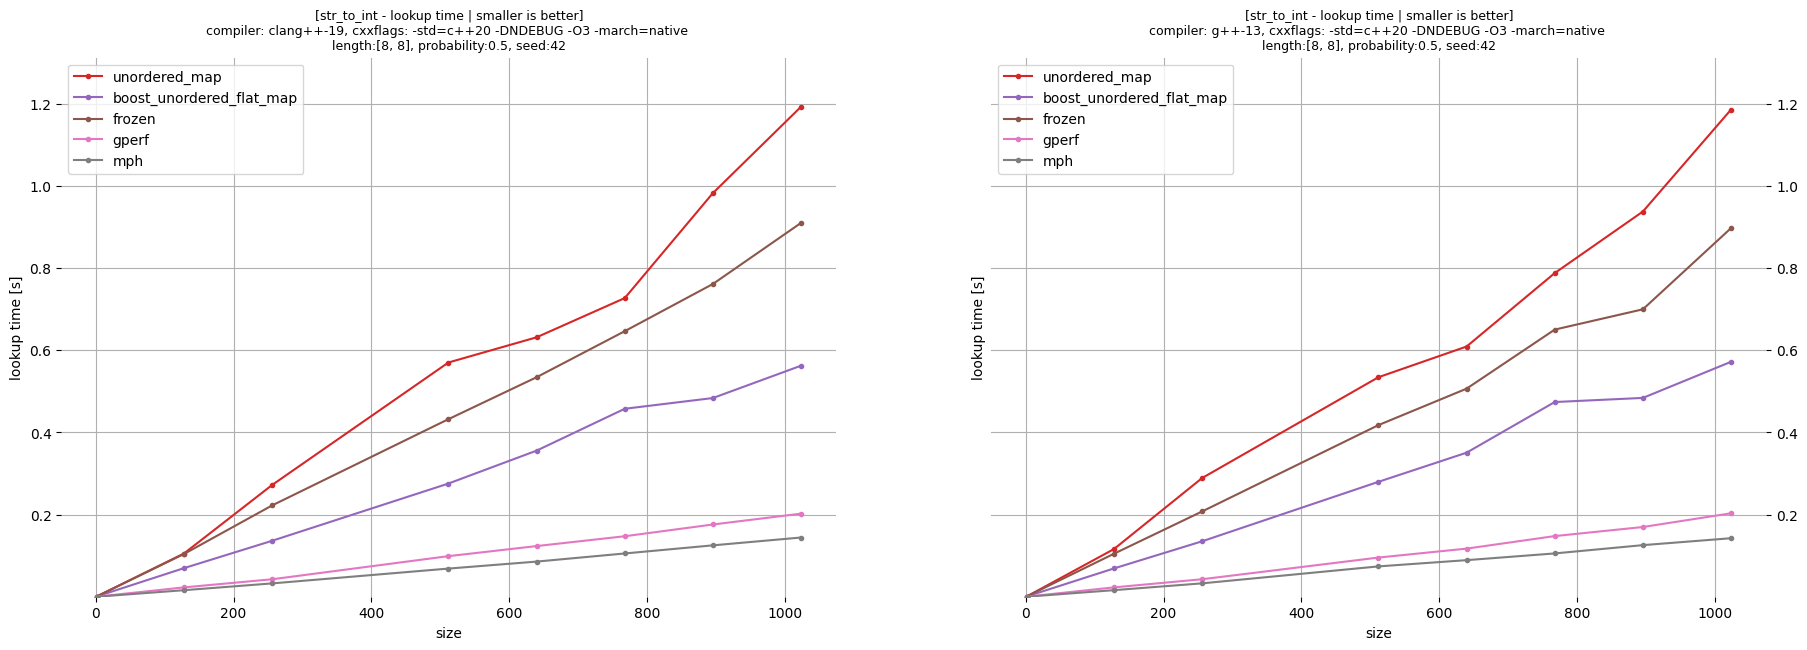

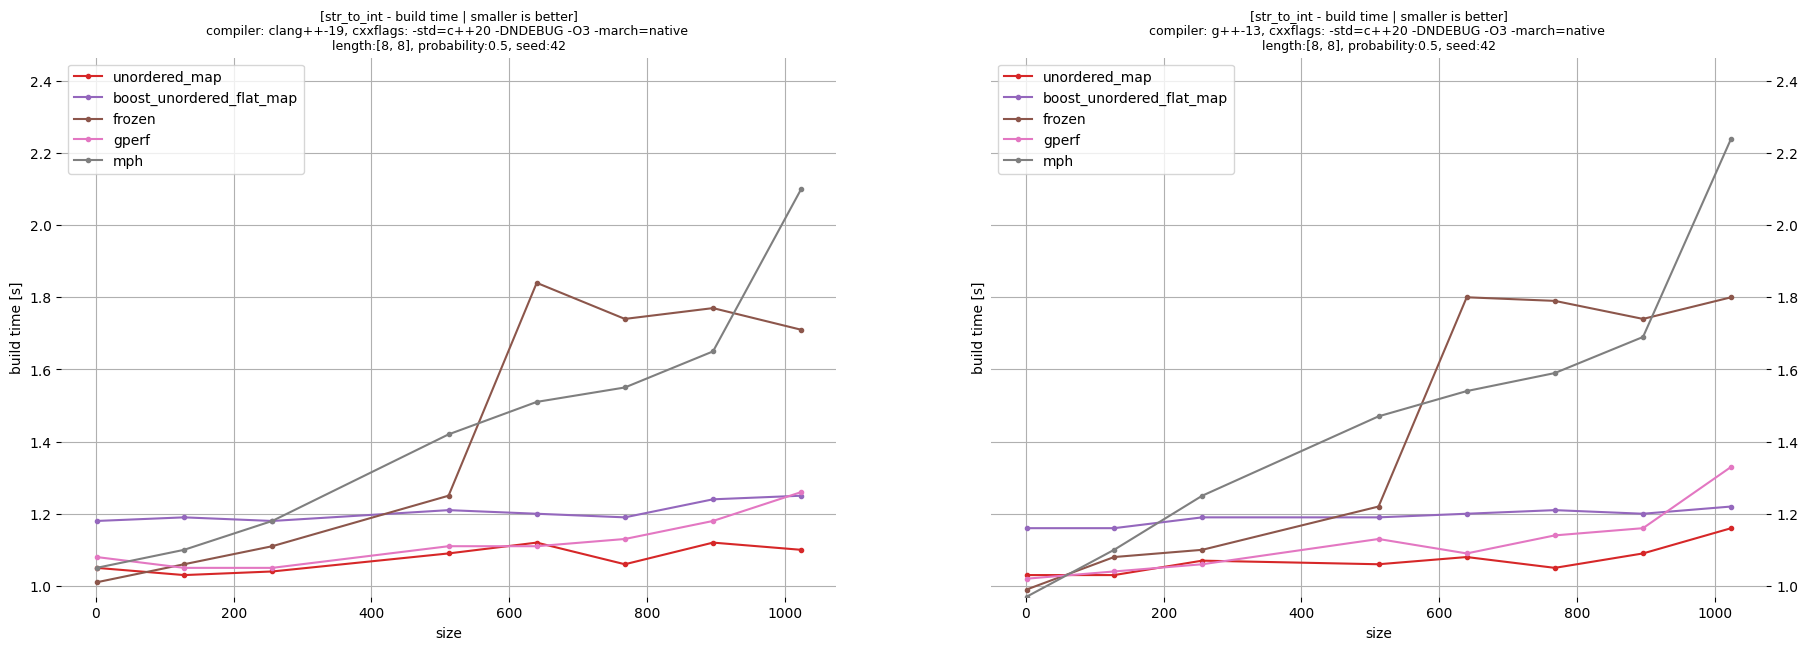

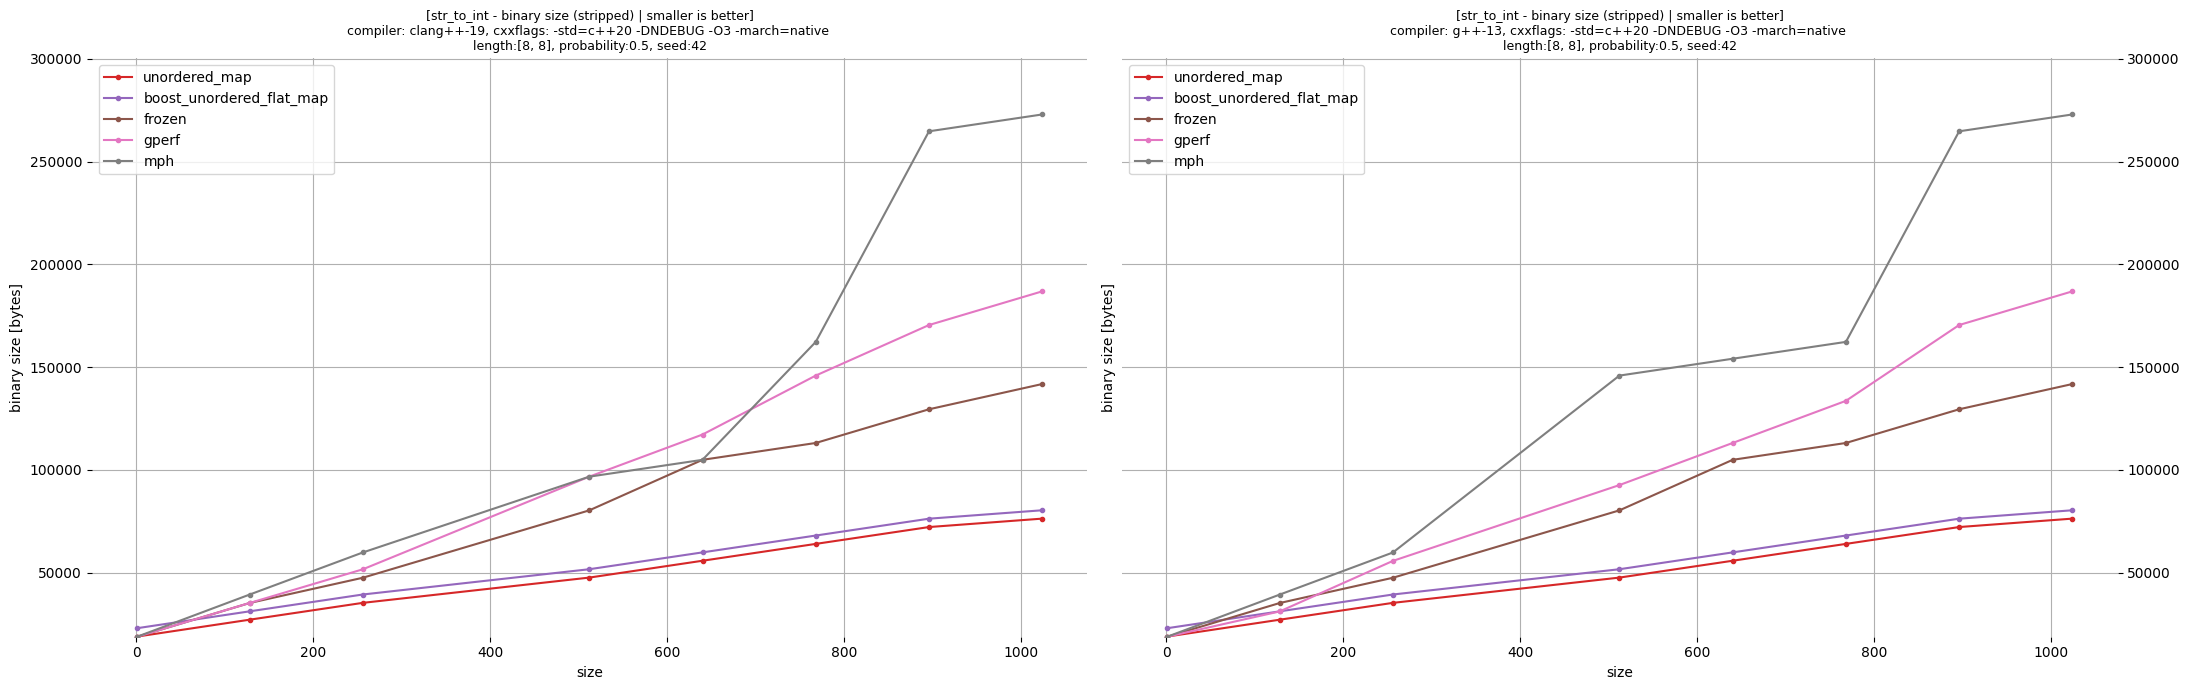

................................................................................

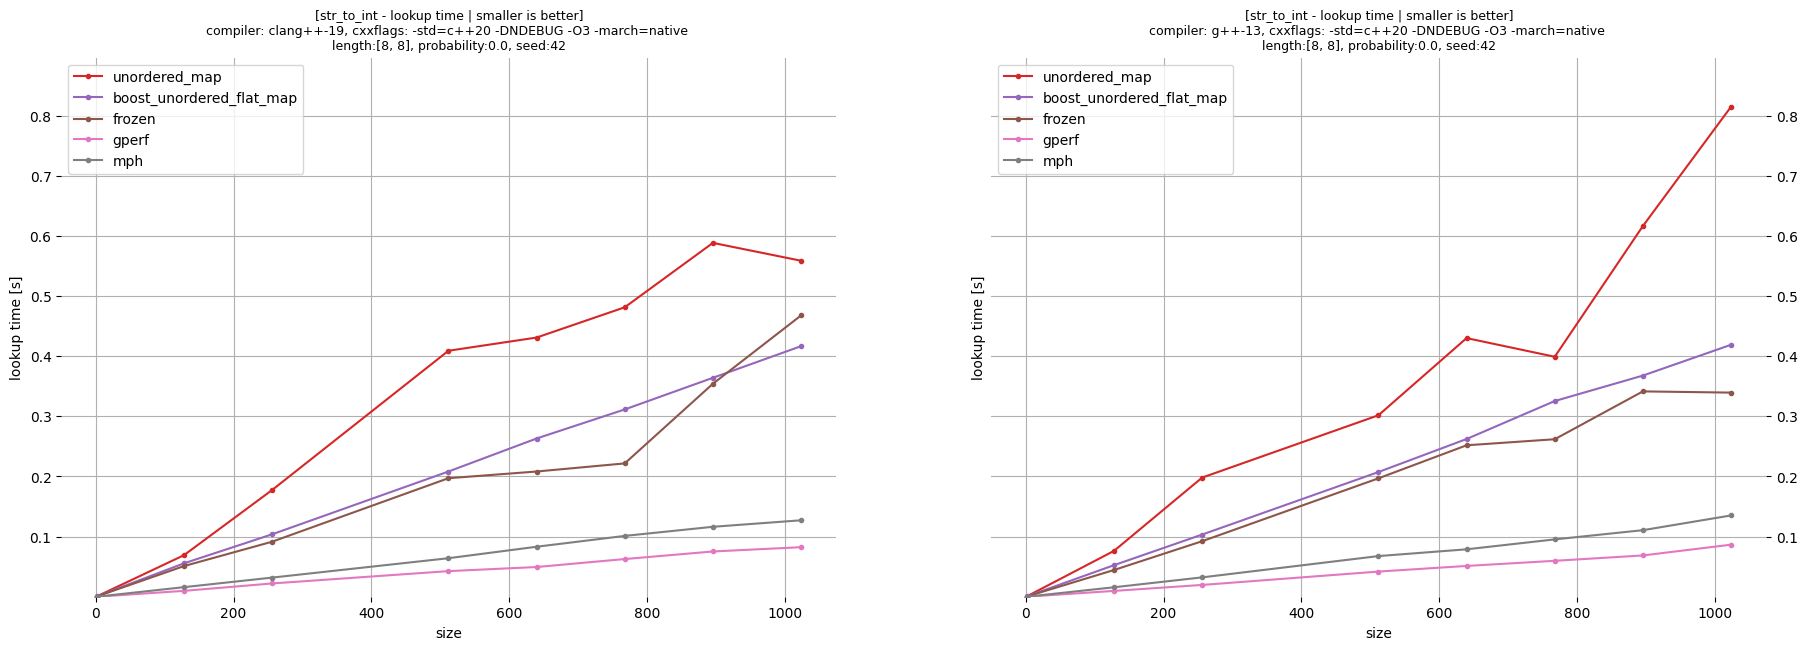

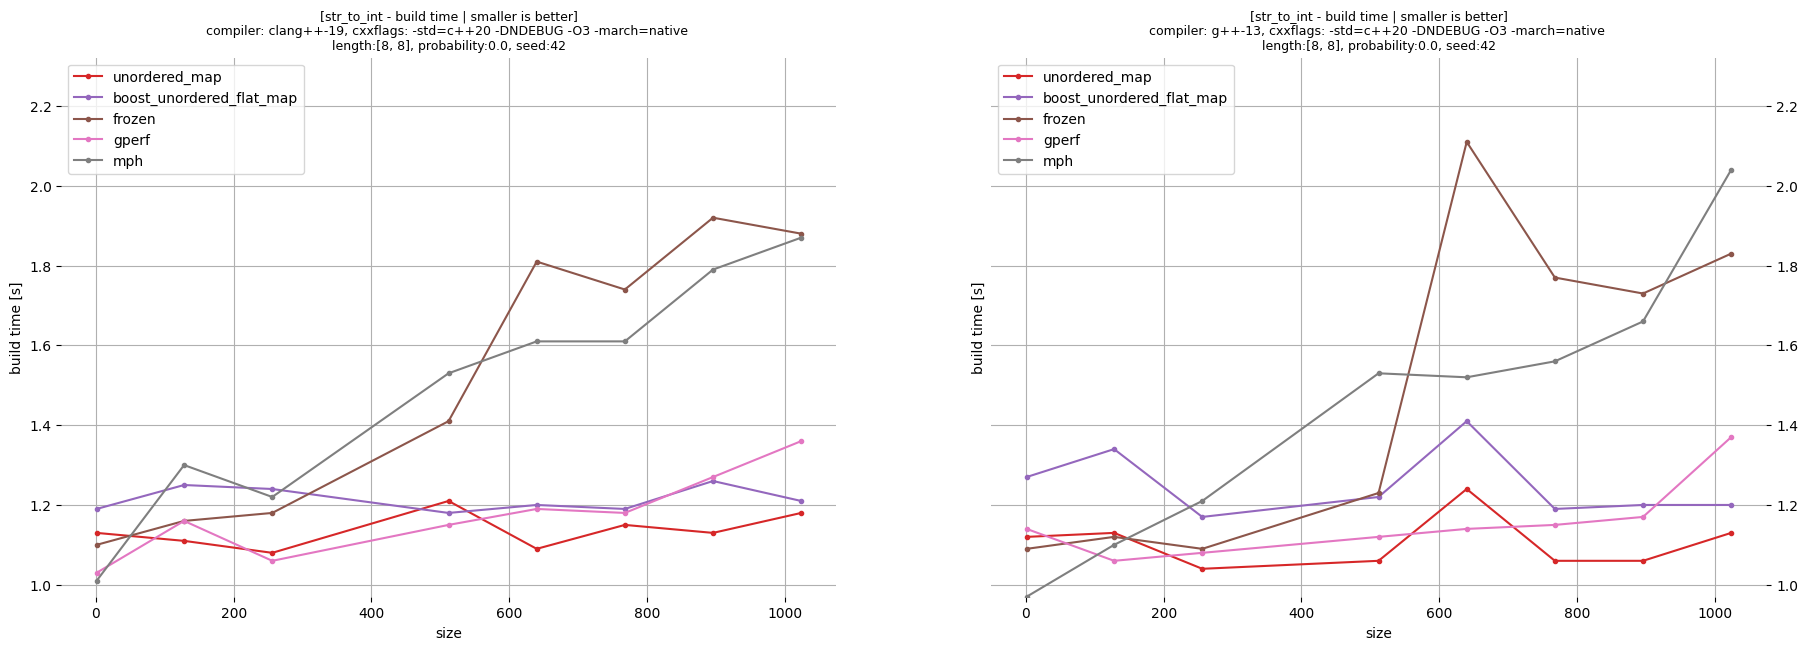

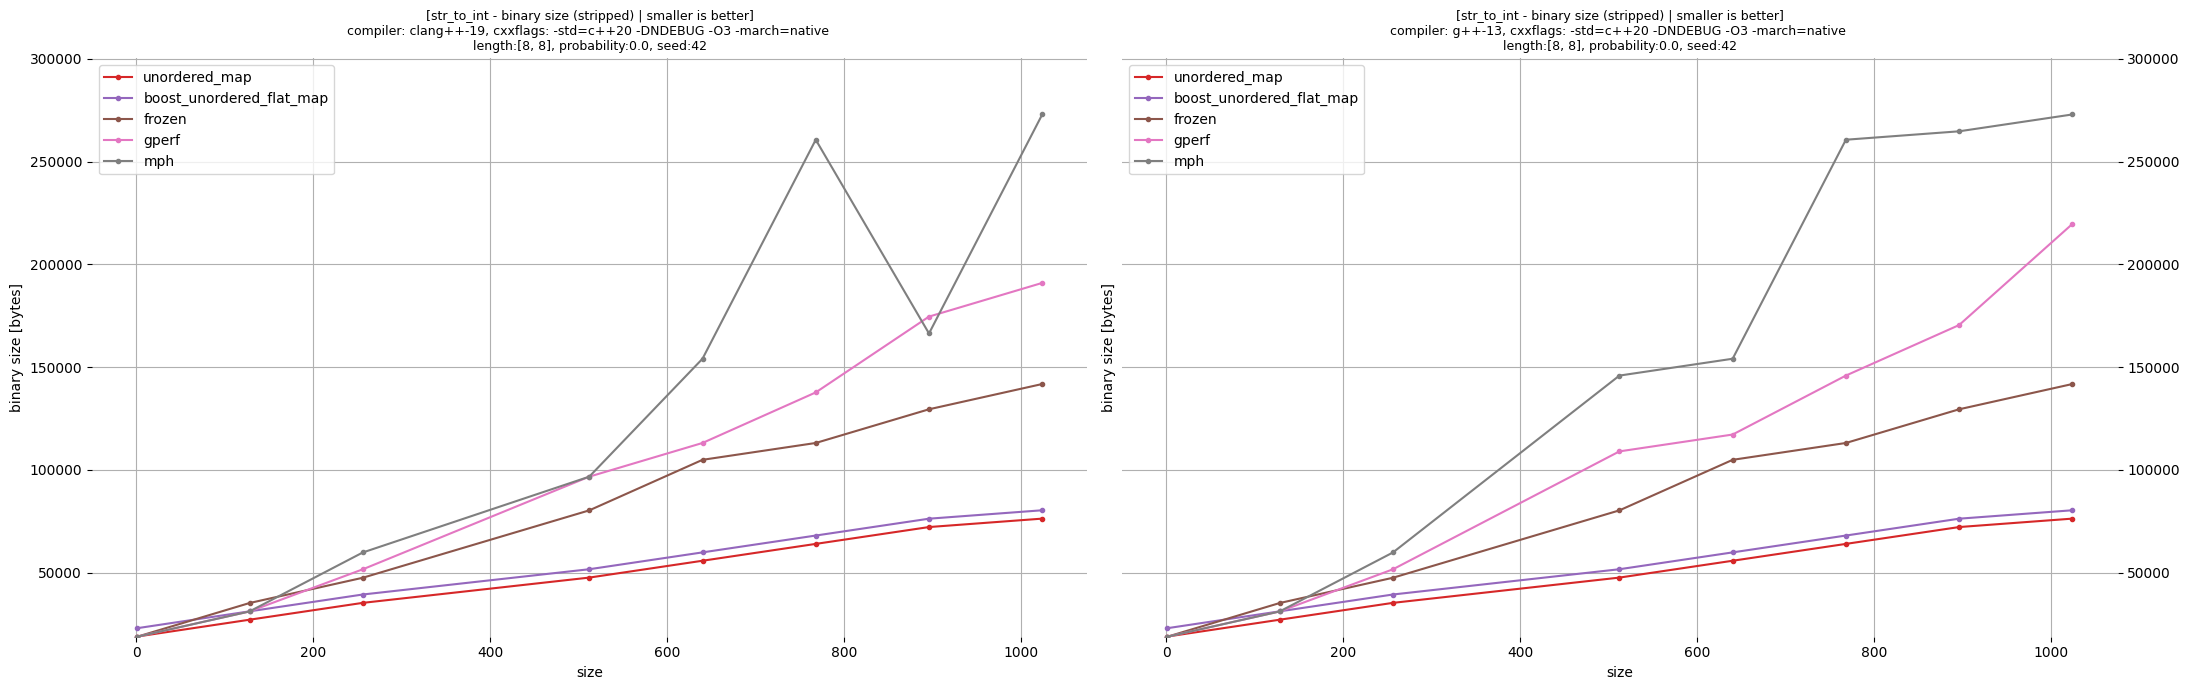

In [6]:
seed         = 42
range_1_32   = [1, 4, 8, 12, 16, 20, 24, 28, 32]
range_1_1024 = [1, 128, 256, 512, 640, 768, 896, 1024]

benchmark('int_to_int', ['clang++-19', 'g++-13'], ['if_else', 'switch_case', 'map', 'unordered_map', 'boost_unordered_flat_map', 'frozen', 'mph'], sizes = range_1_32, combinations = [        
  {'range': [0, np.iinfo(np.uint16).max], 'probability': 1.00, 'seed': seed},
  {'range': [0, np.iinfo(np.uint16).max], 'probability': 0.50, 'seed': seed},
  {'range': [0, np.iinfo(np.uint16).max], 'probability': 0.00, 'seed': seed},
])

benchmark('int_to_int', ['clang++-19', 'g++-13'], ['unordered_map', 'boost_unordered_flat_map', 'frozen', 'mph'], sizes = range_1_1024, combinations = [        
  {'range': [0, np.iinfo(np.uint32).max], 'probability': 1.00, 'seed': seed},
  {'range': [0, np.iinfo(np.uint32).max], 'probability': 0.50, 'seed': seed},
  {'range': [0, np.iinfo(np.uint32).max], 'probability': 0.00, 'seed': seed},
])

benchmark('str_to_int', ['clang++-19', 'g++-13'], ['if_else', 'map', 'unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range_1_32, combinations = [        
  {'length': [1, 8], 'probability': 1.00, 'seed': seed},
  {'length': [1, 8], 'probability': 0.50, 'seed': seed},
  {'length': [1, 8], 'probability': 0.00, 'seed': seed},
])

benchmark('str_to_int', ['clang++-19', 'g++-13'], ['unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range_1_1024, combinations = [        
  {'length': [1, 8], 'probability': 1.00, 'seed': seed},
  {'length': [1, 8], 'probability': 0.50, 'seed': seed},
  {'length': [1, 8], 'probability': 0.00, 'seed': seed},
])

benchmark('str_to_int', ['clang++-19', 'g++-13'], ['unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range_1_32, combinations = [        
  {'length': [8, 8], 'probability': 1.00, 'seed': seed},
  {'length': [8, 8], 'probability': 0.50, 'seed': seed},
  {'length': [8, 8], 'probability': 0.00, 'seed': seed},
])

benchmark('str_to_int', ['clang++-19', 'g++-13'], ['unordered_map', 'boost_unordered_flat_map', 'frozen', 'gperf', 'mph'], sizes = range_1_1024, combinations = [        
  {'length': [8, 8], 'probability': 1.00, 'seed': seed},
  {'length': [8, 8], 'probability': 0.50, 'seed': seed},
  {'length': [8, 8], 'probability': 0.00, 'seed': seed},
])